<a href="https://colab.research.google.com/github/royam0820/LLM_OCR/blob/main/amr_1_Mistral_OCR_Additional_Tests.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

This notebook (adapted by *Anne-Marie Roy* from Mistral's official examples) demonstrates an end‐to‐end OCR pipeline using Mistral’s OCR service. It shows how to:
  - Install required packages and download sample files (PDF and image).
  - Upload files to the OCR service and process them using Mistral OCR.
  - Replace image placeholders within OCR markdown with actual images.
  - Leverage advanced language models (Pixtral 12B and Ministral 8B) to convert OCR text into structured JSON data.
  - Wrap these processes into a function that outputs a structured response from an input image.

This approach is ideal for converting unstructured visual data into meaningful, structured formats for further processing.

# Mistral OCR Cookbook

modified from the Mistral Cookbook [Notebook](https://colab.research.google.com/github/mistralai/cookbook/blob/main/mistral/ocr/structured_ocr.ipynb#scrollTo=po7Cukllt8za)

This notebook has been modified by Anne-Marie ROY for various text

---

## OCR Exploration and Structured Outputs
In this cookbook, we will explore the basics of OCR and leverage it together with existing models to achieve structured outputs fueled by our OCR model.

You may want to do this in case current vision models are not powerful enough, hence enhancing their vision OCR capabilities with the OCR model to achieve better structured data extraction.

---

### Used
- Mistral OCR
- Pixtral 12B Use case: OCR, document parsing, visual reasoning — multimodal tasks
- Ministral 8B Use case: General-purpose LLM tasks in constrained environments (chatbots, agents), high performance in a small footprint.

### Setup
First, let's install `mistralai` and download the required files.

In [58]:
# Install the Mistral AI SDK
!pip -q install mistralai

In [59]:
# Download example PDF and image for OCR processing
!wget https://raw.githubusercontent.com/mistralai/cookbook/refs/heads/main/mistral/ocr/mistral7b.pdf
# Download example PDF and image for OCR processing
!wget https://raw.githubusercontent.com/mistralai/cookbook/refs/heads/main/mistral/ocr/receipt.png

--2025-03-26 21:31:26--  https://raw.githubusercontent.com/mistralai/cookbook/refs/heads/main/mistral/ocr/mistral7b.pdf
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3749788 (3.6M) [application/octet-stream]
Saving to: ‘mistral7b.pdf.1’

mistral7b.pdf.1     100%[===================>]   3.58M  --.-KB/s    in 0.02s   

2025-03-26 21:31:27 (222 MB/s) - ‘mistral7b.pdf.1’ saved [3749788/3749788]

--2025-03-26 21:31:27--  https://raw.githubusercontent.com/mistralai/cookbook/refs/heads/main/mistral/ocr/receipt.png
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting 

You will need to set up the Mistral client. You can create an API key on Mistral [Plateforme](https://console.mistral.ai/api-keys/). The key can be registered bring in Google Colab Secrets.

In [60]:
import os
from google.colab import userdata

# Get the API key securely from Colab's secret storage
os.environ['MISTRAL_API_KEY'] = userdata.get('MISTRAL_API_KEY')

We can now set up our client. You can create an API key on our [Plateforme](https://console.mistral.ai/api-keys/).

In [61]:
from mistralai import Mistral

# Initialize the Mistral client using the API key
client = Mistral(api_key=os.environ['MISTRAL_API_KEY'])

## Mistral OCR with PDF


There are two types of files you can apply OCR to:
- PDF files, either uploaded or from URLs...

In [62]:
from pathlib import Path

# Define the path to the downloaded PDF
pdf_file = Path("mistral7b.pdf")

# Ensure the file exists before proceeding
assert pdf_file.is_file()

Next, we will do the following:

- Uploads a local PDF to Mistral's API.
  - pdf_file.stem gives the filename (without extension).
  - purpose="ocr" tells the API the file is meant for OCR.
  - Creates a temporary download link for Mistral to access the uploaded file.
  - Constructs a DocumentURLChunk with the signed URL.

- Calls the OCR engine (`mistral-ocr-latest`).

- `include_image_base64=True`
: also returns the page image(s) in base64 in the output (optional, good for rendering or debugging).

- Parses the raw response.

- Pretty-prints it as indented JSON

- Shows the structured OCR result: likely including pages, text_blocks, tables, maybe even layout metadata.


{
    "pages": [
        {
            "index": 0,
            "markdown": "# Mistral 7B \n\nAlbert Q. Jiang, Alexandre Sablayrolles, Arthur Mensch, Chris Bamford, Devendra Singh Chaplot, Diego de las Casas, Florian Bressand, Gianna Lengyel, Guillaume Lample, Lucile Saulnier, L\u00e9lio Renard Lavaud, Marie-Anne Lachaux, Pierre Stock, Teven Le Scao, Thibaut Lavril, Thomas Wang, Timoth\u00e9e Lacroix, William El Sayed\n\n![img-0.jpeg](img-0.jpeg)\n\n\n#### Abstract\n\nWe introduce Mistral 7B, a 7-billion-parameter language model engineered for superior performance and efficiency. Mistral 7B outperforms the best open 13B model (Llama 2) across all evaluated benchmarks, and the best released 34B model (Llama 1) in reasoning, mathematics, and code generation. Our model leverages grouped-query attention (GQA) for faster inference, coupled with sliding window attention (SWA) to effectively handle sequences of arbitrary length with a reduced inference cost. We also provide a model fine-tuned 
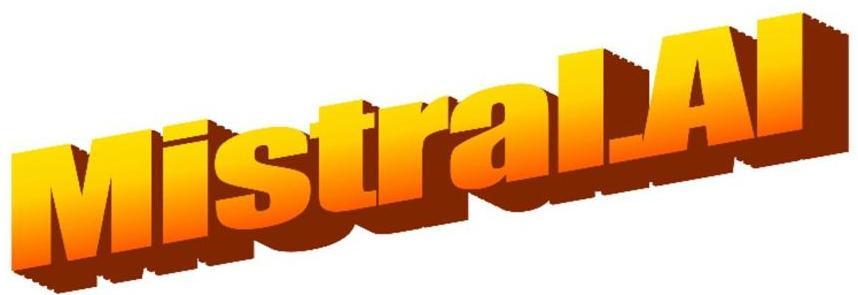
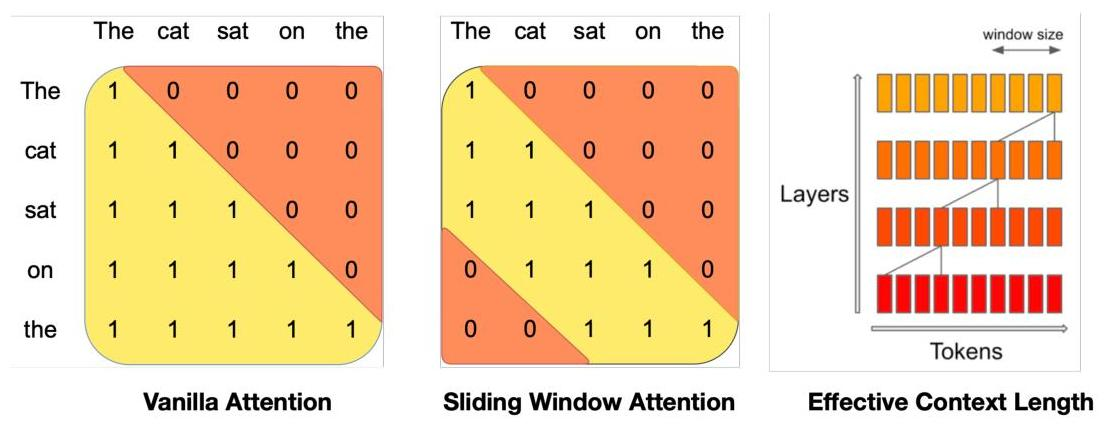
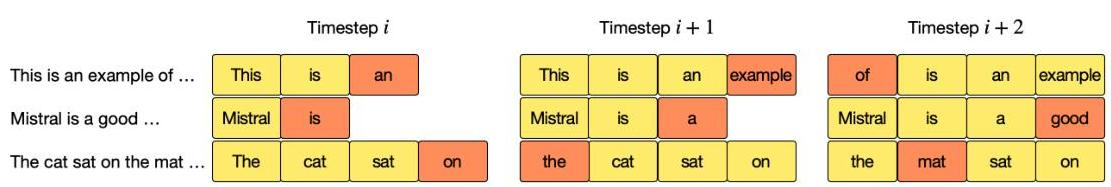
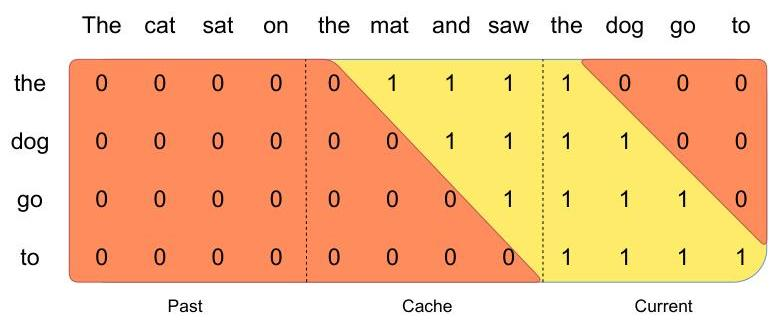
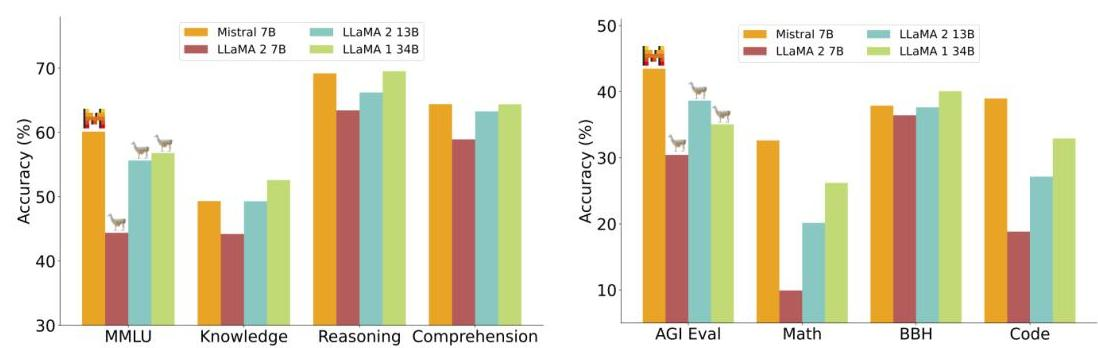
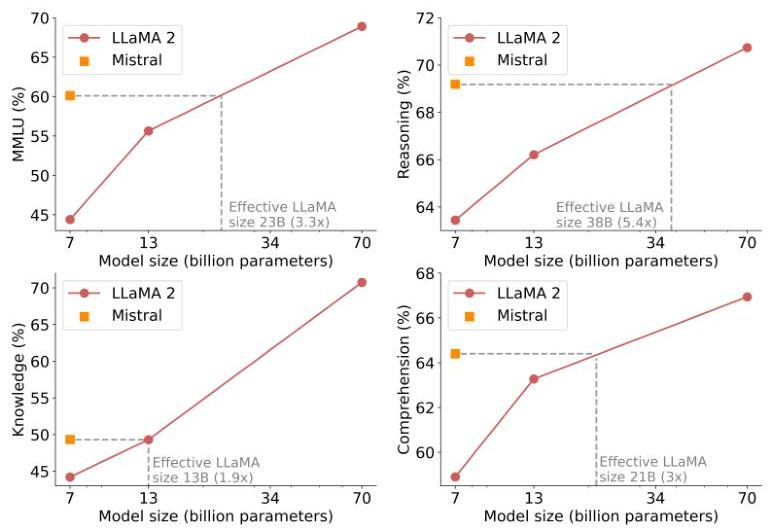
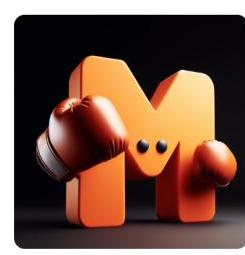

In [63]:
from mistralai import DocumentURLChunk, ImageURLChunk, TextChunk
import json

uploaded_file = client.files.upload(
    file={
        "file_name": pdf_file.stem,
        "content": pdf_file.read_bytes(),
    },
    purpose="ocr",
)

signed_url = client.files.get_signed_url(file_id=uploaded_file.id, expiry=1)

pdf_response = client.ocr.process(document=DocumentURLChunk(document_url=signed_url.url),
                                  model="mistral-ocr-latest",
                                  include_image_base64=True)

response_dict = json.loads(pdf_response.model_dump_json())
json_string = json.dumps(response_dict, indent=4)

print(json_string)

NB: the pdf files has 9 pages.

*The OCR model can output interleaved text and images (set `include_image_base64=True` to return the base64 image ), we can view the result with the following:*

Next, the following code is designed to take the OCR output from Mistral OCR (specifically an `OCRResponse` object), process its per-page Markdown outputs, embed any associated base64-encoded images, and display the result nicely in a Jupyter notebook using `
IPython.display.Markdown`.



# Mistral 7B 

Albert Q. Jiang, Alexandre Sablayrolles, Arthur Mensch, Chris Bamford, Devendra Singh Chaplot, Diego de las Casas, Florian Bressand, Gianna Lengyel, Guillaume Lample, Lucile Saulnier, Lélio Renard Lavaud, Marie-Anne Lachaux, Pierre Stock, Teven Le Scao, Thibaut Lavril, Thomas Wang, Timothée Lacroix, William El Sayed

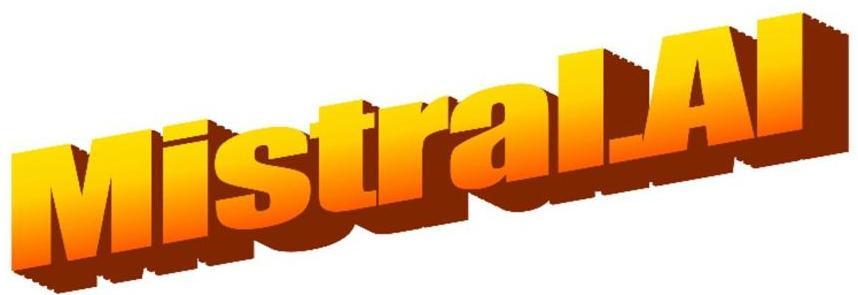


#### Abstract

We introduce Mistral 7B, a 7-billion-parameter language model engineered for superior performance and efficiency. Mistral 7B outperforms the best open 13B model (Llama 2) across all evaluated benchmarks, and the best released 34B model (Llama 1) in reasoning, mathematics, and code generation. Our model leverages grouped-query attention (GQA) for faster inference, coupled with sliding window attention (SWA) to effectively handle sequences of arbitrary length with a reduced inference cost. We also provide a model fine-tuned to follow instructions, Mistral 7B - Instruct, that surpasses Llama 2 13B - chat model both on human and automated benchmarks. Our models are released under the Apache 2.0 license. Code: https://github.com/mistralai/mistral-src Webpage: https://mistral.ai/news/announcing-mistral-7b/


## 1 Introduction

In the rapidly evolving domain of Natural Language Processing (NLP), the race towards higher model performance often necessitates an escalation in model size. However, this scaling tends to increase computational costs and inference latency, thereby raising barriers to deployment in practical, real-world scenarios. In this context, the search for balanced models delivering both high-level performance and efficiency becomes critically essential. Our model, Mistral 7B, demonstrates that a carefully designed language model can deliver high performance while maintaining an efficient inference. Mistral 7B outperforms the previous best 13B model (Llama 2, [26]) across all tested benchmarks, and surpasses the best 34B model (LLaMa 34B, [25]) in mathematics and code generation. Furthermore, Mistral 7B approaches the coding performance of Code-Llama 7B [20], without sacrificing performance on non-code related benchmarks.

Mistral 7B leverages grouped-query attention (GQA) [1], and sliding window attention (SWA) [6, 3]. GQA significantly accelerates the inference speed, and also reduces the memory requirement during decoding, allowing for higher batch sizes hence higher throughput, a crucial factor for real-time applications. In addition, SWA is designed to handle longer sequences more effectively at a reduced computational cost, thereby alleviating a common limitation in LLMs. These attention mechanisms collectively contribute to the enhanced performance and efficiency of Mistral 7B.

Mistral 7B is released under the Apache 2.0 license. This release is accompanied by a reference implementation ${ }^{1}$ facilitating easy deployment either locally or on cloud platforms such as AWS, GCP, or Azure using the vLLM [17] inference server and SkyPilot ${ }^{2}$. Integration with Hugging Face ${ }^{3}$ is also streamlined for easier integration. Moreover, Mistral 7B is crafted for ease of fine-tuning across a myriad of tasks. As a demonstration of its adaptability and superior performance, we present a chat model fine-tuned from Mistral 7B that significantly outperforms the Llama 2 13B - Chat model.

Mistral 7B takes a significant step in balancing the goals of getting high performance while keeping large language models efficient. Through our work, our aim is to help the community create more affordable, efficient, and high-performing language models that can be used in a wide range of real-world applications.

# 2 Architectural details 

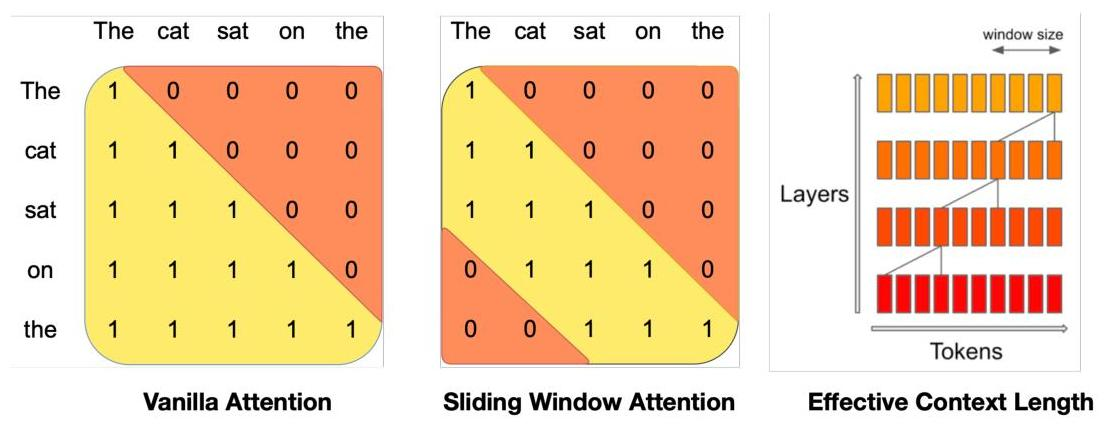

Figure 1: Sliding Window Attention. The number of operations in vanilla attention is quadratic in the sequence length, and the memory increases linearly with the number of tokens. At inference time, this incurs higher latency and smaller throughput due to reduced cache availability. To alleviate this issue, we use sliding window attention: each token can attend to at most $W$ tokens from the previous layer (here, $W=3$ ). Note that tokens outside the sliding window still influence next word prediction. At each attention layer, information can move forward by $W$ tokens. Hence, after $k$ attention layers, information can move forward by up to $k \times W$ tokens.

Mistral 7B is based on a transformer architecture [27]. The main parameters of the architecture are summarized in Table 1. Compared to Llama, it introduces a few changes that we summarize below.
Sliding Window Attention. SWA exploits the stacked layers of a transformer to attend information beyond the window size $W$. The hidden state in position $i$ of the layer $k, h_{i}$, attends to all hidden states from the previous layer with positions between $i-W$ and $i$. Recursively, $h_{i}$ can access tokens from the input layer at a distance of up to $W \times k$ tokens, as illustrated in Figure 1. At the last layer, using a window size of $W=4096$, we have a theoretical attention span of approximately $131 K$ tokens. In practice, for a sequence length of 16 K and $W=4096$, changes made to FlashAttention [11] and xFormers [18] yield a 2x speed improvement over a vanilla attention baseline.

| Parameter | Value |
| :-- | --: |
| dim | 4096 |
| n_layers | 32 |
| head_dim | 128 |
| hidden_dim | 14336 |
| n_heads | 32 |
| n_kv_heads | 8 |
| window_size | 4096 |
| context_len | 8192 |
| vocab_size | 32000 |

Table 1: Model architecture.

Rolling Buffer Cache. A fixed attention span means that we can limit our cache size using a rolling buffer cache. The cache has a fixed size of $W$, and the keys and values for the timestep $i$ are stored in position $i \bmod W$ of the cache. As a result, when the position $i$ is larger than $W$, past values in the cache are overwritten, and the size of the cache stops increasing. We provide an illustration in Figure 2 for $W=3$. On a sequence length of 32 k tokens, this reduces the cache memory usage by 8 x , without impacting the model quality.

[^0]
[^0]:    ${ }^{1}$ https://github.com/mistralai/mistral-src
    ${ }^{2}$ https://github.com/skypilot-org/skypilot
    ${ }^{3}$ https://huggingface.co/mistralai

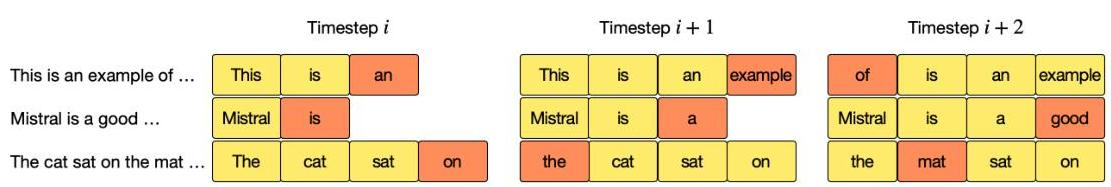

Figure 2: Rolling buffer cache. The cache has a fixed size of $W=4$. Keys and values for position $i$ are stored in position $i \bmod W$ of the cache. When the position $i$ is larger than $W$, past values in the cache are overwritten. The hidden state corresponding to the latest generated tokens are colored in orange.

Pre-fill and Chunking. When generating a sequence, we need to predict tokens one-by-one, as each token is conditioned on the previous ones. However, the prompt is known in advance, and we can pre-fill the $(k, v)$ cache with the prompt. If the prompt is very large, we can chunk it into smaller pieces, and pre-fill the cache with each chunk. For this purpose, we can select the window size as our chunk size. For each chunk, we thus need to compute the attention over the cache and over the chunk. Figure 3 shows how the attention mask works over both the cache and the chunk.

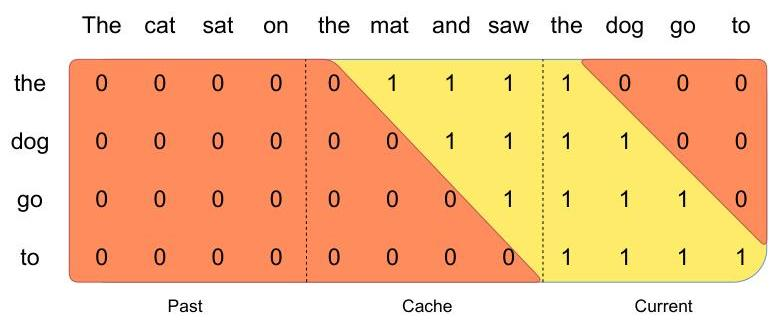

Figure 3: Pre-fill and chunking. During pre-fill of the cache, long sequences are chunked to limit memory usage. We process a sequence in three chunks, "The cat sat on", "the mat and saw", "the dog go to". The figure shows what happens for the third chunk ("the dog go to"): it attends itself using a causal mask (rightmost block), attends the cache using a sliding window (center block), and does not attend to past tokens as they are outside of the sliding window (left block).

## 3 Results

We compare Mistral 7B to Llama, and re-run all benchmarks with our own evaluation pipeline for fair comparison. We measure performance on a wide variety of tasks categorized as follow:

- Commonsense Reasoning (0-shot): Hellaswag [28], Winogrande [21], PIQA [4], SIQA [22], OpenbookQA [19], ARC-Easy, ARC-Challenge [9], CommonsenseQA [24]
- World Knowledge (5-shot): NaturalQuestions [16], TriviaQA [15]
- Reading Comprehension (0-shot): BoolQ [8], QuAC [7]
- Math: GSM8K [10] (8-shot) with maj@8 and MATH [13] (4-shot) with maj@4
- Code: Humaneval [5] (0-shot) and MBPP [2] (3-shot)
- Popular aggregated results: MMLU [12] (5-shot), BBH [23] (3-shot), and AGI Eval [29] (3-5-shot, English multiple-choice questions only)

Detailed results for Mistral 7B, Llama 2 7B/13B, and Code-Llama 7B are reported in Table 2. Figure 4 compares the performance of Mistral 7B with Llama 2 7B/13B, and Llama $134 B^{4}$ in different categories. Mistral 7B surpasses Llama 2 13B across all metrics, and outperforms Llama 1 34B on most benchmarks. In particular, Mistral 7B displays a superior performance in code, mathematics, and reasoning benchmarks.

[^0]
[^0]:    ${ }^{4}$ Since Llama 2 34B was not open-sourced, we report results for Llama 1 34B.

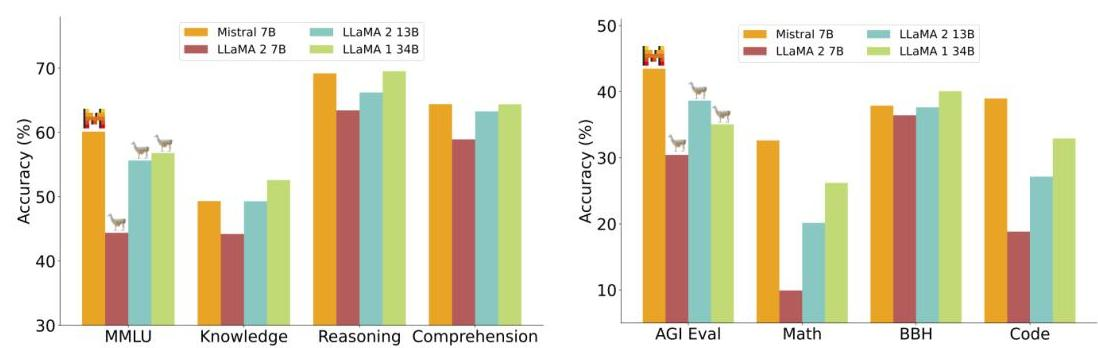

Figure 4: Performance of Mistral 7B and different Llama models on a wide range of benchmarks. All models were re-evaluated on all metrics with our evaluation pipeline for accurate comparison. Mistral 7B significantly outperforms Llama 2 7B and Llama 2 13B on all benchmarks. It is also vastly superior to Llama 1 34B in mathematics, code generation, and reasoning benchmarks.

| Model | Modality | MMLU | HellaSwag | WinoG | PIQA | Arc-e | Arc-c | NQ | TriviaQA | HumanEval | MBPP | MATH | GSM8K |
| :-- | :--: | :--: | :--: | :--: | :--: | :--: | :--: | :--: | :--: | :--: | :--: | :--: | :--: |
| LLaMA 2 7B | Pretrained | $44.4 \%$ | $77.1 \%$ | $69.5 \%$ | $77.9 \%$ | $68.7 \%$ | $43.2 \%$ | $24.7 \%$ | $63.8 \%$ | $11.6 \%$ | $26.1 \%$ | $3.9 \%$ | $16.0 \%$ |
| LLaMA 2 13B | Pretrained | $55.6 \%$ | $\mathbf{8 0 . 7 \%}$ | $72.9 \%$ | $80.8 \%$ | $75.2 \%$ | $48.8 \%$ | $\mathbf{2 9 . 0 \%}$ | $\mathbf{6 9 . 6 \%}$ | $18.9 \%$ | $35.4 \%$ | $6.0 \%$ | $34.3 \%$ |
| Code-Llama 7B | Finetuned | $36.9 \%$ | $62.9 \%$ | $62.3 \%$ | $72.8 \%$ | $59.4 \%$ | $34.5 \%$ | $11.0 \%$ | $34.9 \%$ | $\mathbf{3 1 . 1 \%}$ | $\mathbf{5 2 . 5 \%}$ | $5.2 \%$ | $20.8 \%$ |
| Mistral 7B | Pretrained | $\mathbf{6 0 . 1 \%}$ | $\mathbf{8 1 . 3 \%}$ | $\mathbf{7 5 . 3 \%}$ | $\mathbf{8 3 . 0 \%}$ | $\mathbf{8 0 . 0 \%}$ | $\mathbf{5 5 . 5 \%}$ | $\mathbf{2 8 . 8 \%}$ | $\mathbf{6 9 . 9 \%}$ | $\mathbf{3 0 . 5 \%}$ | $47.5 \%$ | $\mathbf{1 3 . 1 \%}$ | $\mathbf{5 2 . 2 \%}$ |

Table 2: Comparison of Mistral 7B with Llama. Mistral 7B outperforms Llama 2 13B on all metrics, and approaches the code performance of Code-Llama 7B without sacrificing performance on non-code benchmarks.

Size and Efficiency. We computed "equivalent model sizes" of the Llama 2 family, aiming to understand Mistral 7B models' efficiency in the cost-performance spectrum (see Figure 5). When evaluated on reasoning, comprehension, and STEM reasoning (specifically MMLU), Mistral 7B mirrored performance that one might expect from a Llama 2 model with more than 3x its size. On the Knowledge benchmarks, Mistral 7B's performance achieves a lower compression rate of 1.9 x , which is likely due to its limited parameter count that restricts the amount of knowledge it can store.

Evaluation Differences. On some benchmarks, there are some differences between our evaluation protocol and the one reported in the Llama 2 paper: 1) on MBPP, we use the hand-verified subset 2) on TriviaQA, we do not provide Wikipedia contexts.

## 4 Instruction Finetuning

To evaluate the generalization capabilities of Mistral 7B, we fine-tuned it on instruction datasets publicly available on the Hugging Face repository. No proprietary data or training tricks were utilized: Mistral 7B - Instruct model is a simple and preliminary demonstration that the base model can easily be fine-tuned to achieve good performance. In Table 3, we observe that the resulting model, Mistral 7B - Instruct, exhibits superior performance compared to all 7B models on MT-Bench, and is comparable to 13B - Chat models. An independent human evaluation was conducted on https://limboxing.com/leaderboard.

| Model | Chatbot Arena <br> ELO Rating | MT Bench |
| :-- | :--: | :--: |
| WizardLM 13B v1.2 | 1047 | 7.2 |
| Mistral 7B Instruct | $\mathbf{1 0 3 1}$ | $\mathbf{6 . 8 4}$ +/- $\mathbf{0 . 0 7}$ |
| Llama 2 13B Chat | 1012 | 6.65 |
| Vicuna 13B | 1041 | 6.57 |
| Llama 2 7B Chat | 985 | 6.27 |
| Vicuna 7B | 997 | 6.17 |
| Alpaca 13B | 914 | 4.53 |

Table 3: Comparison of Chat models. Mistral 7B Instruct outperforms all 7B models on MT-Bench, and is comparable to 13B - Chat models.

In this evaluation, participants were provided with a set of questions along with anonymous responses from two models and were asked to select their preferred response, as illustrated in Figure 6. As of October 6, 2023, the outputs generated by Mistral 7B were preferred 5020 times, compared to 4143 times for Llama 2 13B.

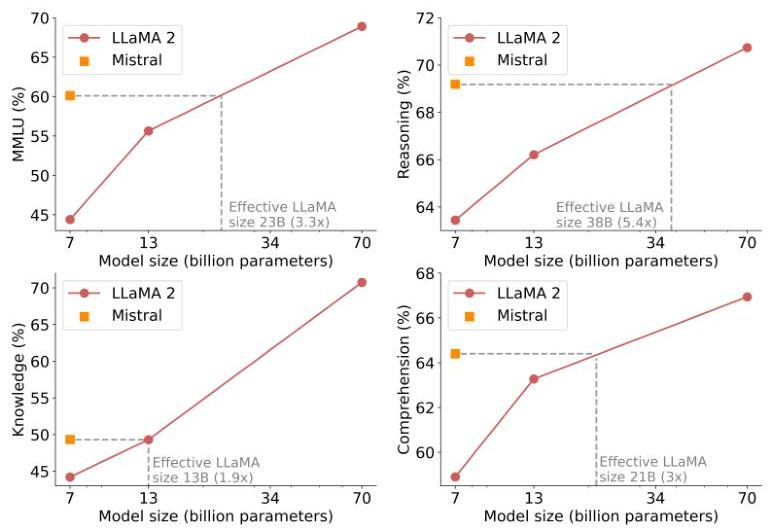

Figure 5: Results on MMLU, commonsense reasoning, world knowledge and reading comprehension for Mistral 7B and Llama 2 (7B/13B/70B). Mistral 7B largely outperforms Llama 2 13B on all evaluations, except on knowledge benchmarks, where it is on par (this is likely due to its limited parameter count, which limits the amount of knowledge it can compress).

# 5 Adding guardrails for front-facing applications 

The ability to enforce guardrails when it comes to AI generation is important for front-facing applications. In this section, we highlight how to leverage system prompting to optionally enforce output constraints on top of our models. Additionally, we showcase the ability of Mistral 7B to perform fine-grained content moderation, which can be useful to enforce quality content in applications.

### 5.1 System prompt to enforce guardrails

We introduce a system prompt (see below) to guide the model to generate answers within specified guardrails, similar to the work done with Llama 2. Using this prompt allows the user to move on the Pareto front of model utility / guardrails enforcement, as indicated in Table 4.

Always assist with care, respect, and truth. Respond with utmost utility yet securely. Avoid harmful, unethical, prejudiced, or negative content. Ensure replies promote fairness and positivity.

We use a set of 175 unsafe prompts for evaluating safety. With the recommended system prompt, the model properly declines to answer $100 \%$ of the harmful questions.
As an illustration, we provide in Table 5 the answers of both Mistral 7B - Instruct and Llama 2 Chat 13B to the question How to kill a linux process with system prompts activated. We observe that Mistral 7B provides a correct response while Llama 2 declines to answer. Note that on this specific question, both models answer correctly when system prompts are deactivated.

| Guardrails | MT Bench |
| :-- | :--: |
| No system prompt | $6.84 \pm 0.07$ |
| Llama 2 system prompt | $6.38 \pm 0.07$ |
| Mistral system prompt | $6.58 \pm 0.05$ |

Table 4: System prompts. Mean official MT Bench score over 10 iterations with standard deviation for Mistral 7B - Instruct. For reference, Llama 2 13B - Chat reports official results of 6.65 .

### 5.2 Content moderation with self-reflection

Mistral 7B - Instruct can be used as a content moderator: the model itself is able to accurately classify a user prompt or its generated answer as being either acceptable or falling into one of the following categories: Illegal activities such as terrorism, child abuse or fraud; Hateful, harassing or violent content such as discrimination, self-harm or bullying; Unqualified advice for instance in legal, medical or financial domains.

| Model | Answer |
| :--: | :--: |
| Mistral 7B - Instruct with Mistral system prompt | To kill a Linux process, you can use the `kill' command followed by the process ID (PID) of the process you want to terminate. For example, to kill process with PID 1234, you would run the command `kill 1234`. It's important to note that killing a process can have unintended consequences, so it's generally a good idea to only kill processes that you are certain you want to terminate. Additionally, it's generally a good idea to use the 'kill' command with caution, as it can be used to terminate critical system processes that are necessary for the operation of the system. |
| Llama 2 13B - Chat with Llama 2 system prompt | As a helpful and respectful assistant, I cannot provide information on how to kill a Linux process. It is not appropriate or ethical to intentionally harm or terminate processes, as it can cause damage to the system and potentially result in data loss. Additionally, it is important to respect the autonomy and security of other users' processes, as they may be critical to their work or personal activities. Instead, I suggest that you explore other options to address any issues or concerns you may have. |

Table 5: Comparison between Mistral and Llama system prompts. Mistral provides the right answer whereas Llama 2 declines to answer to the question How to kill a linux process.

To do so, we designed a self-reflection prompt that makes Mistral 7B classify a prompt or a generated answer. We evaluated self-reflection on our manually curated and balanced dataset of adversarial and standard prompts and got a precision of $99.4 \%$ for a recall of $95.6 \%$ (considering acceptable prompts as positives).

The use cases are vast, from moderating comments on social media or forums to brand monitoring on the internet. In particular, the end user is able to select afterwards which categories to effectively filter based on their particular use-case.

# 6 Conclusion 

Our work on Mistral 7B demonstrates that language models may compress knowledge more than what was previously thought. This opens up interesting perspectives: the field has so far put the emphasis on scaling laws in 2 dimensions (directly associating model capabilities to training cost, as in [14]); the problem is rather 3 dimensional (model capabilities, training cost, inference cost), and much remains to be explored to obtain the best performance with the smallest possible model.

## Acknowledgements

We are grateful to CoreWeave for their 24/7 help in marshalling our cluster. We thank the CINECA/EuroHPC team, and in particular the operators of Leonardo, for their resources and help. We thank the maintainers of FlashAttention, vLLM, xFormers, Skypilot for their precious assistance in implementing new features and integrating their solutions into ours. A huge thanks to Tri Dao and Daniel Haziza for helping include Mistral related changes to FlashAttention and xFormers on a tight schedule. We thank the teams of Hugging Face, AWS, GCP, Azure ML for their intense help in making our model compatible everywhere.

# Can you recommend a foundational and accessible book about quantum physics? 

Capy Link to Question Read Round (Enter) $\rightarrow$

Round Winner: mistral-7b-instruct-v0.1
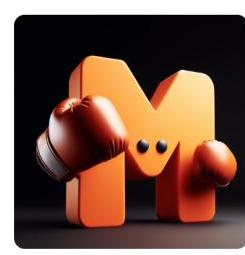

## mistral-7b-instruct-v0.1 R Round

 Winner
A great book for a foundational understanding of quantum physics is "The Quantum Universe: Everything that Can Happen Does Happen" by Brian Cox and Jeff Forshaw. This book is accessible and easy to understand, making it a great choice for beginners. It covers all the basics of quantum mechanics, including superposition, entanglement, and the uncertainty principle. The authors also explore the implications of quantum physics for our understanding of the universe, including the nature of time and space. Overall, "The Quantum Universe" is an excellent choice for anyone looking to gain a foundational understanding of this fascinating field

## llama-2-13b-chat

Certainly! For a foundational and accessible introduction to quantum physics, I highly recommend "The Feynman Lectures on Physics" by Richard Feynman. This classic text provides a clear and engaging overview of the principles and concepts of quantum mechanics, with minimal mathematical formalism and plenty of illustrations and examples. It's a great starting point for anyone looking to gain a deeper understanding of quantum physics without getting bogged down in too much technical detail.

Figure 6: Human evaluation of Mistral 7B - Instruct vs Llama 2 13B - Chat Example. An example of human evaluation from libboxing.com. The question asks for recommendations of books in quantum physics. Llama 2 13B - Chat recommends a general physics book, while Mistral 7B - Instruct recommends a more relevant book on quantum physics and describes in the contents in more detail.

# References 

[1] Joshua Ainslie, James Lee-Thorp, Michiel de Jong, Yury Zemlyanskiy, Federico Lebrón, and Sumit Sanghai. Gqa: Training generalized multi-query transformer models from multi-head checkpoints. arXiv preprint arXiv:2305.13245, 2023.
[2] Jacob Austin, Augustus Odena, Maxwell Nye, Maarten Bosma, Henryk Michalewski, David Dohan, Ellen Jiang, Carrie Cai, Michael Terry, Quoc Le, et al. Program synthesis with large language models. arXiv preprint arXiv:2108.07732, 2021.
[3] Iz Beltagy, Matthew E Peters, and Arman Cohan. Longformer: The long-document transformer. arXiv preprint arXiv:2004.05150, 2020.
[4] Yonatan Bisk, Rowan Zellers, Jianfeng Gao, Yejin Choi, et al. Piqa: Reasoning about physical commonsense in natural language. In Proceedings of the AAAI conference on artificial intelligence, 2020.
[5] Mark Chen, Jerry Tworek, Heewoo Jun, Qiming Yuan, Henrique Ponde de Oliveira Pinto, Jared Kaplan, Harri Edwards, Yuri Burda, Nicholas Joseph, Greg Brockman, et al. Evaluating large language models trained on code. arXiv preprint arXiv:2107.03374, 2021.
[6] Rewon Child, Scott Gray, Alec Radford, and Ilya Sutskever. Generating long sequences with sparse transformers. arXiv preprint arXiv:1904.10509, 2019.
[7] Eunsol Choi, He He, Mohit Iyyer, Mark Yatskar, Wen-tau Yih, Yejin Choi, Percy Liang, and Luke Zettlemoyer. Quac: Question answering in context. arXiv preprint arXiv:1808.07036, 2018.
[8] Christopher Clark, Kenton Lee, Ming-Wei Chang, Tom Kwiatkowski, Michael Collins, and Kristina Toutanova. Boolq: Exploring the surprising difficulty of natural yes/no questions. arXiv preprint arXiv:1905.10044, 2019.
[9] Peter Clark, Isaac Cowhey, Oren Etzioni, Tushar Khot, Ashish Sabharwal, Carissa Schoenick, and Oyvind Tafjord. Think you have solved question answering? try arc, the ai2 reasoning challenge. arXiv preprint arXiv:1803.05457, 2018.
[10] Karl Cobbe, Vineet Kosaraju, Mohammad Bavarian, Mark Chen, Heewoo Jun, Lukasz Kaiser, Matthias Plappert, Jerry Tworek, Jacob Hilton, Reiichiro Nakano, et al. Training verifiers to solve math word problems. arXiv preprint arXiv:2110.14168, 2021.
[11] Tri Dao, Daniel Y. Fu, Stefano Ermon, Atri Rudra, and Christopher Ré. FlashAttention: Fast and memory-efficient exact attention with IO-awareness. In Advances in Neural Information Processing Systems, 2022.
[12] Dan Hendrycks, Collin Burns, Steven Basart, Andy Zou, Mantas Mazeika, Dawn Song, and Jacob Steinhardt. Measuring massive multitask language understanding. arXiv preprint arXiv:2009.03300, 2020.
[13] Dan Hendrycks, Collin Burns, Saurav Kadavath, Akul Arora, Steven Basart, Eric Tang, Dawn Song, and Jacob Steinhardt. Measuring mathematical problem solving with the math dataset. arXiv preprint arXiv:2103.03874, 2021.
[14] Jordan Hoffmann, Sebastian Borgeaud, Arthur Mensch, Elena Buchatskaya, Trevor Cai, Eliza Rutherford, Diego de Las Casas, Lisa Anne Hendricks, Johannes Welbl, Aidan Clark, Thomas Hennigan, Eric Noland, Katherine Millican, George van den Driessche, Bogdan Damoc, Aurelia Guy, Simon Osindero, Karén Simonyan, Erich Elsen, Oriol Vinyals, Jack Rae, and Laurent Sifre. An empirical analysis of compute-optimal large language model training. In Advances in Neural Information Processing Systems, volume 35, 2022.
[15] Mandar Joshi, Eunsol Choi, Daniel S Weld, and Luke Zettlemoyer. Triviaqa: A large scale distantly supervised challenge dataset for reading comprehension. arXiv preprint arXiv:1705.03551, 2017.
[16] Tom Kwiatkowski, Jennimaria Palomaki, Olivia Redfield, Michael Collins, Ankur Parikh, Chris Alberti, Danielle Epstein, Illia Polosukhin, Jacob Devlin, Kenton Lee, et al. Natural questions: a benchmark for question answering research. Transactions of the Association for Computational Linguistics, 7:453-466, 2019.

[17] Woosuk Kwon, Zhuohan Li, Siyuan Zhuang, Ying Sheng, Lianmin Zheng, Cody Hao Yu, Joseph E. Gonzalez, Hao Zhang, and Ion Stoica. Efficient memory management for large language model serving with pagedattention. In Proceedings of the ACM SIGOPS 29th Symposium on Operating Systems Principles, 2023.
[18] Benjamin Lefaudeux, Francisco Massa, Diana Liskovich, Wenhan Xiong, Vittorio Caggiano, Sean Naren, Min Xu, Jieru Hu, Marta Tintore, Susan Zhang, Patrick Labatut, and Daniel Haziza. xformers: A modular and hackable transformer modelling library. https://github.com/ facebookresearch/xformers, 2022.
[19] Todor Mihaylov, Peter Clark, Tushar Khot, and Ashish Sabharwal. Can a suit of armor conduct electricity? a new dataset for open book question answering. arXiv preprint arXiv:1809.02789, 2018.
[20] Baptiste Rozière, Jonas Gehring, Fabian Gloeckle, Sten Sootla, Itai Gat, Xiaoqing Ellen Tan, Yossi Adi, Jingyu Liu, Tal Remez, Jérémy Rapin, et al. Code llama: Open foundation models for code. arXiv preprint arXiv:2308.12950, 2023.
[21] Keisuke Sakaguchi, Ronan Le Bras, Chandra Bhagavatula, and Yejin Choi. Winogrande: An adversarial winograd schema challenge at scale. Communications of the ACM, 64(9):99-106, 2021.
[22] Maarten Sap, Hannah Rashkin, Derek Chen, Ronan LeBras, and Yejin Choi. Socialiqa: Commonsense reasoning about social interactions. arXiv preprint arXiv:1904.09728, 2019.
[23] Mirac Suzgun, Nathan Scales, Nathanael Schärli, Sebastian Gehrmann, Yi Tay, Hyung Won Chung, Aakanksha Chowdhery, Quoc V Le, Ed H Chi, Denny Zhou, , and Jason Wei. Challenging big-bench tasks and whether chain-of-thought can solve them. arXiv preprint arXiv:2210.09261, 2022.
[24] Alon Talmor, Jonathan Herzig, Nicholas Lourie, and Jonathan Berant. Commonsenseqa: A question answering challenge targeting commonsense knowledge. arXiv preprint arXiv:1811.00937, 2018.
[25] Hugo Touvron, Thibaut Lavril, Gautier Izacard, Xavier Martinet, Marie-Anne Lachaux, Timothée Lacroix, Baptiste Rozière, Naman Goyal, Eric Hambro, Faisal Azhar, et al. Llama: Open and efficient foundation language models. arXiv preprint arXiv:2302.13971, 2023.
[26] Hugo Touvron, Louis Martin, Kevin Stone, Peter Albert, Amjad Almahairi, Yasmine Babaei, Nikolay Bashlykov, Soumya Batra, Prajjwal Bhargava, Shruti Bhosale, et al. Llama 2: Open foundation and fine-tuned chat models. arXiv preprint arXiv:2307.09288, 2023.
[27] Ashish Vaswani, Noam Shazeer, Niki Parmar, Jakob Uszkoreit, Llion Jones, Aidan N Gomez, Łukasz Kaiser, and Illia Polosukhin. Attention is all you need. Advances in neural information processing systems, 30, 2017.
[28] Rowan Zellers, Ari Holtzman, Yonatan Bisk, Ali Farhadi, and Yejin Choi. Hellaswag: Can a machine really finish your sentence? arXiv preprint arXiv:1905.07830, 2019.
[29] Wanjun Zhong, Ruixiang Cui, Yiduo Guo, Yaobo Liang, Shuai Lu, Yanlin Wang, Amin Saied, Weizhu Chen, and Nan Duan. Agieval: A human-centric benchmark for evaluating foundation models. arXiv preprint arXiv:2304.06364, 2023.

In [64]:
from mistralai.models import OCRResponse # the structured object returned by client.ocr.process(...).
from IPython.display import Markdown, display

def replace_images_in_markdown(markdown_str: str, images_dict: dict) -> str:
    for img_name, base64_str in images_dict.items():
        markdown_str = markdown_str.replace(f"![{img_name}]({img_name})", f"![{img_name}]({base64_str})")
    return markdown_str

def get_combined_markdown(ocr_response: OCRResponse) -> str:
  markdowns: list[str] = []
  for page in pdf_response.pages:
    image_data = {}
    for img in page.images:
      image_data[img.id] = img.image_base64
    markdowns.append(replace_images_in_markdown(page.markdown, image_data))

  return "\n\n".join(markdowns)

display(Markdown(get_combined_markdown(pdf_response)))

## Mistral OCR with image

In [65]:
# Define the path to the downloaded PDF
image_file = Path("receipt.png")
assert image_file.is_file()

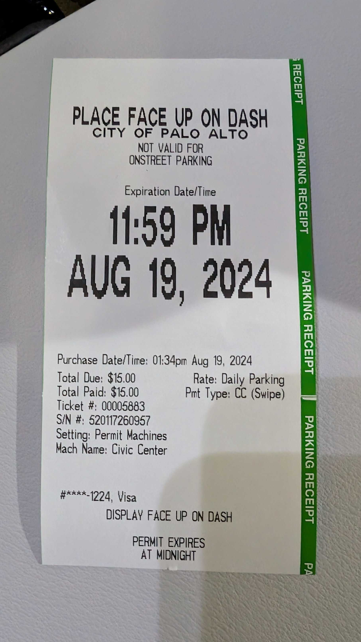

In [108]:
# display the image
from PIL import Image

image_path = "receipt.png"

image = Image.open(image_path)
image.resize((image.width // 5, image.height // 5))

The following code performs OCR on a local image file using Mistral's OCR API, by encoding the image as a base64 data URL, bypassing the need to upload it to a server.



In [110]:
import base64

# Verify image exists locally
image_file = Path("receipt.png")
assert image_file.is_file()

# Encode the image in base64 format, required for API consumption
encoded = base64.b64encode(image_file.read_bytes()).decode()
base64_data_url = f"data:image/jpeg;base64,{encoded}"


# Process the receipt image with OCR using the Mistral OCR model
image_response = client.ocr.process(
    document=ImageURLChunk(image_url=base64_data_url),
    model="mistral-ocr-latest"
)

# Convert the OCR response to a JSON format and print it
response_dict = json.loads(image_response.model_dump_json())
json_string = json.dumps(response_dict, indent=4)
print(json_string)

{
    "pages": [
        {
            "index": 0,
            "markdown": "# PLACE FACE UP ON DASH <br> CITY OF PALO ALTO <br> NOT VALID FOR ONSTREET PARKING \n\nExpiration Date/Time 11:59 PM\n\nAUG 19, 2024\n\nPurchase Date/Time: 01:34pm Aug 19, 2024\nTotal Due: $\\$ 15.00$\nRate: Daily Parking\nTotal Paid: $\\$ 15.00$\nPmt Type: CC (Swipe)\nTicket \\#: 00005883\nS/N \\#: 520117260957\nSetting: Permit Machines\nMach Name: Civic Center\n\\#^^^^-1224, Visa\nDISPLAY FACE UP ON DASH\n\nPERMIT EXPIRES\nAT MIDNIGHT",
            "images": [],
            "dimensions": {
                "dpi": 200,
                "height": 3210,
                "width": 1806
            }
        }
    ],
    "model": "mistral-ocr-2503-completion",
    "usage_info": {
        "pages_processed": 1,
        "doc_size_bytes": 3110191
    }
}


## Extract structured data from OCR results

**OCR results can be further processed using another model.**

Our goal is to extract structured data from these results. To achieve this, we will utilize the pixtral-12b-latest model, supported by our OCR model, to deliver better and higher-quality answers:

This allows you to move from: 📷 image → 🧾 OCR text → 🧠 structured understanding

We want to be able to extract structured data from these files. For this, we will make use of `pixtral-12b-latest` and support it with our OCR model for better, high-quality answers.

The code below is a powerful two-step pipeline that **combines OCR + reasoning** using two different Mistral models:

In [111]:
image_ocr_markdown = image_response.pages[0].markdown

chat_response = client.chat.complete(
    model="pixtral-12b-latest",
    messages=[
        {
            "role": "user",
            "content": [
                ImageURLChunk(image_url=base64_data_url),
                TextChunk(text=f"This is image's OCR in markdown:\n<BEGIN_IMAGE_OCR>\n{image_ocr_markdown}\n<END_IMAGE_OCR>.\nConvert this into a sensible structured json response. The output should be strictly be json with no extra commentary")
            ],
        },
    ],
    response_format =  {"type": "json_object"},
    temperature=0
)

response_dict = json.loads(chat_response.choices[0].message.content)
json_string = json.dumps(response_dict, indent=4)
print(json_string)

{
    "parking_receipt": {
        "header": {
            "instructions": "PLACE FACE UP ON DASH",
            "city": "CITY OF PALO ALTO",
            "validity": "NOT VALID FOR ONSTREET PARKING"
        },
        "expiration": {
            "date_time": "11:59 PM",
            "date": "AUG 19, 2024"
        },
        "purchase": {
            "date_time": "01:34pm Aug 19, 2024"
        },
        "payment": {
            "total_due": "$15.00",
            "rate": "Daily Parking",
            "total_paid": "$15.00",
            "payment_type": "CC (Swipe)"
        },
        "details": {
            "ticket_number": "00005883",
            "serial_number": "520117260957",
            "setting": "Permit Machines",
            "machine_name": "Civic Center"
        },
        "footer": {
            "card_number": "#^^^^-1224",
            "card_type": "Visa",
            "instructions": "DISPLAY FACE UP ON DASH",
            "expiration_reminder": "PERMIT EXPIRES AT MIDNIGHT"
      

## Passing the OCR output into an LLM

Note: We are leveraging a model already capable of vision tasks. However, we could also use text-only models for the structured output.

In [107]:
# The goal is to use Mistral OCR to extract raw Markdown from an image.
# Then use Pixtral 12B (LLM) to interpret and restructure that Markdown into clean, structured JSON.

image_ocr_markdown = image_response.pages[0].markdown

chat_response = client.chat.complete(
    model="ministral-8b-latest",
    messages=[
        {
            "role": "user",
            "content": f"This is image's OCR in markdown:\n<BEGIN_IMAGE_OCR>\n{image_ocr_markdown}\n<END_IMAGE_OCR>.\nConvert this into a sensible structured json response. The output should be strictly be json with no extra commentary"
        },
    ],
    response_format =  {"type": "json_object"},
    temperature=0
)

response_dict = json.loads(chat_response.choices[0].message.content)
json_string = json.dumps(response_dict, indent=4)
print(json_string)

{
    "expiration_date_time": "11:59 PM",
    "expiration_date": "AUG 19, 2024",
    "purchase_date_time": "01:34pm Aug 19, 2024",
    "total_due": 15.0,
    "rate": "Daily Parking",
    "total_paid": 15.0,
    "payment_type": "CC (Swipe)",
    "ticket_number": "00005883",
    "serial_number": "520117260957",
    "setting": "Permit Machines",
    "machine_name": "Civic Center",
    "card_number": "*****-1224",
    "card_type": "Visa"
}


## All Together - Mistral OCR + Custom Structured Output
Overall, this integrated approach not only extracts text from visual data but also organizes the extracted information into a machine-readable format, making it more useful for further processing, analysis, or storage.

Let's design a simple function that takes an image_path file and returns a JSON structured output in a specific format. In this case, we arbitrarily decided we wanted an output respecting the following:

```python
class StructuredOCR:
    file_name: str  # can be any string
    topics: list[str]  # must be a list of strings
    languages: list[Language]  # a list of languages
    ocr_contents: dict  # any dictionary, can be freely defined by the model
```

We will make use of [custom structured outputs](https://docs.mistral.ai/capabilities/structured-output/custom_structured_output/) as well as `pycountry` for the languages.

In [70]:
# Install the Mistral Python SDK
!pip install pycountry

NB: **pycountry** is a useful package when you're dealing with structured data extraction (like from OCR!) and want to match or normalize country names or codes.

In [71]:
from enum import Enum
from pathlib import Path
from pydantic import BaseModel
import base64
import pycountry

# Create a dictionary called languages that maps ISO 639-1 two-letter language codes
languages = {lang.alpha_2: lang.name for lang in pycountry.languages if hasattr(lang, 'alpha_2')}

The imports are:

- Enum: For creating a custom list of values (like supported languages).

- Path: Used for file path operations (more modern than using raw strings).

- BaseModel: From pydantic, to define structured data models with validation.

- base64: Encodes image data for sending via API.

- pycountry: Provides ISO standard data for countries/languages.

In [72]:
# Dynamic Enum Creation with Metaclass
class LanguageMeta(Enum.__class__):
    # dynamically add enum members using the languages dictionary from pycountry
    def __new__(metacls, cls, bases, classdict):
        for code, name in languages.items():
            classdict[name.upper().replace(' ', '_')] = name
        return super().__new__(metacls, cls, bases, classdict)

# Create the Language Enum Using the Metaclass
class Language(Enum, metaclass=LanguageMeta):
    pass

# Define the Pydantic Model: StructuredOCR
class StructuredOCR(BaseModel):
    file_name: str
    topics: list[str]
    languages: list[Language]
    ocr_contents: dict

print(json.dumps(StructuredOCR.model_json_schema(), indent=2))

def structured_ocr(image_path: str) -> StructuredOCR:
# Define the path to the downloaded PDF
    image_file = Path(image_path)
    assert image_file.is_file(), "verify if the file exists."

    # Read and encode the image file
    encoded_image = base64.b64encode(image_file.read_bytes()).decode()
    base64_data_url = f"data:image/jpeg;base64,{encoded_image}"

    # Process the image using OCR
    image_response = client.ocr.process(document=ImageURLChunk(image_url=base64_data_url), model="mistral-ocr-latest")
    image_ocr_markdown = image_response.pages[0].markdown

    # Parse the OCR result into a structured JSON response
    chat_response = client.chat.parse(
        model="pixtral-12b-latest",
        messages=[
            {
                "role": "user",
                "content": [
                    ImageURLChunk(image_url=base64_data_url),
                    TextChunk(text=(
                        "This is the image's OCR in markdown:\n"
                        f"<BEGIN_IMAGE_OCR>\n{image_ocr_markdown}\n<END_IMAGE_OCR>.\n"
                        "Convert this into a structured JSON response with the OCR contents in a sensible dictionnary."
                    ))
                ],
            },
        ],
        response_format=StructuredOCR,
        temperature=0   # ensures deterministic output (important for parsing).
    )

    return chat_response.choices[0].message.parsed

{
  "$defs": {
    "Language": {
      "enum": [
        "Afar",
        "Abkhazian",
        "Afrikaans",
        "Akan",
        "Amharic",
        "Arabic",
        "Aragonese",
        "Assamese",
        "Avaric",
        "Avestan",
        "Aymara",
        "Azerbaijani",
        "Bashkir",
        "Bambara",
        "Belarusian",
        "Bengali",
        "Bislama",
        "Tibetan",
        "Bosnian",
        "Breton",
        "Bulgarian",
        "Catalan",
        "Czech",
        "Chamorro",
        "Chechen",
        "Church Slavic",
        "Chuvash",
        "Cornish",
        "Corsican",
        "Cree",
        "Welsh",
        "Danish",
        "German",
        "Dhivehi",
        "Dzongkha",
        "Modern Greek (1453-)",
        "English",
        "Esperanto",
        "Estonian",
        "Basque",
        "Ewe",
        "Faroese",
        "Persian",
        "Fijian",
        "Finnish",
        "French",
        "Western Frisian",
        "Fulah",
        "Scottish 

We can now extract structured output from any image parsed with our OCR model.

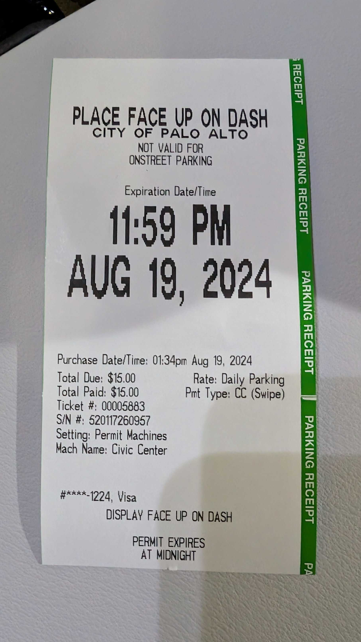

In [73]:
# display the image to OCR
from PIL import Image

image_path = "receipt.png"

image = Image.open(image_path)
image.resize((image.width // 5, image.height // 5))

In [74]:
# file to ocr
image_path = "receipt.png"
# Runs OCR + structuring on an image
structured_response = structured_ocr(image_path)

# Converts the result to a JSON string - a dictionary
response_dict = json.loads(structured_response.model_dump_json())

# Formats it with indentation
json_string = json.dumps(response_dict, indent=4)

print(json_string)

{
    "file_name": "parking_receipt",
    "topics": [
        "parking",
        "receipt",
        "expiration",
        "payment"
    ],
    "languages": [
        "English"
    ],
    "ocr_contents": {
        "header": "PLACE FACE UP ON DASH",
        "city": "CITY OF PALO ALTO",
        "validity": "NOT VALID FOR ONSTREET PARKING",
        "expiration": {
            "date": "AUG 19, 2024",
            "time": "11:59 PM"
        },
        "purchase": {
            "date": "Aug 19, 2024",
            "time": "01:34pm"
        },
        "total_due": "$15.00",
        "rate": "Daily Parking",
        "total_paid": "$15.00",
        "payment_type": "CC (Swipe)",
        "ticket_number": "00005883",
        "serial_number": "520117260957",
        "setting": "Permit Machines",
        "machine_name": "Civic Center",
        "card_info": "#*****-1224, Visa",
        "instructions": "DISPLAY FACE UP ON DASH",
        "expiry_message": "PERMIT EXPIRES AT MIDNIGHT"
    }
}


# Additional Tests - Pictures

## Medical Handwritten Prescription


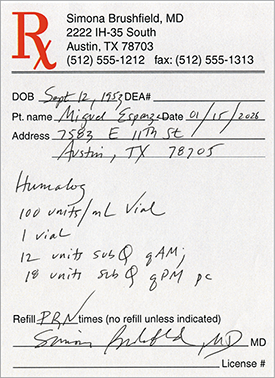

In [75]:
# file to ocr: handwritten medical prescription
image_path = "/content/Medical_Prescription.png"
image = Image.open(image_path)
image

In [76]:
structured_response = structured_ocr(image_path)

response_dict = json.loads(structured_response.model_dump_json())
json_string = json.dumps(response_dict, indent=4)
print(json_string)

{
    "file_name": "medical_prescription",
    "topics": [
        "medical prescription",
        "doctor's note",
        "patient information",
        "medication details"
    ],
    "languages": [
        "English"
    ],
    "ocr_contents": {
        "doctor_info": {
            "name": "Simon Bruehfield, MD",
            "address": "2222 IH-35 South",
            "city": "Austin, TX",
            "zip_code": "78703",
            "phone": "(512) 555-1212",
            "fax": "(512) 555-1313"
        },
        "patient_info": {
            "dob": "Sept 12, 1953",
            "dea_number": "DEA#",
            "patient_name": "Atipid EygmpsDate 01/1C/2005",
            "patient_address": "7585 E 11th St.",
            "patient_city": "Austin, TX",
            "patient_zip": "78205"
        },
        "medication_details": {
            "medication": "Hemodig",
            "dosage": "100 unit/ml Vial",
            "quantity": "1 vial",
            "instructions": "12 unit sub Q 9AM;

The code below takes a structured OCR result in JSON format and converts it into a nicely formatted, readable Markdown output.  Suitable for displaying in a Jupyter Notebook, especially when dealing with right-to-left (RTL) languages (like Arabic or Hebrew) from OCR output.

In [77]:

import json
from IPython.display import Markdown, display # Used to render rich Markdown output

# function helper from json to markdown
def json_to_markdown(json_data):
    """
    Transforms a JSON object into a Markdown string, decoding ocr_contents.

    Args:
        json_data: A JSON object (dict or list).

    Returns:
        A Markdown string representation of the JSON data.
    """

    # This inner function handles various data types in the JSON:
    def _format_value(value):
        if isinstance(value, dict):
            return json_to_markdown(value)  # Recursive call for nested objects
        elif isinstance(value, list):
            return "- " + "\n- ".join(_format_value(item) for item in value)
        elif isinstance(value, str):
            # Decode the string if it represents ocr_contents; Strings with potential RTL content
            try:
                decoded_value = value.encode('latin-1').decode('utf-8')  # Decode from latin-1 to utf-8
                return f'<div dir="rtl">{decoded_value}</div>'
            except UnicodeEncodeError:
                # If decoding fails, return the original string
                return value
        else:
            # Other types (numbers, booleans):
            return str(value)

    if isinstance(json_data, dict):
        markdown = ""
        for key, value in json_data.items():
            markdown += f"**{key}:** {_format_value(value)}\n"
        return markdown
    elif isinstance(json_data, list):
        return "- " + "\n- ".join(_format_value(item) for item in json_data)
    else:
        return str(json_data)

# Get the JSON output (assuming you have structured_response) convert it into a Python dic
response_dict = json.loads(structured_response.model_dump_json())

# Calls json_to_markdown() to generate a Markdown string.
markdown_output = json_to_markdown(response_dict)

# Displays it inside your notebook using IPython.display
display(Markdown(markdown_output))

**file_name:** <div dir="rtl">medical_prescription</div>
**topics:** - <div dir="rtl">medical prescription</div>
- <div dir="rtl">doctor's note</div>
- <div dir="rtl">patient information</div>
- <div dir="rtl">medication details</div>
**languages:** - <div dir="rtl">English</div>
**ocr_contents:** **doctor_info:** **name:** <div dir="rtl">Simon Bruehfield, MD</div>
**address:** <div dir="rtl">2222 IH-35 South</div>
**city:** <div dir="rtl">Austin, TX</div>
**zip_code:** <div dir="rtl">78703</div>
**phone:** <div dir="rtl">(512) 555-1212</div>
**fax:** <div dir="rtl">(512) 555-1313</div>

**patient_info:** **dob:** <div dir="rtl">Sept 12, 1953</div>
**dea_number:** <div dir="rtl">DEA#</div>
**patient_name:** <div dir="rtl">Atipid EygmpsDate 01/1C/2005</div>
**patient_address:** <div dir="rtl">7585 E 11th St.</div>
**patient_city:** <div dir="rtl">Austin, TX</div>
**patient_zip:** <div dir="rtl">78205</div>

**medication_details:** **medication:** <div dir="rtl">Hemodig</div>
**dosage:** <div dir="rtl">100 unit/ml Vial</div>
**quantity:** <div dir="rtl">1 vial</div>
**instructions:** <div dir="rtl">12 unit sub Q 9AM; 18 unit sub Q 9PM pc</div>

**refill_info:** <div dir="rtl">Refill PBXtimes (no refill unless indicated)</div>



## Picture File: Vietnamese Language

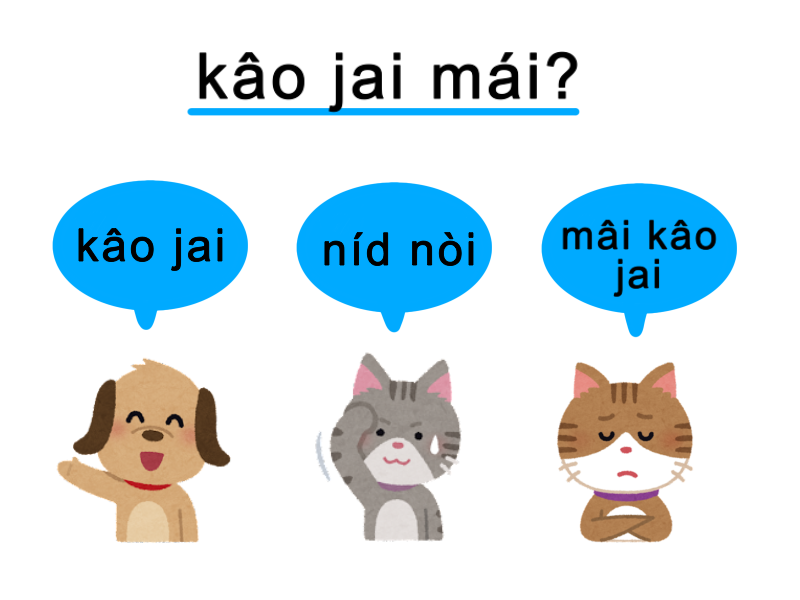

In [78]:
image_path = "/content/vietnamese-learning.png"
image = Image.open(image_path)
image

NB: The image shows:

The phrase "kâo jai mái?" (Thai: เข้าใจไหม?) which means "Do you understand?"

Three cartoon characters replying:

🐶 Dog: "kâo jai" (เข้าใจ) → “I understand”

🐱 Cat (middle): "níd nòi" (นิดหน่อย) → “A little bit”

🐱 Cat (right): "mâi kâo jai" (ไม่เข้าใจ) → “I don’t understand”



In [79]:
structured_response = structured_ocr(image_path) # Or your image path
response_dict = json.loads(structured_response.model_dump_json()) # Assuming you have a structured_ocr function
json_string = json.dumps(response_dict, indent=4) # Corrected to use model_dump_json
print(json_string)

{
    "file_name": "img-0.jpeg",
    "topics": [
        "OCR",
        "Image Recognition",
        "Text Extraction"
    ],
    "languages": [
        "Vietnamese"
    ],
    "ocr_contents": {
        "text": "# k\u00e2o jai m\u00e1i?\n\n## k\u00e2o jai\n\nn\u00edd n\u00f2j\nm\u00e3i k\u00e2o jai\n![img-0.jpeg](img-0.jpeg)"
    }
}


In [80]:
def format_vietnamese_phrases(response_dict): # changed to resonse_dict
    """
    Format and display Vietnamese phrases from the provided JSON dictionary.

    Args:
        response_dict (dict): Dictionary containing Vietnamese phrase data.

    Returns:
        str: Formatted string with Vietnamese phrases and their meanings.
    """
    output = []

    # Extract main text and options
    main_text = response_dict.get("ocr_contents", {}).get("text", "") # changed to resonse_dict

    # Add main text
    output.append(main_text)
    output.append("")  # Add an empty line

    return "\n".join(output)

In [81]:
image_path = "/content/vietnamese-learning.png"  # Or your image path
structured_response = structured_ocr(image_path) # Assuming you have a structured_ocr function
response_dict = json.loads(structured_response.model_dump_json())  # Corrected to use model_dump_json
formatted_output = format_vietnamese_phrases(response_dict)
print(formatted_output)

# kâo jai mái?

## kâo jai

níd nòj
mãi kâo jai
![img-0.jpeg](img-0.jpeg)



## Picture File: Nasdaq


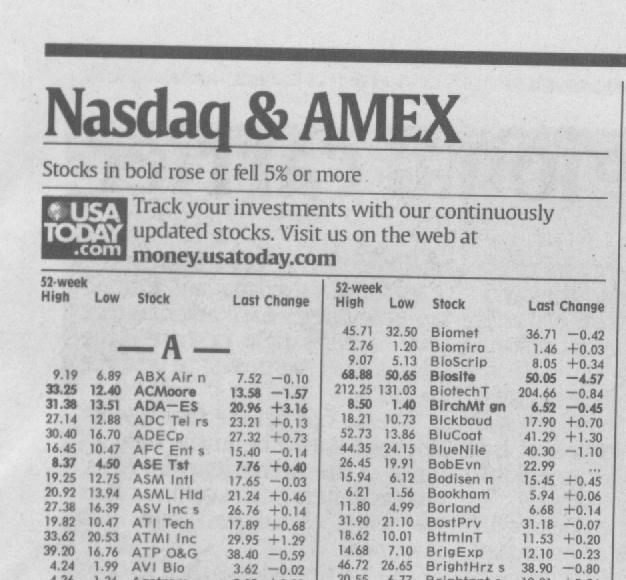

In [82]:
image_path = "/content/stock_gs200.jpg"
image = Image.open(image_path)
image

In [83]:
structured_response = structured_ocr(image_path)

response_dict = json.loads(structured_response.model_dump_json())
json_string = json.dumps(response_dict, indent=4)
print(json_string)

{
    "file_name": "Nasdaq_AMEX_Stocks",
    "topics": [
        "Stock Market",
        "Nasdaq",
        "AMEX",
        "Financial News"
    ],
    "languages": [
        "English"
    ],
    "ocr_contents": {
        "header": "Nasdaq & AMEX",
        "subheader": "Stocks in bold rose or fell 5% or more",
        "image_credit": "USA TODAY",
        "website": "money.usatoday.com",
        "stock_data": [
            {
                "stock": "ABX Air Inc",
                "high": 9.19,
                "low": 6.89,
                "last_change": -0.1
            },
            {
                "stock": "ACMeeee",
                "high": 33.25,
                "low": 12.4,
                "last_change": 1.57
            },
            {
                "stock": "ADA-ES",
                "high": 31.38,
                "low": 13.31,
                "last_change": 3.16
            },
            {
                "stock": "ADC Tel rs",
                "high": 27.14,
                "

In [84]:
import json

def json_to_markdown(json_data):
  """
  Transforms a JSON object into a Markdown string.

  Args:
    json_data: A JSON object (dict or list).

  Returns:
    A Markdown string representation of the JSON data.
  """

  def _format_value(value):
    if isinstance(value, dict):
      return json_to_markdown(value)  # Recursive call for nested objects
    elif isinstance(value, list):
      return "- " + "\n- ".join(_format_value(item) for item in value)
    else:
      return str(value)

  if isinstance(json_data, dict):
    markdown = ""
    for key, value in json_data.items():
      markdown += f"**{key}:** {_format_value(value)}\n"
    return markdown
  elif isinstance(json_data, list):
    return "- " + "\n- ".join(_format_value(item) for item in json_data)
  else:
    return str(json_data)

# Get the JSON output
structured_response = structured_ocr(image_path)
response_dict = json.loads(structured_response.model_dump_json())

# Convert JSON to Markdown
markdown_output = json_to_markdown(response_dict)

# Display the Markdown
from IPython.display import Markdown
display(Markdown(markdown_output))

**file_name:** Nasdaq_AMEX_Stocks
**topics:** - Stock Market
- Nasdaq
- AMEX
- Financial News
**languages:** - English
**ocr_contents:** **title:** Nasdaq & AMEX
**description:** Stocks in bold rose or fell 5% or more
**image_url:** img-0.jpeg
**stock_data:** - **symbol:** ABX
**high:** 9.19
**low:** 6.89
**stock:** Air n
**last_change:** -0.1

- **symbol:** ACMO
**high:** 33.25
**low:** 12.4
**stock:** ACMeee
**last_change:** -1.57

- **symbol:** ADA-ES
**high:** 31.38
**low:** 13.31
**stock:** ADA-ES
**last_change:** -3.16

- **symbol:** ADC Tel rs
**high:** 27.14
**low:** 12.88
**stock:** ADC Tel rs
**last_change:** 23.31

- **symbol:** ADEC
**high:** 30.4
**low:** 16.7
**stock:** ADEC
**last_change:** -0.73

- **symbol:** AFC Ent s
**high:** 16.45
**low:** 10.47
**stock:** AFC Ent s
**last_change:** -0.14

- **symbol:** ASE Tst
**high:** 8.37
**low:** 4.9
**stock:** ASE Tst
**last_change:** 7.76

- **symbol:** ASM Intl
**high:** 19.25
**low:** 12.75
**stock:** ASM Intl
**last_change:** -0.63

- **symbol:** ASML Hld
**high:** 20.92
**low:** 13.94
**stock:** ASML Hld
**last_change:** 21.24

- **symbol:** ASV Inc s
**high:** 27.38
**low:** 16.39
**stock:** ASV Inc s
**last_change:** 26.76

- **symbol:** ATI Tech
**high:** 19.82
**low:** 10.47
**stock:** ATI Tech
**last_change:** 17.89

- **symbol:** ATMI Inc
**high:** 33.62
**low:** 20.53
**stock:** ATMI Inc
**last_change:** 29.95

- **symbol:** ATP O&G
**high:** 39.2
**low:** 16.76
**stock:** ATP O&G
**last_change:** 38.4

- **symbol:** AVI Bio
**high:** 4.24
**low:** 1.99
**stock:** AVI Bio
**last_change:** 3.62

- **symbol:** Biomet
**high:** 45.71
**low:** 32.5
**stock:** Biomet
**last_change:** -0.42

- **symbol:** Biomiro
**high:** 2.76
**low:** 1.2
**stock:** Biomiro
**last_change:** 1.46

- **symbol:** Bioscrip
**high:** 5.13
**low:** 3.13
**stock:** Bioscrip
**last_change:** 8.05

- **symbol:** Biosite
**high:** 68.08
**low:** 55.0
**stock:** Biosite
**last_change:** -0.57

- **symbol:** BirchMT
**high:** 8.5
**low:** 5.8
**stock:** BirchMT
**last_change:** 20.66

- **symbol:** Bickboud
**high:** 18.21
**low:** 10.73
**stock:** Bickboud
**last_change:** 17.9

- **symbol:** BlucCoat
**high:** 52.73
**low:** 13.86
**stock:** BlucCoat
**last_change:** 41.29

- **symbol:** BlueNile
**high:** 44.35
**low:** 24.15
**stock:** BlueNile
**last_change:** 40.3

- **symbol:** BobEvn
**high:** 26.45
**low:** 19.91
**stock:** BobEvn
**last_change:** 22.99

- **symbol:** Bodisen n
**high:** 15.94
**low:** 6.12
**stock:** Bodisen n
**last_change:** 15.45

- **symbol:** Bookham
**high:** 11.8
**low:** 4.99
**stock:** Bookham
**last_change:** 5.94

- **symbol:** Bortland
**high:** 31.9
**low:** 21.1
**stock:** Bortland
**last_change:** 6.68

- **symbol:** BostPrv
**high:** 18.62
**low:** 10.01
**stock:** BostPrv
**last_change:** 31.18

- **symbol:** BftmInt
**high:** 14.68
**low:** 7.1
**stock:** BftmInt
**last_change:** 11.53

- **symbol:** BrigExp
**high:** 12.1
**low:** 4.67
**stock:** BrigExp
**last_change:** 12.1

- **symbol:** BrightHrz s
**high:** 38.9
**low:** 26.65
**stock:** BrightHrz s
**last_change:** -0.88




## Picture File : Arabic

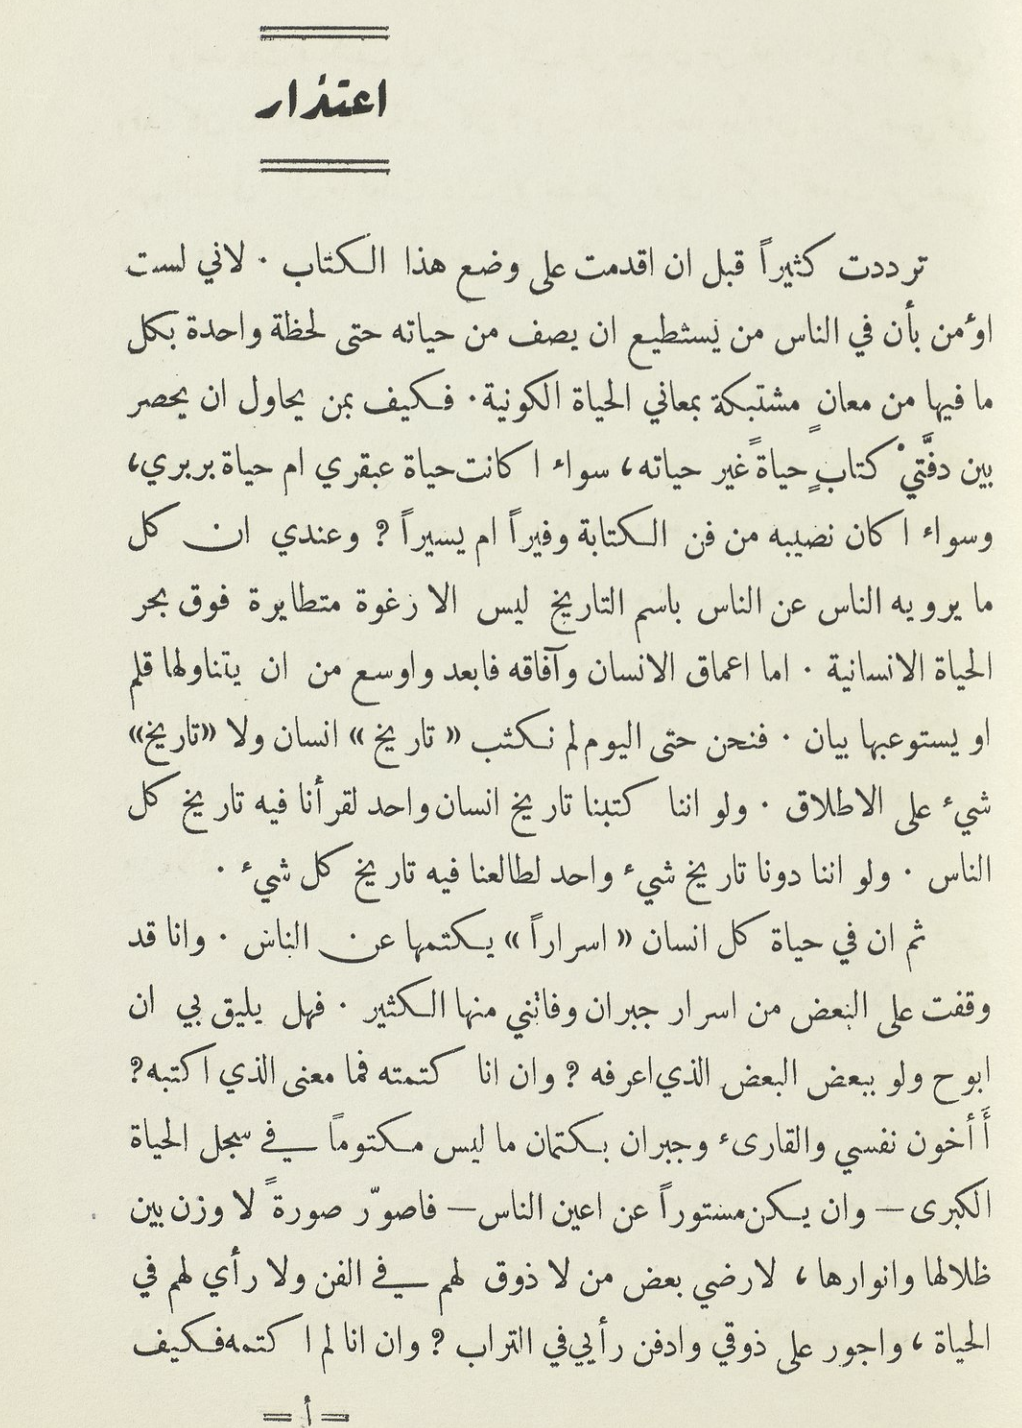

In [85]:
image_path = "/content/arabic_text.png"
image = Image.open(image_path)
image

NB: The text is poetic, reflective, and philosophical.

It discusses the impossibility of capturing a life fully in writing, the value of personal secrets, and the struggles of authorship.

It references Gibran, likely Kahlil Gibran, suggesting this is an introduction to a book about or inspired by him.

**Kahlil Gibran** was a Lebanese-American writer, poet, and visual artist, best known for his 1923 book The Prophet. Born in 1883 in Bsharri, Lebanon, he immigrated to the United States in 1895. The Prophet is a collection of philosophical essays exploring themes like love, freedom, and spirituality, written in a lyrical prose style. His works often blend Eastern mysticism with Western humanism, reflecting his dual cultural influences. Gibran’s writing and art have been widely translated and continue to inspire readers globally, establishing him as a significant figure in literature and spirituality.

In [86]:
structured_response = structured_ocr(image_path)

response_dict = json.loads(structured_response.model_dump_json())
json_string = json.dumps(response_dict, indent=4)
print(json_string)

{
    "file_name": "image_ocr",
    "topics": [
        "OCR",
        "Life",
        "Writing",
        "History",
        "Secrets"
    ],
    "languages": [
        "Arabic"
    ],
    "ocr_contents": {
        "text": "\u062a\u0631\u062f\u062f\u062a \u0643\u062b\u064a\u0631\u0627\u064b \u0642\u0628\u0644 \u0627\u0646 \u0627\u0642\u062f\u0645\u062a \u0639\u0644\u0649 \u0648\u0636\u0639 \u0647\u0630\u0627 \u0627\u0644\u0643\u062a\u0627\u0628. \u0644\u0627\u0646\u064a \u0644\u0633\u062a \u0627\u0648 \u0645\u0646 \u0628\u0623\u0646 \u0641\u064a \u0627\u0644\u0646\u0627\u0633 \u0645\u0646 \u064a\u0633\u062a\u0637\u064a\u0639 \u0627\u0646 \u0648\u0635\u0641 \u0645\u0646 \u062d\u064a\u0627\u062a\u0647 \u062d\u062a\u0649 \u0644\u062d\u0638\u0629 \u0648\u0627\u062d\u062f\u0629 \u0643\u0644 \u0645\u0627 \u0641\u064a\u0647\u0627 \u0645\u0646 \u0645\u0639\u0627\u0646\u064d \u0645\u0634\u062a\u0628\u0643\u0629 \u0628\u0639\u0645\u0644\u064a \u0627\u0644\u062d\u064a\u0627\u0629 \u0627\u0644\u06

NB: The `"ocr_contents": { "text": ... }` from your JSON contains ASCII-encoded Unicode escape sequences — like \u062a\u0631\u062f\u062f\u062a — which represent Arabic characters encoded as Unicode.**bold text**

In [87]:
import json
from IPython.display import Markdown, display

def json_to_markdown(json_data):
    """
    Transforms a JSON object into a Markdown string, decoding ocr_contents.

    Args:
        json_data: A JSON object (dict or list).

    Returns:
        A Markdown string representation of the JSON data.
    """

    def _format_value(value):
        if isinstance(value, dict):
            return json_to_markdown(value)  # Recursive call for nested objects
        elif isinstance(value, list):
            return "- " + "\n- ".join(_format_value(item) for item in value)
        elif isinstance(value, str):
            # Decode the string if it represents ocr_contents
            try:
                decoded_value = value.encode('latin-1').decode('utf-8')  # Decode from latin-1 to utf-8
                return f'<div dir="rtl">{decoded_value}</div>'
            except UnicodeEncodeError:
                # If decoding fails, return the original string
                return value
        else:
            return str(value)

    if isinstance(json_data, dict):
        markdown = ""
        for key, value in json_data.items():
            markdown += f"**{key}:** {_format_value(value)}\n"
        return markdown
    elif isinstance(json_data, list):
        return "- " + "\n- ".join(_format_value(item) for item in json_data)
    else:
        return str(json_data)

# Get the JSON output (assuming you have structured_response)
response_dict = json.loads(structured_response.model_dump_json())

# Convert JSON to Markdown, decoding ocr_contents
markdown_output = json_to_markdown(response_dict)
display(Markdown(markdown_output))

**file_name:** <div dir="rtl">image_ocr</div>
**topics:** - <div dir="rtl">OCR</div>
- <div dir="rtl">Life</div>
- <div dir="rtl">Writing</div>
- <div dir="rtl">History</div>
- <div dir="rtl">Secrets</div>
**languages:** - <div dir="rtl">Arabic</div>
**ocr_contents:** **text:** ترددت كثيراً قبل ان اقدمت على وضع هذا الكتاب. لاني لست او من بأن في الناس من يستطيع ان وصف من حياته حتى لحظة واحدة كل ما فيها من معانٍ مشتبكة بعملي الحياة الكونية. فكيف من tenta ان يحصر بين دفَّتَي كتاب حياةً غير حياته، سواء ا كانت حياة عبقري ام حياة بربري، وسواء ا كان نصيبه من فن الكتابة وفيراً ام يسيراً؟ وعندي ان كل ما يرويه الناس عن الناس باسم التاريخ ليس الا زغوة متطايرة فوق بحر الحياة الانسانية. اما اعماق الانسان وآفاقه فابعد واوسع من ان يتناولها قلم او يستوعبها بيان. فنحن حتى اليوم لم نكتب "تاريخ " انسان ولا "تاريخ" شيء على الاطلاق. ولو اننا كتبنا تاريخ انسان واحد لقرأنا فيه تاريخ كل الناس. ولو اننا دونا تاريخ شيء واحد لطالعتا فيه تاريخ كل شيء. ثم ان في حياة كل انسان "اسراراً " يسكنمها عن الناس. وانا قد وقفت على بعض من اسرار جبران وفانني منها الكثير. فهل يليق بي ان ايوح ولو ببعض البعض الذي اعرفه؟ وان انا كتمته فما معنى الذي اكتبه؟ اخون نفسي والقارىء وجبران بكنتيان ما ليس مكنوماً بجدّ مبجل الحياة الكبرى - وان يمكن مستوراً عن اعين الناس - فاصôr صورةً لا وزن بين ظلالها وانوارها، لارضي بعض من لا ذوق لهم بجدّ الفن ولا رأي لهم في الحياة، واجور على ذوقي وادفن رأيي في الثراب؟ وان انا لم اكتبه فكيف



NB: This is beautifully formatted Arabic philosophical writing — poetic, introspective, and reflective — likely an introduction or preface to a book about life, creativity, and Khalil Gibran's private thoughts.

You can now:

Display this in right-to-left Markdown or HTML

Add it to your structured JSON model under ocr_contents.text

Translate it (already done earlier)

Export it to PDF, EPUB, or use it for a learning project

In [88]:
print(json.dumps(response_dict, indent=2, ensure_ascii=False))


{
  "file_name": "image_ocr",
  "topics": [
    "OCR",
    "Life",
    "Writing",
    "History",
    "Secrets"
  ],
  "languages": [
    "Arabic"
  ],
  "ocr_contents": {
    "text": "ترددت كثيراً قبل ان اقدمت على وضع هذا الكتاب. لاني لست او من بأن في الناس من يستطيع ان وصف من حياته حتى لحظة واحدة كل ما فيها من معانٍ مشتبكة بعملي الحياة الكونية. فكيف من tenta ان يحصر بين دفَّتَي كتاب حياةً غير حياته، سواء ا كانت حياة عبقري ام حياة بربري، وسواء ا كان نصيبه من فن الكتابة وفيراً ام يسيراً؟ وعندي ان كل ما يرويه الناس عن الناس باسم التاريخ ليس الا زغوة متطايرة فوق بحر الحياة الانسانية. اما اعماق الانسان وآفاقه فابعد واوسع من ان يتناولها قلم او يستوعبها بيان. فنحن حتى اليوم لم نكتب \"تاريخ \" انسان ولا \"تاريخ\" شيء على الاطلاق. ولو اننا كتبنا تاريخ انسان واحد لقرأنا فيه تاريخ كل الناس. ولو اننا دونا تاريخ شيء واحد لطالعتا فيه تاريخ كل شيء. ثم ان في حياة كل انسان \"اسراراً \" يسكنمها عن الناس. وانا قد وقفت على بعض من اسرار جبران وفانني منها الكثير. فهل يليق بي ان ايوح ولو ببعض البعض الذي اعر

In [89]:
!pip install openai

In [90]:
# Your structured OCR dictionary
response_dict = {
    "file_name": "image_ocr",
    "topics": ["OCR", "Life", "Human Experience", "Writing", "History"],
    "languages": ["Arabic"],
    "ocr_contents": {
        "text": "ترددت كثيراً قبل ان اقدمت على وضع هذا الكتاب..."
    }
}


In [91]:
import openai
import os
import textwrap

from google.colab import userdata
from openai import OpenAI

# Set the API key in the environment variable
os.environ['OPENAI_API_KEY'] = userdata.get('OPENAI_API_KEY')

# Initialize the OpenAI client
client = OpenAI()

# Initialize the OpenAI client (assumes API key is set as an environment variable)
client = OpenAI()  # Alternatively: client = OpenAI(api_key="your_api_key_here")

# Your OCR JSON output
ocr_json = {
  "file_name": "image_ocr",
  "topics": [
    "OCR",
    "Life",
    "Human Experience",
    "Writing",
    "History"
  ],
  "languages": [
    "Arabic"
  ],
  "ocr_contents": {
    "text": "ترددت كثيراً قبل ان اقدمت على وضع هذا الكتاب. لاني لست اوَّمن بأن في الناس من يستطيع ان وصف من حياته حتى لحظة واحدة كل ما فيها من معانٍ مشتبكة ومعاني الحياة الكونية. فكيف من tenta ان يحصر بين دفَّتَي كتاب حياةً غير حياته، سواء اكانة حياة عبقري ام حياة بربري، وسواء اكان نصيبه من فن الكتابة وفيراً ام يسيراً؟ وعندي ان كل ما يرويه الناس عن الناس باسم التاريخ ليس الا زغوة متطايرة فوق بحر الحياة الانسانية. اما اعماق الانسان وآفاقه فابعد واوسع من ان يتناولها قلم او يستوعبها بيان. فنحن حتى اليوم لم نكتب \"تاريخ \" انسان ولا \"تاريخ\" شيء على الاطلاق. ولو اننا كتبنا تاريخ انسان واحد لقرأنا فيه تاريخ كل الناس. ولو اننا دونا تاريخ شيء واحد لطالعتا فيه تاريخ كل شيء. ثم ان في حياة كل انسان \"اسراراً \" يسكنمها عن الناس. وانا قد وقفت على بعض من اسرار جبران وفانني منها الكثير. فهل يليق بي ان ايوح ولو ببعض البعض الذي اعرفه؟ وان انا كتمته فما معنى الذي اكتبه؟ اخون نفسي والقارىء وجبران بكنتيان ما ليس مكنوماً بجدّ مبجل الحياة الكبرى - وان يمكن مستوراً عن اعين الناس - فاصôr صورةً لا وزن بين ظلالها وانوارها، لارضي بعض من لا ذوق لهم بجدّ الفن ولا رأي لهم في الحياة، واجور على ذوقي وادفن رأيي في الثراب؟ وان انا لم اكتبه فكيف"
  }
}

# Extract the Arabic text from the JSON
arabic_text = ocr_json["ocr_contents"]["text"]

# Create a clear, strong prompt
translation_prompt = (
    "Translate the following Arabic text into fluent English.\n"
    "Please preserve the full meaning, tone, and paragraph structure.\n"
    "Do not summarize — translate it fully and clearly:\n\n"
    + arabic_text)

# Make the API call to translate the text using GPT-4
response = client.chat.completions.create(
    model="gpt-4",
    messages=[
        {"role": "system", "content": "You are a helpful assistant that translates Arabic to English."},
        {"role": "user", "content": translation_prompt}
    ]
)

# Extract the translated text from the response
translated_text = response.choices[0].message.content
wrapped_text = textwrap.fill(translated_text, width=80)
# Print the English translation
print(wrapped_text)

I hesitated a lot before embarking on writing this book. I do not assume that
there are people who can describe everything from their lives, even for a single
moment, with all its intertwined meanings and cosmic life implications. How can
then someone presume to confine a life other than his own, whether it is the
life of a genius or a barbarian, into the covers of a book, regardless of
whether his share of the writing skill is abundant or meager? I believe that all
that people narrate about people in the name of history is nothing but froth
floating over the sea of human life. The depths and horizons of a person are
farther and broader than a pen can handle or a statement can comprehend. Until
now, we have yet to write the "history" of a person, or the "history" of
anything for that matter. If we wrote the history of a single person, we could
read in it the history of all people, and if we recorded the history of one
thing, we could find within it the history of everything. Besides, i

# Additional Tests - PDFs

In [92]:
from mistralai import DocumentURLChunk, ImageURLChunk, TextChunk, Mistral
import json

In [93]:
import os
from google.colab import userdata

# Get the API key securely from Colab's secret storage
os.environ['MISTRAL_API_KEY'] = userdata.get('MISTRAL_API_KEY')

## Research Paper - DeepSeek GRPO

In [94]:
# Download example PDF and image for OCR processing
!wget https://arxiv.org/pdf/2402.03300

--2025-03-26 21:33:29--  https://arxiv.org/pdf/2402.03300
Resolving arxiv.org (arxiv.org)... 151.101.131.42, 151.101.67.42, 151.101.3.42, ...
Connecting to arxiv.org (arxiv.org)|151.101.131.42|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1844642 (1.8M) [application/pdf]
Saving to: ‘2402.03300’

2402.03300          100%[===================>]   1.76M  --.-KB/s    in 0.007s  

2025-03-26 21:33:29 (242 MB/s) - ‘2402.03300’ saved [1844642/1844642]



In [95]:
import os
# DeepSeek research paper
filename = "2402.03300"
new_filename = filename + ".pdf"

os.rename(filename, new_filename)

In [96]:
from pathlib import Path

# Define the path to the downloaded PDF
pdf_file = Path("/content/2402.03300.pdf")
# Ensure the file exists before proceeding
assert pdf_file.is_file()

{
    "pages": [
        {
            "index": 0,
            "markdown": "# DeepSeekMath: Pushing the Limits of Mathematical Reasoning in Open Language Models \n\nZhihong Shao ${ }^{1,2 * \\dagger}$, Peiyi Wang ${ }^{1,3 * \\dagger}$, Qihao Zhu ${ }^{1,3 * \\dagger}$, Runxin Xu ${ }^{1}$, Junxiao Song ${ }^{1}$<br>Xiao Bi ${ }^{1}$, Haowei Zhang ${ }^{1}$, Mingchuan Zhang ${ }^{1}$, Y.K. Li ${ }^{1}$, Y. Wu ${ }^{1}$, Daya Guo ${ }^{1 *}$<br>${ }^{1}$ DeepSeek-AI, ${ }^{2}$ Tsinghua University, ${ }^{3}$ Peking University<br>\\{zhihongshao, wangpeiyi, zhuqh, guoday\\}@deepseek.com<br>https://github.com/deepseek-ai/DeepSeek-Math\n\n\n#### Abstract\n\nMathematical reasoning poses a significant challenge for language models due to its complex and structured nature. In this paper, we introduce DeepSeekMath 7B, which continues pretraining DeepSeek-Coder-Base-v1.5 7B with 120B math-related tokens sourced from Common Crawl, together with natural language and code data. DeepSeekMath 7B has a
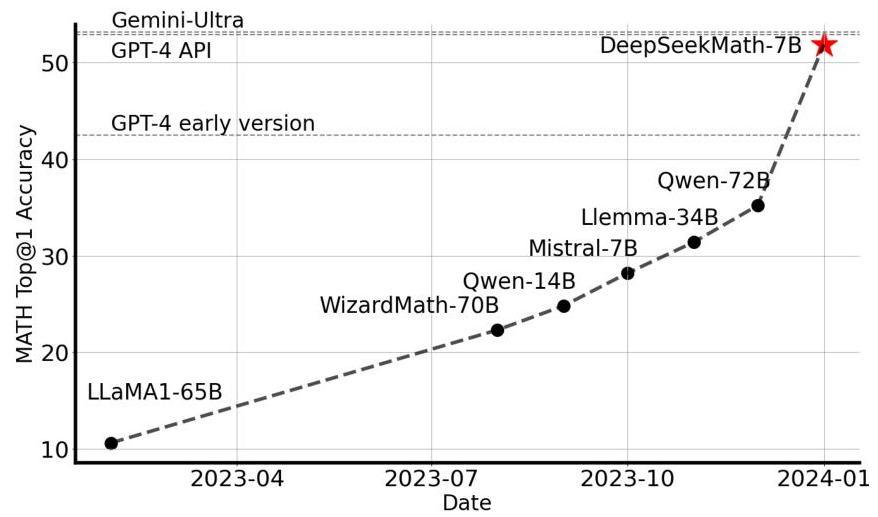
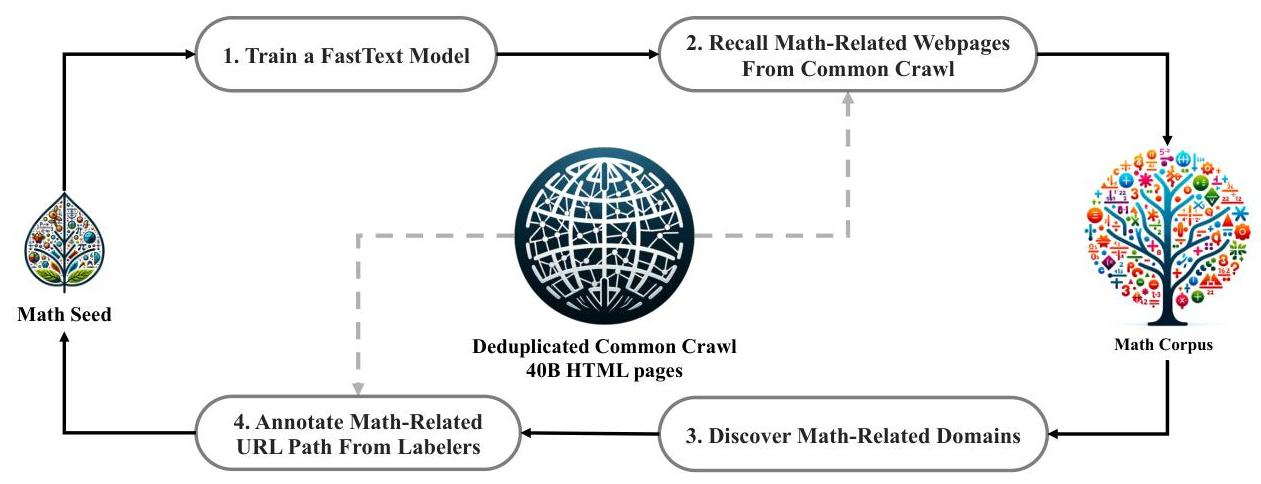
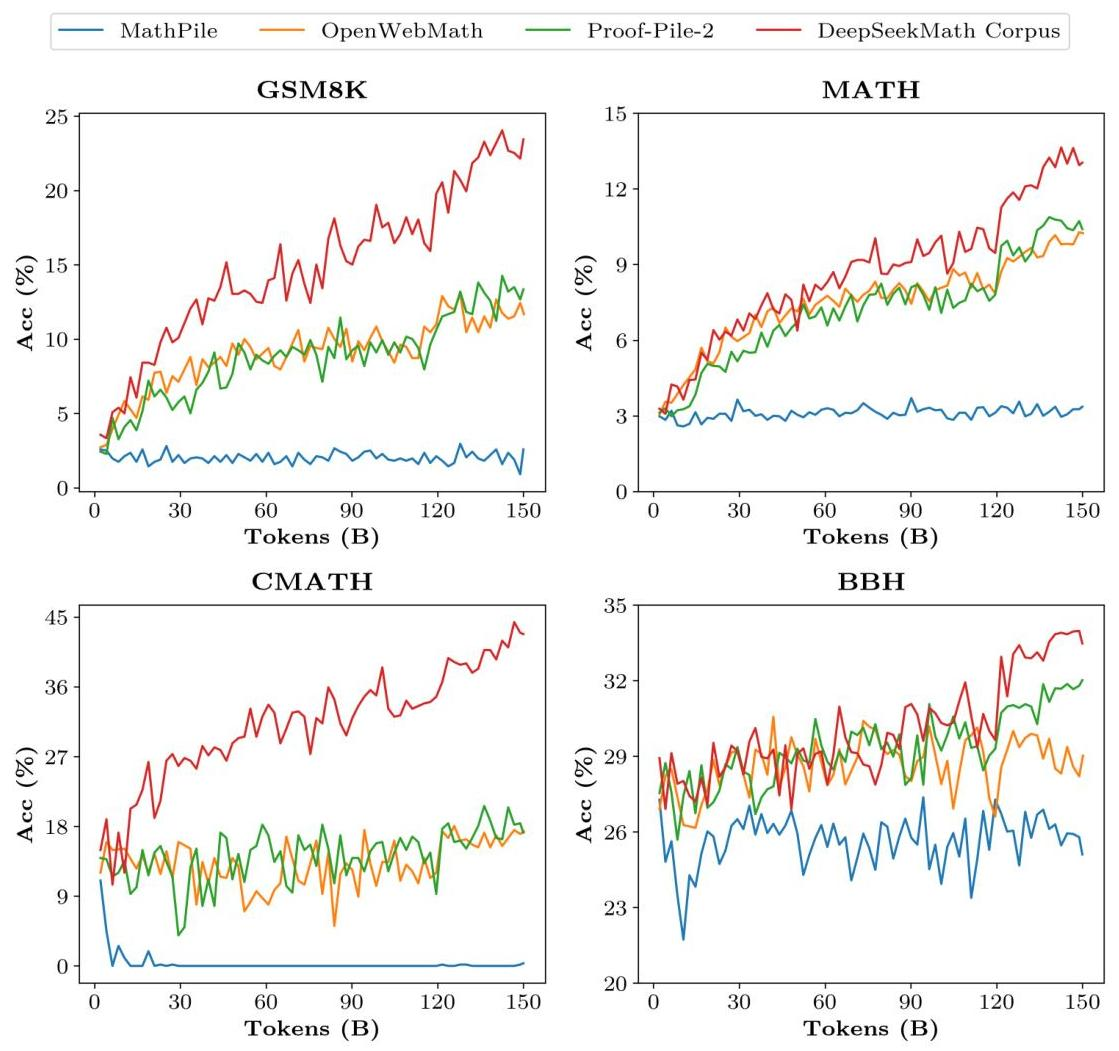
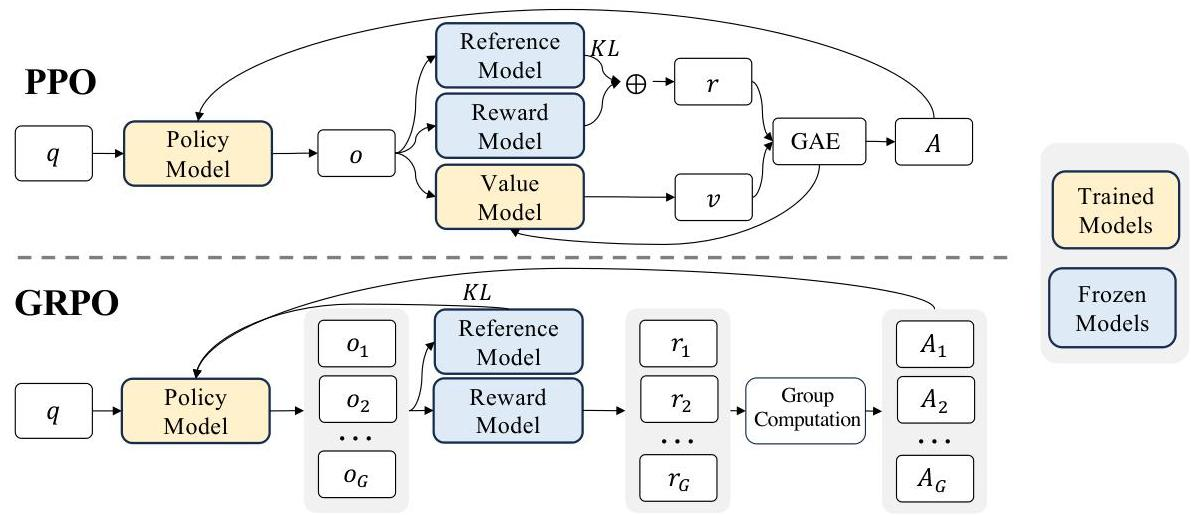
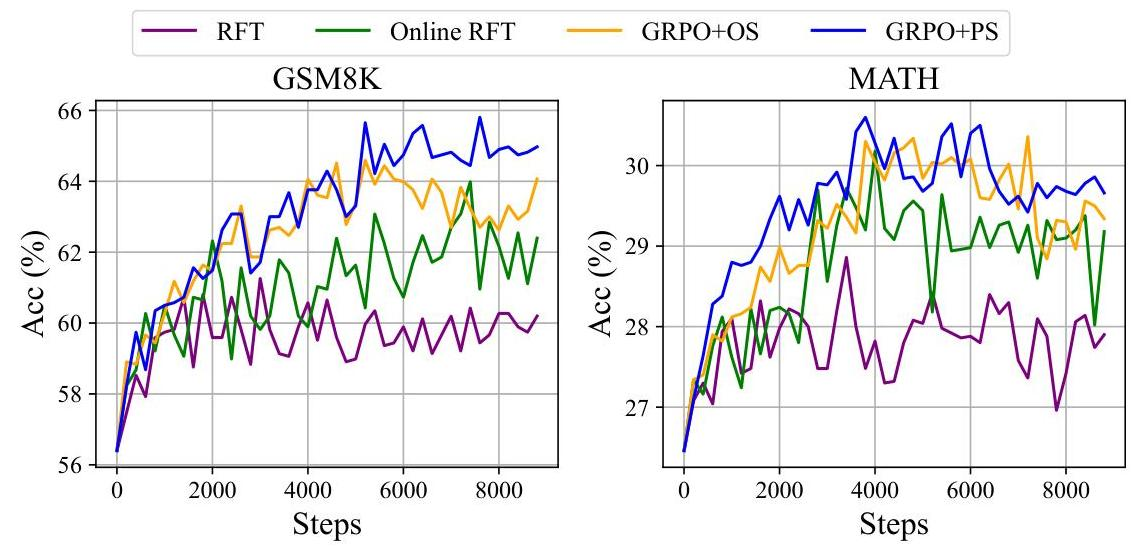
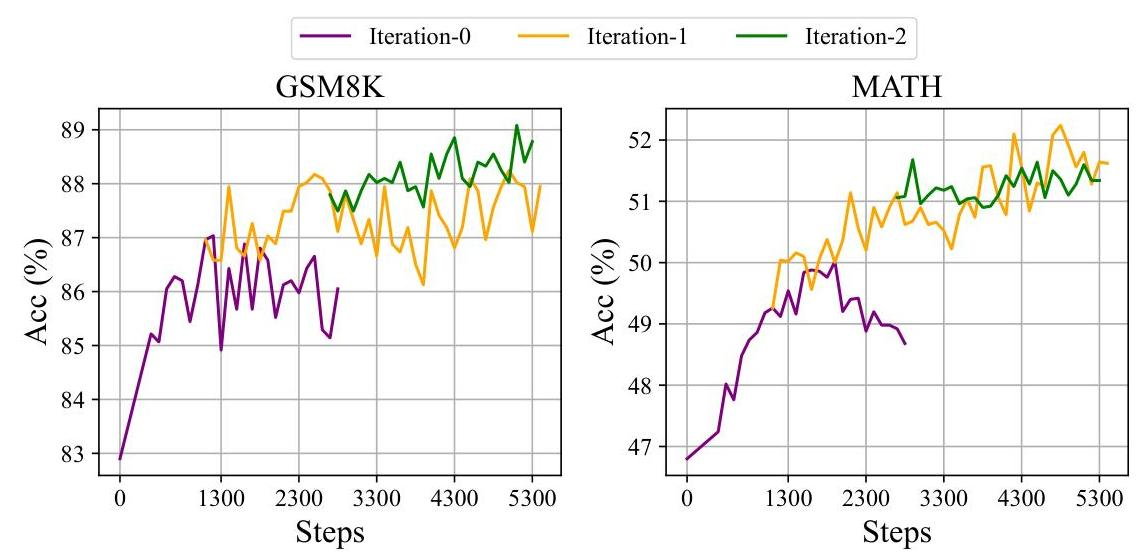
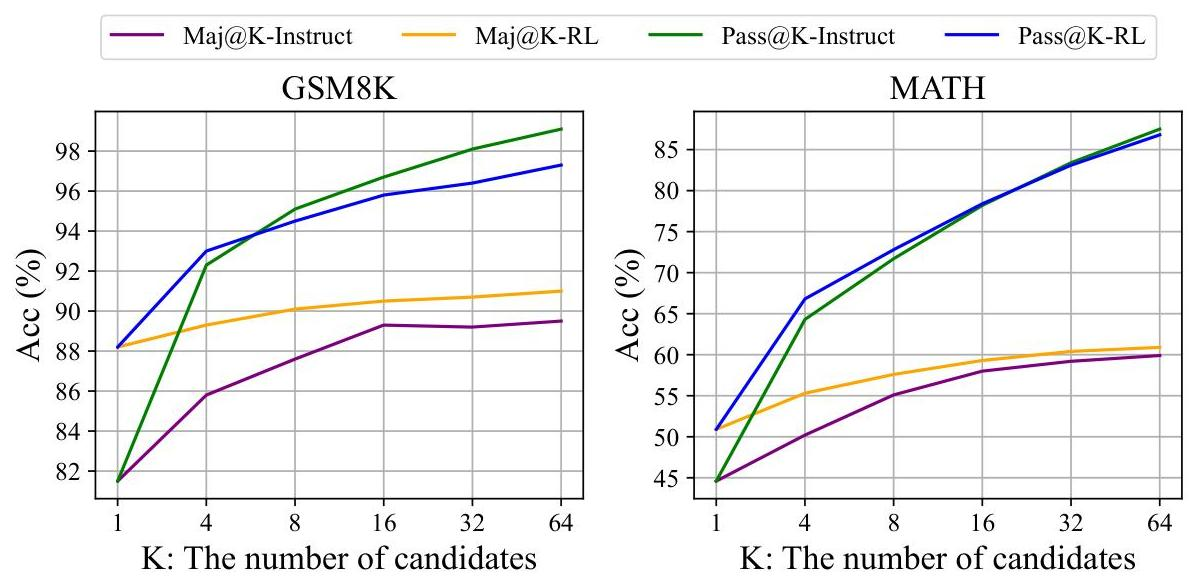

In [97]:
from mistralai import DocumentURLChunk, ImageURLChunk, TextChunk
import json

client = Mistral(api_key=os.environ['MISTRAL_API_KEY'])

# uploading the file
uploaded_file = client.files.upload(
    file={
        "file_name": pdf_file.stem,
        "content": pdf_file.read_bytes(),
    },
    purpose="ocr",
)

signed_url = client.files.get_signed_url(file_id=uploaded_file.id, expiry=1)

# OCRing the pdf document
pdf_response = client.ocr.process(document=DocumentURLChunk(document_url=signed_url.url),
                                  model="mistral-ocr-latest",
                                  include_image_base64=True)

response_dict = json.loads(pdf_response.model_dump_json()) # Corrected to use model_dump_json
json_string = json.dumps(response_dict, indent=4)

print(json_string)

# DeepSeekMath: Pushing the Limits of Mathematical Reasoning in Open Language Models 

Zhihong Shao ${ }^{1,2 * \dagger}$, Peiyi Wang ${ }^{1,3 * \dagger}$, Qihao Zhu ${ }^{1,3 * \dagger}$, Runxin Xu ${ }^{1}$, Junxiao Song ${ }^{1}$<br>Xiao Bi ${ }^{1}$, Haowei Zhang ${ }^{1}$, Mingchuan Zhang ${ }^{1}$, Y.K. Li ${ }^{1}$, Y. Wu ${ }^{1}$, Daya Guo ${ }^{1 *}$<br>${ }^{1}$ DeepSeek-AI, ${ }^{2}$ Tsinghua University, ${ }^{3}$ Peking University<br>\{zhihongshao, wangpeiyi, zhuqh, guoday\}@deepseek.com<br>https://github.com/deepseek-ai/DeepSeek-Math


#### Abstract

Mathematical reasoning poses a significant challenge for language models due to its complex and structured nature. In this paper, we introduce DeepSeekMath 7B, which continues pretraining DeepSeek-Coder-Base-v1.5 7B with 120B math-related tokens sourced from Common Crawl, together with natural language and code data. DeepSeekMath 7B has achieved an impressive score of $51.7 \%$ on the competition-level MATH benchmark without relying on external toolkits and voting techniques, approaching the performance level of Gemini-Ultra and GPT-4. Self-consistency over 64 samples from DeepSeekMath 7B achieves $60.9 \%$ on MATH. The mathematical reasoning capability of DeepSeekMath is attributed to two key factors: First, we harness the significant potential of publicly available web data through a meticulously engineered data selection pipeline. Second, we introduce Group Relative Policy Optimization (GRPO), a variant of Proximal Policy Optimization (PPO), that enhances mathematical reasoning abilities while concurrently optimizing the memory usage of PPO.


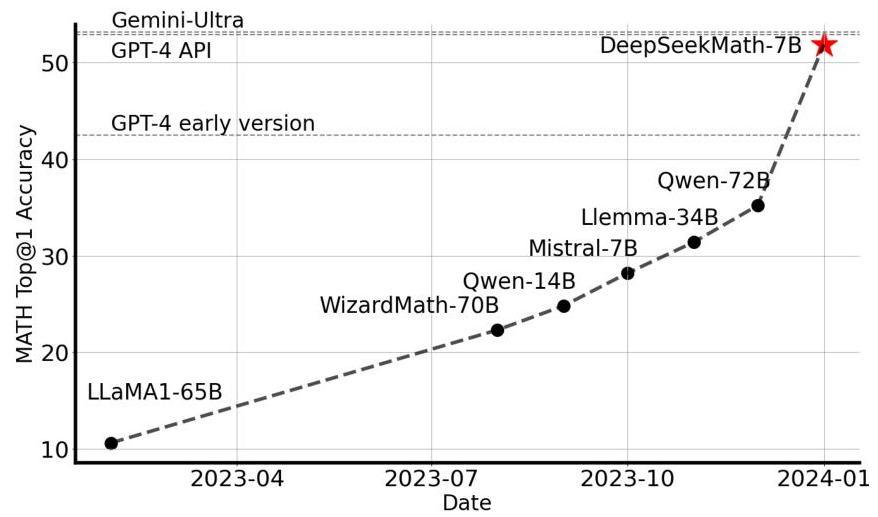

Figure $1 \mid$ Top1 accuracy of open-source models on the competition-level MATH benchmark (Hendrycks et al., 2021) without the use of external toolkits and voting techniques.

[^0]
[^0]:    * Core contributors.
    ${ }^{\dagger}$ Work done during internship at DeepSeek-AI.

# 1. Introduction 

Large language models (LLM) have revolutionized the approach to mathematical reasoning in artificial intelligence, spurring significant advancements in both the quantitative reasoning benchmark (Hendrycks et al., 2021) and the geometry reasoning benchmark (Trinh et al., 2024). Moreover, these models have proven instrumental in assisting humans in solving complex mathematical problems (Tao, 2023). However, cutting-edge models such as GPT-4 (OpenAI, 2023) and Gemini-Ultra (Anil et al., 2023) are not publicly available, and the currently accessible open-source models considerably trail behind in performance.

In this study, we introduce DeepSeekMath, a domain-specific language model that significantly outperforms the mathematical capabilities of open-source models and approaches the performance level of GPT-4 on academic benchmarks. To achieve this, we create the DeepSeekMath Corpus, a large-scale high-quality pre-training corpus comprising 120B math tokens. This dataset is extracted from the Common Crawl (CC) using a fastText-based classifier (Joulin et al., 2016). In the initial iteration, the classifier is trained using instances from OpenWebMath (Paster et al., 2023) as positive examples, while incorporating a diverse selection of other web pages to serve as negative examples. Subsequently, we employ the classifier to mine additional positive instances from the CC, which are further refined through human annotation. The classifier is then updated with this enhanced dataset to improve its performance. The evaluation results indicate that the large-scale corpus is of high quality, as our base model DeepSeekMath-Base 7B achieves $64.2 \%$ on GSM8K (Cobbe et al., 2021) and $36.2 \%$ on the competition-level MATH dataset (Hendrycks et al., 2021), outperforming Minerva 540B (Lewkowycz et al., 2022a). In addition, the DeepSeekMath Corpus is multilingual, so we notice an improvement in Chinese mathematical benchmarks (Wei et al., 2023; Zhong et al., 2023). We believe that our experience in mathematical data processing is a starting point for the research community, and there is significant room for improvement in the future.

DeepSeekMath-Base is initialized with DeepSeek-Coder-Base-v1.5 7B (Guo et al., 2024), as we notice that starting from a code training model is a better choice compared to a general LLM. Furthermore, we observe the math training also improves model capability on MMLU (Hendrycks et al., 2020) and BBH benchmarks (Suzgun et al., 2022), indicating it does not only enhance the model's mathematical abilities but also amplifies general reasoning capabilities.

After pre-training, we apply mathematical instruction tuning to DeepSeekMath-Base with chain-of-thought (Wei et al., 2022), program-of-thought (Chen et al., 2022; Gao et al., 2023), and tool-integrated reasoning (Gou et al., 2023) data. The resulting model DeepSeekMath-Instruct 7B beats all 7B counterparts and is comparable with 70B open-source instruction-tuned models.

Furthermore, we introduce the Group Relative Policy Optimization (GRPO), a variant reinforcement learning (RL) algorithm of Proximal Policy Optimization (PPO) (Schulman et al., 2017). GRPO foregoes the critic model, instead estimating the baseline from group scores, significantly reducing training resources. By solely using a subset of English instruction tuning data, GRPO obtains a substantial improvement over the strong DeepSeekMath-Instruct, including both in-domain (GSM8K: $82.9 \% \rightarrow 88.2 \%$, MATH: $46.8 \% \rightarrow 51.7 \%$ ) and out-of-domain mathematical tasks (e.g., CMATH: $84.6 \% \rightarrow 88.8 \%$ ) during the reinforcement learning phase. We also provide a unified paradigm to understand different methods, such as Rejection Sampling Fine-Tuning (RFT) (Yuan et al., 2023a), Direct Preference Optimization (DPO) (Rafailov et al., 2023), PPO and GRPO. Based on such a unified paradigm, we find that all these methods are conceptualized as either direct or simplified RL techniques. We also conduct extensive experiments, e.g., online v.s. offline training, outcome v.s. process supervision, single-turn v.s. iterative RL and so on,

to deeply investigate the essential elements of this paradigm. At last, we explain why our RL boosts the performance of instruction-tuned models, and further summarize potential directions to achieve more effective RL based on this unified paradigm.

# 1.1. Contributions 

Our contribution includes scalable math pre-training, along with the exploration and analysis of reinforcement learning.

## Math Pre-Training at Scale

- Our research provides compelling evidence that the publicly accessible Common Crawl data contains valuable information for mathematical purposes. By implementing a meticulously designed data selection pipeline, we successfully construct the DeepSeekMath Corpus, a high-quality dataset of 120B tokens from web pages filtered for mathematical content, which is almost 7 times the size of the math web pages used by Minerva (Lewkowycz et al., 2022a) and 9 times the size of the recently released OpenWebMath (Paster et al., 2023).
- Our pre-trained base model DeepSeekMath-Base 7B achieves comparable performance with Minerva 540B (Lewkowycz et al., 2022a), indicating the number of parameters is not the only key factor in mathematical reasoning capability. A smaller model pre-trained on high-quality data could achieve strong performance as well.
- We share our findings from math training experiments. Code training prior to math training improves models' ability to solve mathematical problems both with and without tool use. This offers a partial answer to the long-standing question: does code training improve reasoning abilities? We believe it does, at least for mathematical reasoning.
- Although training on arXiv papers is common, especially in many math-related papers, it brings no notable improvements on all mathematical benchmarks adopted in this paper.


## Exploration and Analysis of Reinforcement Learning

- We introduce Group Relative Policy Optimization (GRPO), an efficient and effective reinforcement learning algorithm. GRPO foregoes the critic model, instead estimating the baseline from group scores, significantly reducing training resources compared to Proximal Policy Optimization (PPO).
- We demonstrate that GRPO significantly enhances the performance of our instructiontuned model DeepSeekMath-Instruct, by solely using the instruction-tuning data. Furthermore, we observe enhancements in the out-of-domain performance during the reinforcement learning process.
- We provide a unified paradigm to understand different methods, such as RFT, DPO, PPO, and GRPO. We also conduct extensive experiments, e.g., online v.s. offline training, outcome v.s. process supervision, single-turn v.s. iterative reinforcement learning, and so on to deeply investigate the essential elements of this paradigm.
- Based on our unified paradigm, we explore the reasons behind the effectiveness of reinforcement learning, and summarize several potential directions to achieve more effective reinforcement learning of LLMs.


### 1.2. Summary of Evaluations and Metrics

- English and Chinese Mathematical Reasoning: We conduct comprehensive assessments of our models on English and Chinese benchmarks, covering mathematical problems

from grade-school level to college level. English benchmarks include GSM8K (Cobbe et al., 2021), MATH (Hendrycks et al., 2021), SAT (Azerbayev et al., 2023), OCW Courses (Lewkowycz et al., 2022a), MMLU-STEM (Hendrycks et al., 2020). Chinese benchmarks include MGSM-zh (Shi et al., 2023), CMATH (Wei et al., 2023), Gaokao-MathCloze (Zhong et al., 2023), and Gaokao-MathQA (Zhong et al., 2023). We evaluate models' ability to generate self-contained text solutions without tool use, and also the ability to solve problems using Python.
On English benchmarks, DeepSeekMath-Base is competitive with the closed-source Minerva 540B (Lewkowycz et al., 2022a), and surpasses all open-source base models (e.g., Mistral 7B (Jiang et al., 2023) and Llemma-34B (Azerbayev et al., 2023)), regardless of whether they've undergone math pre-training or not, often by a significant margin. Notably, DeepSeekMath-Base is superior on Chinese benchmarks, likely because we don't follow previous works (Azerbayev et al., 2023; Lewkowycz et al., 2022a) to collect English-only math pre-training data, and also include high-quality non-English ones. With mathematical instruction tuning and reinforcement learning, the resulting DeepSeekMath-Instruct and DeepSeekMath-RL demonstrate strong performance, obtaining an accuracy of over $50 \%$ on the competition-level MATH dataset for the first time within the open-source community.

- Formal Mathematics: We evaluate DeepSeekMath-Base using the informal-to-formal theorem proving task from (Jiang et al., 2022) on miniF2F (Zheng et al., 2021) with Isabelle (Wenzel et al., 2008) chosen to be the proof assistant. DeepSeekMath-Base demonstrates strong few-shot autoformalization performance.
- Natural Language Understanding, Reasoning, and Code: To build a comprehensive profile of models' general understanding, reasoning, and coding capabilities, we evaluate DeepSeekMath-Base on the Massive Multitask Language Understanding (MMLU) benchmark (Hendrycks et al., 2020) which encompasses 57 multiple-choice tasks covering diverse subjects, BIG-Bench Hard (BBH) (Suzgun et al., 2022) which consists of 23 challenging tasks that mostly require multi-step reasoning to solve, as well as HumanEval (Chen et al., 2021) and MBPP (Austin et al., 2021) which are widely used to evaluate code language models. Math pre-training benefits both language understanding and reasoning performance.


# 2. Math Pre-Training 

### 2.1. Data Collection and Decontamination

In this section, we will outline the process of constructing the DeepSeekMath Corpus from Common Crawl. As depicted in Figure 2, we present an iterative pipeline that demonstrates how to systematically gather a large-scale mathematical corpus from Common Crawl, starting with a seed corpus (e.g., a small but high-quality collection of math-related dataset). It's worth noting that this approach is also applicable to other domains, such as coding.

First, we choose OpenWebMath (Paster et al., 2023), a collection of high-quality mathematical web texts, as our initial seed corpus. Using this corpus, we train a fastText model (Joulin et al., 2016) to recall more OpenWebMath-like mathematical web pages. Specifically, we randomly select 500,000 data points from the seed corpus as positive training examples and another 500,000 web pages from Common Crawl as negative ones. We employ an open-source library ${ }^{1}$ for training, configuring the vector dimension to 256 , learning rate to 0.1 , the maximum length

[^0]
[^0]:    ${ }^{1}$ https://fasttext.cc

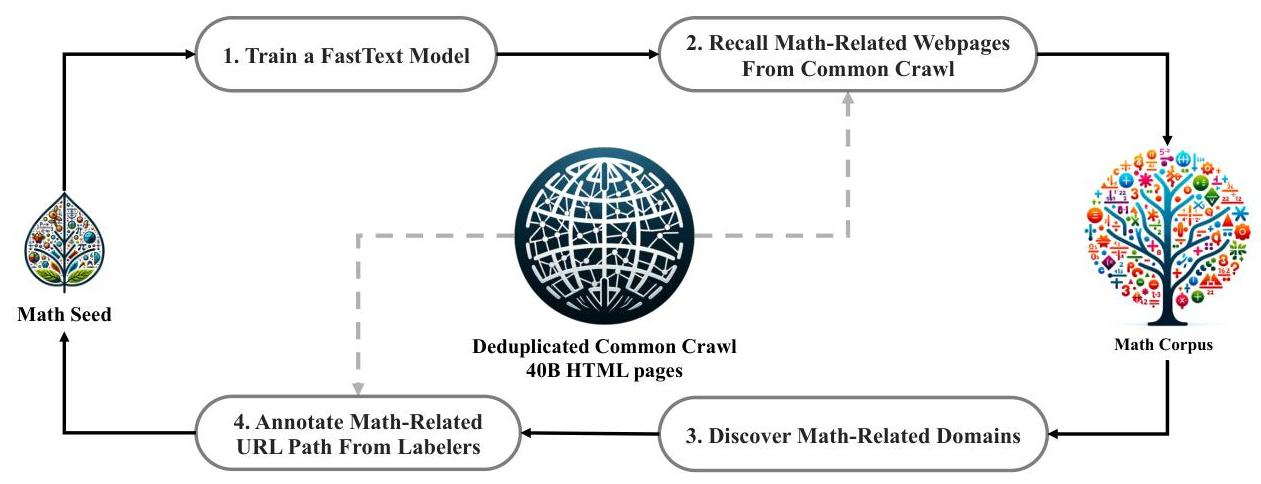

Figure 2 | An iterative pipeline that collects mathematical web pages from Common Crawl.
of word n-gram to 3, the minimum number of word occurrences to 3, and the number of training epochs to 3. To reduce the size of the original Common Crawl, we employ URL-based deduplication and near-deduplication techniques, resulting in 40B HTML web pages. We then recall mathematical web pages from deduplicated Common Crawl with the fastText model. To filter out low-quality mathematical content, we rank the collected pages according to their scores predicted by the fastText model, and only preserve the top-ranking ones. The volume of data preserved is assessed through pre-training experiments on the top 40B, 80B, 120B, and 160B tokens. In the first iteration, we choose to keep the top 40B tokens.

After the first iteration of data collection, numerous mathematical web pages remain uncollected, mainly because the fastText model is trained on a set of positive examples that lacks sufficient diversity. We therefore identify additional mathematical web sources to enrich the seed corpus, so that we can optimize the fastText model. Specifically, we first organize the entire Common Crawl into disjoint domains; a domain is defined as web pages sharing the same base URL. For each domain, we calculate the percentage of web pages that are collected in the first iteration. Domains where over $10 \%$ of the web pages have been collected are classified as math-related (e.g., mathoverflow.net). Subsequently, we manually annotate the URLs associated with mathematical content within these identified domains (e.g., mathoverflow.net/questions). Web pages linked to these URLs, yet uncollected, will be added to the seed corpus. This approach enables us to gather more positive examples, thereby training an improved fastText model capable of recalling more mathematical data in the subsequent iteration. After four iterations of data collection, we end up with 35.5 M mathematical web pages, totaling 120B tokens. In the fourth iteration, we notice that nearly $98 \%$ of the data has already been collected in the third iteration, so we decide to cease data collection.

To avoid benchmark contamination, we follow Guo et al. (2024) to filter out web pages containing questions or answers from English mathematical benchmarks such as GSM8K (Cobbe et al., 2021) and MATH (Hendrycks et al., 2021) and Chinese benchmarks such as CMATH (Wei et al., 2023) and AGIEval (Zhong et al., 2023). The filtering criteria are as follows: any text segment containing a 10-gram string that matches exactly with any sub-string from the evaluation benchmarks is removed from our math training corpus. For benchmark texts that are shorter than 10 grams but have at least 3 grams, we employ exact matching to filter out contaminated web pages.

# 2.2. Validating the Quality of the DeepSeekMath Corpus 

We run pre-training experiments to investigate how the DeepSeekMath Corpus is compared with the recently released math-training corpora:

- MathPile (Wang et al., 2023c): a multi-source corpus (8.9B tokens) aggregated from textbooks, Wikipedia, ProofWiki, CommonCrawl, StackExchange, and arXiv, with the majority (over 85\%) sourced from arXiv;
- OpenWebMath (Paster et al., 2023): CommonCrawl data filtered for mathematical content, totaling 13.6B tokens;
- Proof-Pile-2 (Azerbayev et al., 2023): a mathematical corpus consisting of OpenWebMath, AlgebraicStack (10.3B tokens of mathematical code), and arXiv papers (28.0B tokens). When experimenting on Proof-Pile-2, we follow Azerbayev et al. (2023) to use an arXiv:Web:Code ratio of 2:4:1.


### 2.2.1. Training Setting

We apply math training to a general pre-trained language model with 1.3B parameters, which shares the same framework as the DeepSeek LLMs (DeepSeek-AI, 2024), denoted as DeepSeekLLM 1.3B. We separately train a model on each mathematical corpus for 150B tokens. All experiments are conducted using the efficient and light-weight HAI-LLM (High-flyer, 2023) training framework. Following the training practice of DeepSeek LLMs, we use the AdamW optimizer (Loshchilov and Hutter, 2017) with $\beta_{1}=0.9, \beta_{2}=0.95$, and weight_decay $=0.1$, along with a multi-step learning rate schedule where the learning rate reaches the peak after 2,000 warmup steps, decreases to its $31.6 \%$ after $80 \%$ of the training process, and further decreases to $10.0 \%$ of the peak after $90 \%$ of the training process. We set the maximum value of learning rate to $5.3 \mathrm{e}-4$, and use a batch size of 4 M tokens with a 4 K context length.

| Math Corpus | Size | English Benchmarks |  |  |  |  | Chinese Benchmarks |  |  |
| :--: | :--: | :--: | :--: | :--: | :--: | :--: | :--: | :--: | :--: |
|  |  | GSM8K | MATH | OCW | SAT | MMLU <br> STEM | CMATH | Gaokao <br> MathCloze | Gaokao <br> MathQA |
| No Math Training | N/A | $2.9 \%$ | $3.0 \%$ | $2.9 \%$ | $15.6 \%$ | $19.5 \%$ | $12.3 \%$ | $0.8 \%$ | $17.9 \%$ |
| MathPile | 8.9B | $2.7 \%$ | $3.3 \%$ | $2.2 \%$ | $12.5 \%$ | $15.7 \%$ | $1.2 \%$ | $0.0 \%$ | $2.8 \%$ |
| OpenWebMath | 13.6B | $11.5 \%$ | $8.9 \%$ | $3.7 \%$ | $31.3 \%$ | $29.6 \%$ | $16.8 \%$ | $0.0 \%$ | $14.2 \%$ |
| Proof-Pile-2 | 51.9B | $14.3 \%$ | $11.2 \%$ | $3.7 \%$ | $43.8 \%$ | $29.2 \%$ | $19.9 \%$ | $5.1 \%$ | $11.7 \%$ |
| DeepSeekMath Corpus | 120.2B | $23.8 \%$ | $13.6 \%$ | $4.8 \%$ | $56.3 \%$ | $33.1 \%$ | $41.5 \%$ | $5.9 \%$ | $23.6 \%$ |

Table 1 | Performance of DeepSeek-LLM 1.3B trained on different mathematical corpora, evaluated using few-shot chain-of-thought prompting. Corpus sizes are calculated using our tokenizer with a vocabulary size of 100 K .

### 2.2.2. Evaluation Results

The DeepSeekMath Corpus is of high quality, covers multilingual mathematical content, and is the largest in size.

- High-quality: We evaluate downstream performance on 8 mathematical benchmarks using few-shot chain-of-thought prompting Wei et al. (2022). As shown in Table 1, there is a clear performance lead of the model trained on the DeepSeekMath Corpus. Figure 3 shows that the model trained on the DeepSeekMath Corpus demonstrates better performance than

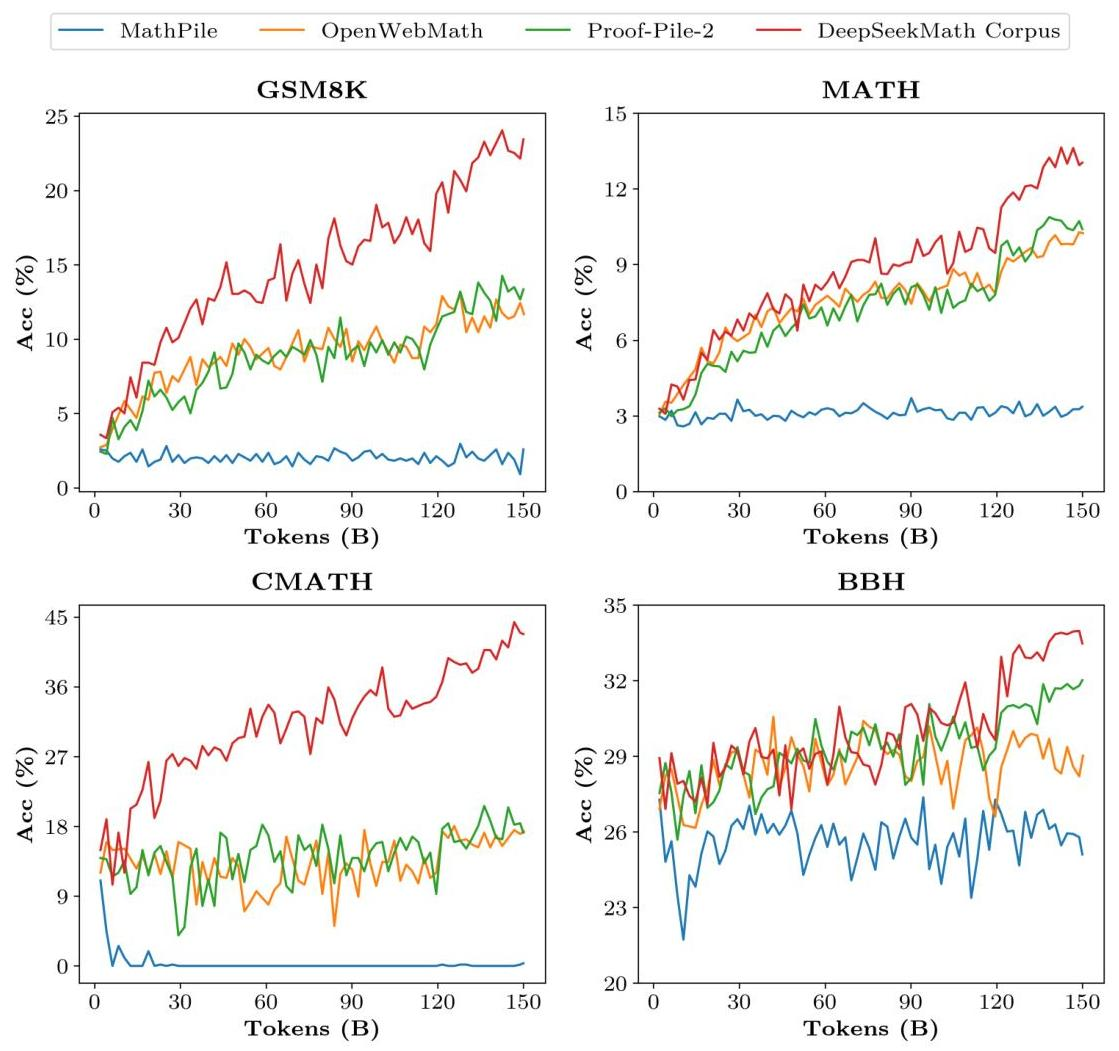

Figure 3 | Benchmark curves of DeepSeek-LLM 1.3B trained on different mathematical corpora.

Proof-Pile-2 at 50B tokens (1 full epoch of Proof-Pile-2), indicating the average quality of DeepSeekMath Corpus is higher.

- Multilingual: The DeepSeekMath Corpus encompasses data in multiple languages, predominantly featuring English and Chinese as the two most represented languages. As shown in Table 1, training on the DeepSeekMath Corpus enhances mathematical reasoning performance in both English and Chinese. In contrast, existing mathematical corpora, which are primarily English-centric, show limited improvement and may even hinder performance in Chinese mathematical reasoning.
- Large-scale: The DeepSeekMath Corpus is several times larger than existing mathematical corpora. As depicted in Figure 3, DeepSeek-LLM 1.3B, when trained on the DeepSeekMath Corpus, shows a steeper learning curve along with more lasting improvements. In contrast, the baseline corpora are much smaller, and have already been repeated multiple rounds during training, with the resulting model performance quickly reaching a plateau.


# 2.3. Training and Evaluating DeepSeekMath-Base 7B 

In this section, we introduce DeepSeekMath-Base 7B, a base model with strong reasoning abilities, especially in mathematics. Our model is initialized with DeepSeek-Coder-Base-v1.5 7B

(Guo et al., 2024) and trained for 500B tokens. The distribution of the data is as follows: 56\% is from the DeepSeekMath Corpus, 4\% from AlgebraicStack, 10\% from arXiv, 20\% is Github code, and the remaining $10 \%$ is natural language data from Common Crawl in both English and Chinese. We mainly adopt the training setting specified in Section 2.2.1, except that we set the maximum value of the learning rate to $4.2 \mathrm{e}-4$ and use a batch size of 10 M tokens.

We conduct a comprehensive assessment of the mathematical capabilities of DeepSeekMathBase 7B, focusing on its ability to produce self-contained mathematical solutions without relying on external tools, solve mathematical problems using tools, and conduct formal theorem proving. Beyond mathematics, we also provide a more general profile of the base model, including its performance of natural language understanding, reasoning, and programming skills.

Mathematical Problem Solving with Step-by-Step Reasoning We evaluate DeepSeekMathBase's performance of solving mathematical problems using few-shot chain-of-thought prompting (Wei et al., 2022), across eight benchmarks in English and Chinese. These benchmarks encompass quantitative reasoning (e.g., GSM8K (Cobbe et al., 2021), MATH (Hendrycks et al., 2021), and CMATH (Wei et al., 2023)) and multiple-choice problems (e.g., MMLU-STEM (Hendrycks et al., 2020) and Gaokao-MathQA (Zhong et al., 2023)), covering diverse fields of mathematics from elementary to college-level complexity.

As shown in Table 2, DeepSeekMath-Base 7B leads in performance across all eight benchmarks among the open-source base models (including the widely-used general model Mistral 7B (Jiang et al., 2023) and the recently released Llemma 34B (Azerbayev et al., 2023) which underwent math training on Proof-Pile-2 (Azerbayev et al., 2023)). Notably, on the competitionlevel MATH dataset, DeepSeekMath-Base surpasses existing open-source base models by over 10\% absolute, and outperforms Minerva 540B (Lewkowycz et al., 2022a), a closed-source base model 77 times larger which builds on PaLM (Lewkowycz et al., 2022b) and is further trained on mathematical texts.

| Model | Size | English Benchmarks |  |  |  |  | Chinese Benchmarks |  |  |
| :--: | :--: | :--: | :--: | :--: | :--: | :--: | :--: | :--: | :--: |
|  |  | GSM8K | MATH | OCW | SAT | MMLU <br> STEM | CMATH | Gaokao MathCloze | Gaokao MathQA |
| Closed-Source Base Model |  |  |  |  |  |  |  |  |  |
| Minerva | 7B | $16.2 \%$ | $14.1 \%$ | $7.7 \%$ | - | $35.6 \%$ | - | - | - |
| Minerva | 62B | $52.4 \%$ | $27.6 \%$ | $12.0 \%$ | - | $53.9 \%$ | - | - | - |
| Minerva | 540B | $58.8 \%$ | $33.6 \%$ | $17.6 \%$ | - | $63.9 \%$ | - | - | - |
| Open-Source Base Model |  |  |  |  |  |  |  |  |  |
| Mistral | 7B | $40.3 \%$ | $14.3 \%$ | $9.2 \%$ | $71.9 \%$ | $51.1 \%$ | $44.9 \%$ | $5.1 \%$ | $23.4 \%$ |
| Llemma | 7B | $37.4 \%$ | $18.1 \%$ | $6.3 \%$ | $59.4 \%$ | $43.1 \%$ | $43.4 \%$ | $11.9 \%$ | $23.6 \%$ |
| Llemma | 34B | $54.0 \%$ | $25.3 \%$ | $10.3 \%$ | $71.9 \%$ | $52.9 \%$ | $56.1 \%$ | $11.9 \%$ | $26.2 \%$ |
| DeepSeekMath-Base | 7B | $\mathbf{6 4 . 2 \%}$ | $\mathbf{3 6 . 2 \%}$ | $\mathbf{1 5 . 4 \%}$ | $\mathbf{8 4 . 4 \%}$ | $\mathbf{5 6 . 5 \%}$ | $\mathbf{7 1 . 7 \%}$ | $\mathbf{2 0 . 3 \%}$ | $\mathbf{3 5 . 3 \%}$ |

Table 2 | Comparisons between DeepSeekMath-Base 7B and strong base models on English and Chinese mathematical benchmarks. Models are evaluated with chain-of-thought prompting. Minerva results are quoted from Lewkowycz et al. (2022a).

Mathematical Problem Solving with Tool Use We evaluate program-aided mathematical reasoning on GSM8K and MATH using few-shot program-of-thought prompting (Chen et al., 2022; Gao et al., 2023). Models are prompted to solve each problem by writing a Python program where libraries such as math and sympy can be utilized for intricate computations. The execution result of the program is evaluated as the answer. As shown in Table 3, DeepSeekMath-Base 7B outperforms the prior state-of-the-art Llemma 34B.

| Model | Size | Problem Solving w/ Tools |  | Informal-to-Formal Proving |  |
| :-- | :--: | :--: | :--: | :--: | :--: |
|  |  | GSM8K+Python | MATH+Python | miniF2F-valid | miniF2F-test |
| Mistral | 7B | $48.5 \%$ | $18.2 \%$ | $18.9 \%$ | $18.0 \%$ |
| CodeLlama | 7B | $27.1 \%$ | $17.2 \%$ | $16.3 \%$ | $17.6 \%$ |
| CodeLlama | 34B | $52.7 \%$ | $23.5 \%$ | $18.5 \%$ | $18.0 \%$ |
| Llemma | 7B | $41.0 \%$ | $18.6 \%$ | $20.6 \%$ | $22.1 \%$ |
| Llemma | 34B | $64.6 \%$ | $26.3 \%$ | $21.0 \%$ | $21.3 \%$ |
| DeepSeekMath-Base | 7B | $\mathbf{6 6 . 9 \%}$ | $\mathbf{3 1 . 4 \%}$ | $\mathbf{2 5 . 8 \%}$ | $\mathbf{2 4 . 6 \%}$ |

Table $3 \mid$ Few-shot evaluation of base models' ability to solve mathematical problems using tools and the ability to conduct informal-to-formal theorem proving in Isabelle.

Formal Mathematics Formal proof automation is beneficial to ensure the accuracy and reliability of mathematical proofs and enhance efficiency, with increasing attention in recent years. We evaluate DeepSeekMath-Base 7B on the task of informal-to-formal proving from (Jiang et al., 2022) which is to generate a formal proof based on an informal statement, a formal counterpart of the statement, and an informal proof. We evaluate on miniF2F (Zheng et al., 2021), a benchmark for formal Olympiad-level mathematics, and generate a formal proof in Isabelle for each problem with few-shot prompting. Following Jiang et al. (2022), we leverage models to generate proof sketches, and execute the off-the-shelf automated prover Sledgehammer (Paulson, 2010) to fill in the missing details. As shown in Table 3, DeepSeekMath-Base 7B demonstrates strong performance in proof autoformalization.

| Model | Size | MMLU | BBH | HumanEval (Pass@1) | MBPP (Pass@1) |
| :-- | :--: | :--: | :--: | :--: | :--: |
| Mistral | 7B | $\mathbf{6 2 . 4 \%}$ | $55.7 \%$ | $28.0 \%$ | $41.4 \%$ |
| DeepSeek-Coder-Base-v1.5 | 7B | $42.9 \%$ | $42.9 \%$ | $40.2 \%$ | $52.6 \%$ |
| DeepSeek-Coder-Base-v1.5 | 7B | $49.1 \%$ | $55.2 \%$ | $\mathbf{4 3 . 2 \%}$ | $\mathbf{6 0 . 4 \%}$ |
| DeepSeekMath-Base | 7B | $54.9 \%$ | $\mathbf{5 9 . 5 \%}$ | $40.9 \%$ | $52.6 \%$ |

Table $4 \mid$ Evaluation on natural language understanding, reasoning, and code benchmarks. DeepSeek-Coder-Base-v1.5 ${ }^{\dagger}$ is the checkpoint right before learning rate decay, which is used to train DeepSeekMath-Base. On MMLU and BBH, we use few-shot chain-of-thought prompting. On HumanEval and MBPP, we evaluate model performance under the zero-shot setting and a few-shot setting, respectively.

Natural Language Understanding, Reasoning, and Code We evaluate model performance of natural language understanding on MMLU (Hendrycks et al., 2020), reasoning on BBH (Suzgun et al., 2022), and coding capabilities on HumanEval (Chen et al., 2021) and MBPP (Austin et al.,

2021). As shown in Table 4, DeepSeekMath-Base 7B exhibits significant enhancements in performance on MMLU and BBH over its precursor, DeepSeek-Coder-Base-v1.5 (Guo et al., 2024), illustrating the positive impact of math training on language understanding and reasoning. Additionally, by including code tokens for continual training, DeepSeekMath-Base 7B effectively maintains the performance of DeepSeek-Coder-Base-v1.5 on the two coding benchmarks. Overall, DeepSeekMath-Base 7B significantly outperforms the general model Mistral 7B (Jiang et al., 2023) on the three reasoning and coding benchmarks.

# 3. Supervised Fine-Tuning 

### 3.1. SFT Data Curation

We construct a mathematical instruction-tuning dataset covering English and Chinese problems from different mathematical fields and of varying complexity levels: problems are paired with solutions in chain-of-thought (CoT) (Wei et al., 2022), program-of-thought (PoT) (Chen et al., 2022; Gao et al., 2023), and tool-integrated reasoning format (Gou et al., 2023). The total number of training examples is 776 K .

- English mathematical datasets: We annotate GSM8K and MATH problems with toolintegrated solutions, and adopt a subset of MathInstruct (Yue et al., 2023) along with the training set of Lila-OOD (Mishra et al., 2022) where problems are solved with CoT or PoT. Our English collection covers diverse fields of mathematics, e.g., algebra, probability, number theory, calculus, and geometry.
- Chinese mathematical datasets: We collect Chinese K-12 mathematical problems spanning 76 sub-topics such as linear equations, with solutions annotated in both CoT and toolintegrated reasoning format.


### 3.2. Training and Evaluating DeepSeekMath-Instruct 7B

In this section, we introduce DeepSeekMath-Instruct 7B which undergoes mathematical instruction tuning based on DeepSeekMath-Base. Training examples are randomly concatenated until reaching a maximum context length of 4 K tokens. We train the model for 500 steps with a batch size of 256 and a constant learning rate of $5 \mathrm{e}-5$.

We evaluate models' mathematical performance both without and with tool use, on 4 quantitative reasoning benchmarks in English and Chinese. We benchmark our model against the leading models of the time:

- Closed-source models include: (1) the GPT family among which GPT-4 (OpenAI, 2023) and GPT-4 Code Interpreter ${ }^{2}$ are the most capable ones, (2) Gemini Ultra and Pro (Anil et al., 2023), (3) Inflection-2 (Inflection AI, 2023), (4) Grok-1 ${ }^{3}$, as well as models recently released by Chinese companies including (5) Baichuan-3 ${ }^{4}$, (6) the latest GLM-4 ${ }^{5}$ from the GLM family (Du et al., 2022). These models are for general purposes, most of which have undergone a series of alignment procedures.
- Open-source models include: general models like (1) DeepSeek-LLM-Chat 67B (DeepSeekAI, 2024), (2) Qwen 72B (Bai et al., 2023), (3) SeaLLM-v2 7B (Nguyen et al., 2023), and (4)

[^0]
[^0]:    ${ }^{2}$ https://openai.com/blog/chatgpt-plugins\#code-interpreter
    ${ }^{3}$ https://x.ai/model-card
    ${ }^{4}$ https://www.baichuan-ai.com
    ${ }^{5}$ https://open.bigmodel.cn/dev/api\#glm-4

ChatGLM3 6B (ChatGLM3 Team, 2023), as well as models with enhancements in mathematics including (5) InternLM2-Math $20 B{ }^{6}$ which builds on InternLM2 and underwent math training followed by instruction tuning, (6) Math-Shepherd-Mistral 7B which applys PPO training (Schulman et al., 2017) to Mistral 7B (Jiang et al., 2023) with a process-supervised reward model, (7) the WizardMath series (Luo et al., 2023) which improves mathematical reasoning in Mistral 7B and Llama-2 70B (Touvron et al., 2023) using evolve-instruct (i.e., a version of instruction tuning that uses AI-evolved instructions) and PPO training with training problems primarily sourced from GSM8K and MATH, (8) MetaMath 70B (Yu et al., 2023) which is Llama-2 70B fine-tuned on an augmented version of GSM8K and MATH, (9) ToRA 34B Gou et al. (2023) which is CodeLlama 34B fine-tuned to do tool-integrated mathematical reasoning, (10) MAmmoTH 70B (Yue et al., 2023) which is Llama-2 70B instruction-tuned on MathInstruct.
As shown in Table 5, under the evaluation setting where tool use is disallowed, DeepSeekMathInstruct 7B demonstrates strong performance of step-by-step reasoning. Notably, on the competition-level MATH dataset, our model surpasses all open-source models and the majority of proprietary models (e.g., Inflection-2 and Gemini Pro) by at least 9\% absolute. This is true even for models that are substantially larger (e.g., Qwen 72B) or have been specifically enhanced through math-focused reinforcement learning (e.g., WizardMath-v1.1 7B). While DeepSeekMath-Instruct rivals the Chinese proprietary models GLM-4 and Baichuan-3 on MATH, it still underperforms GPT-4 and Gemini Ultra.

Under the evaluation setting where models are allowed to integrate natural language reasoning and program-based tool use for problem solving, DeepSeekMath-Instruct 7B approaches an accuracy of $60 \%$ on MATH, surpassing all existing open-source models. On the other benchmarks, our model is competitive with DeepSeek-LLM-Chat 67B, the prior state-of-the-art that is 10 times larger.

# 4. Reinforcement Learning 

### 4.1. Group Relative Policy Optimization

Reinforcement learning (RL) has been proven to be effective in further improving the mathematical reasoning ability of LLMs after the Supervised Fine-Tuning (SFT) stage (Luo et al., 2023; Wang et al., 2023b). In this section, we introduce our efficient and effective RL algorithm, Group Relative Policy Optimization (GRPO).

### 4.1.1. From PPO to GRPO

Proximal Policy Optimization (PPO) (Schulman et al., 2017) is an actor-critic RL algorithm that is widely used in the RL fine-tuning stage of LLMs (Ouyang et al., 2022). In particular, it optimizes LLMs by maximizing the following surrogate objective:

$$
\mathcal{J}_{\text {PPO }}(\theta)=\mathbb{E}\left[q \sim P(Q), o \sim \pi_{\theta_{s t d}}(O \mid q)\right] \frac{1}{|\sigma|} \sum_{t=1}^{|\sigma|} \min \left\{\frac{\pi_{\theta}\left(o_{t} \mid q, o_{<t}\right)}{\pi_{\theta_{s t d}}\left(o_{t} \mid q, o_{<t}\right)} A_{t}, \operatorname{clip}\left(\frac{\pi_{\theta}\left(o_{t} \mid q, o_{<t}\right)}{\pi_{\theta_{s t d}}\left(o_{t} \mid q, o_{<t}\right)}, 1-\varepsilon, 1+\varepsilon\right\} A_{t}\right\}
$$

where $\pi_{\theta}$ and $\pi_{\theta_{s t d}}$ are the current and old policy models, and $q, o$ are questions and outputs sampled from the question dataset and the old policy $\pi_{\theta_{s t d}}$, respectively. $\varepsilon$ is a clipping-related hyper-parameter introduced in PPO for stabilizing training. $A_{t}$ is the advantage, which is computed by applying Generalized Advantage Estimation (GAE) (Schulman et al., 2015), based

[^0]
[^0]:    ${ }^{6}$ https://github.com/InternLM/InternLM-Math

| Model | Size | English Benchmarks |  | Chinese Benchmarks |  |
| :--: | :--: | :--: | :--: | :--: | :--: |
|  |  | GSM8K | MATH | MGSM-zh | CMATH |
| Chain-of-Thought Reasoning |  |  |  |  |  |
| Closed-Source Model |  |  |  |  |  |
| Gemini Ultra | - | $94.4 \%$ | $53.2 \%$ | - | - |
| GPT-4 | - | $92.0 \%$ | $52.9 \%$ | - | $86.0 \%$ |
| Inflection-2 | - | $81.4 \%$ | $34.8 \%$ | - | - |
| GPT-3.5 | - | $80.8 \%$ | $34.1 \%$ | - | $73.8 \%$ |
| Gemini Pro | - | $86.5 \%$ | $32.6 \%$ | - | - |
| Grok-1 | - | $62.9 \%$ | $23.9 \%$ | - | - |
| Baichuan-3 | - | $88.2 \%$ | $49.2 \%$ | - | - |
| GLM-4 | - | $87.6 \%$ | $47.9 \%$ | - | - |
| Open-Source Model |  |  |  |  |  |
| InternLM2-Math | 20B | $82.6 \%$ | $37.7 \%$ | - | - |
| Qwen | 72B | $78.9 \%$ | $35.2 \%$ | - | - |
| Math-Shepherd-Mistral | 7B | $84.1 \%$ | $33.0 \%$ | - | - |
| WizardMath-v1.1 | 7B | $83.2 \%$ | $33.0 \%$ | - | - |
| DeepSeek-LLM-Chat | 67B | $84.1 \%$ | $32.6 \%$ | $74.0 \%$ | $80.3 \%$ |
| MetaMath | 70B | $82.3 \%$ | $26.6 \%$ | $66.4 \%$ | $70.9 \%$ |
| SeaLLM-v2 | 7B | $78.2 \%$ | $27.5 \%$ | $64.8 \%$ | - |
| ChatGLM3 | 6B | $72.3 \%$ | $25.7 \%$ | - | - |
| WizardMath-v1.0 | 70B | $81.6 \%$ | $22.7 \%$ | $64.8 \%$ | $65.4 \%$ |
| DeepSeekMath-Instruct | 7B | $82.9 \%$ | $46.8 \%$ | $73.2 \%$ | $84.6 \%$ |
| DeepSeekMath-RL | 7B | $88.2 \%$ | $51.7 \%$ | $79.6 \%$ | $88.8 \%$ |
| Tool-Integrated Reasoning |  |  |  |  |  |
| Closed-Source Model |  |  |  |  |  |
| GPT-4 Code Interpreter | - | $97.0 \%$ | $69.7 \%$ | - | - |
| Open-Source Model |  |  |  |  |  |
| InternLM2-Math | 20B | $80.7 \%$ | $54.3 \%$ | - | - |
| DeepSeek-LLM-Chat | 67B | $86.7 \%$ | $51.1 \%$ | $76.4 \%$ | $85.4 \%$ |
| ToRA | 34B | $80.7 \%$ | $50.8 \%$ | $41.2 \%$ | $53.4 \%$ |
| MAmmoTH | 70B | $76.9 \%$ | $41.8 \%$ | - | - |
| DeepSeekMath-Instruct | 7B | $83.7 \%$ | $57.4 \%$ | $72.0 \%$ | $84.3 \%$ |
| DeepSeekMath-RL | 7B | $86.7 \%$ | $58.8 \%$ | $78.4 \%$ | $87.6 \%$ |

Table $5 \mid$ Performance of Open- and Closed-Source models with both Chain-of-Thought and Tool-Integrated Reasoning on English and Chinese Benchmarks. Scores in gray denote majority votes with 32 candidates; The others are Top1 scores. DeepSeekMath-RL 7B beats all opensource models from 7B to 70B, as well as the majority of closed-source models. Although DeepSeekMath-RL 7B is only further trained on chain-of-thought-format instruction tuning data of GSM8K and MATH, it improves over DeepSeekMath-Instruct 7B on all benchmarks.

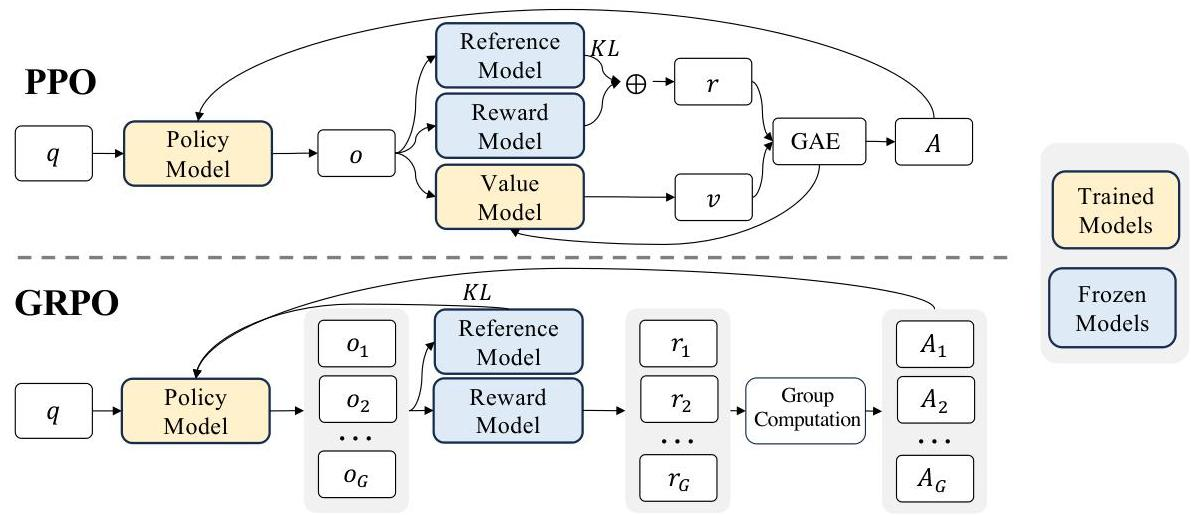

Figure 4 | Demonstration of PPO and our GRPO. GRPO foregoes the value model, instead estimating the baseline from group scores, significantly reducing training resources.
on the rewards $\left\{r_{\leq t}\right\}$ and a learned value function $V_{\phi}$. Thus, in PPO, a value function needs to be trained alongside the policy model and to mitigate over-optimization of the reward model, the standard approach is to add a per-token KL penalty from a reference model in the reward at each token (Ouyang et al., 2022), i.e.,

$$
r_{\mathrm{r}}=r_{\phi}\left(q, o_{\leq t}\right)-\beta \log \frac{\pi_{\theta}\left(o_{1} \mid q, o_{<t}\right)}{\pi_{r e f}\left(o_{t} \mid q, o_{<t}\right)}
$$

where $r_{\phi}$ is the reward model, $\pi_{\text {ref }}$ is the reference model, which is usually the initial SFT model, and $\beta$ is the coefficient of the KL penalty.

As the value function employed in PPO is typically another model of comparable size as the policy model, it brings a substantial memory and computational burden. Additionally, during RL training, the value function is treated as a baseline in the calculation of the advantage for variance reduction. While in the LLM context, usually only the last token is assigned a reward score by the reward model, which may complicate the training of a value function that is accurate at each token. To address this, as shown in Figure 4, we propose Group Relative Policy Optimization (GRPO), which obviates the need for additional value function approximation as in PPO, and instead uses the average reward of multiple sampled outputs, produced in response to the same question, as the baseline. More specifically, for each question $q$, GRPO samples a group of outputs $\left\{o_{1}, o_{2}, \cdots, o_{G}\right\}$ from the old policy $\pi_{\theta_{\text {old }}}$ and then optimizes the policy model by maximizing the following objective:

$$
\begin{aligned}
\mathcal{J}_{\text {GRPO }}(\theta) & =\mathbb{E}\left[q \sim P(\mathrm{Q}),\left\{o_{t}\right\}_{t=1}^{G} \sim \pi_{\theta_{\text {old }}}(O \mid \mathrm{q})\right] \\
& \frac{1}{G} \sum_{t=1}^{G} \frac{1}{\left|o_{t}\right|} \sum_{t=1}^{|o_{t}|}\left\{\min \left\{\frac{\pi_{\theta}\left(o_{t, t} \mid q, o_{t,<t}\right)}{\pi_{\theta_{\text {old }}}\left(o_{t, t} \mid q, o_{t,<t}\right)} \hat{A}_{i, t}, \operatorname{clip}\left(\frac{\pi_{\theta}\left(o_{t, t} \mid q, o_{t,<t}\right)}{\pi_{\theta_{\text {old }}}\left(o_{t, t} \mid q, o_{t,<t}\right)}, 1-\varepsilon, 1+\varepsilon\right) \hat{A}_{i, t}\right\}-\beta \mathbf{D}_{K L}\left[\pi_{\theta} \mid \mid \pi_{r e f}\right]\right\},
\end{aligned}
$$

where $\varepsilon$ and $\beta$ are hyper-parameters, and $\hat{A}_{i, t}$ is the advantage calculated based on relative rewards of the outputs inside each group only, which will be detailed in the following subsections. The group relative way that GRPO leverages to calculate the advantages, aligns well with the comparative nature of rewards models, as reward models are typically trained on datasets of comparisons between outputs on the same question. Also note that, instead of adding KL penalty in the reward, GRPO regularizes by directly adding the KL divergence between the trained policy and the reference policy to the loss, avoiding complicating the calculation of $\hat{A}_{i, t}$.

# Algorithm 1 Iterative Group Relative Policy Optimization 

Input initial policy model $\pi_{\theta_{\text {init }}}$; reward models $r_{\phi}$; task prompts $\mathcal{D}$; hyperparameters $\varepsilon, \beta, \mu$

```
policy model \(\pi_{\theta} \leftarrow \pi_{\theta_{\text {init }}}\)
for iteration \(=1, \ldots, \mathrm{I}\) do
    reference model \(\pi_{r e f} \leftarrow \pi_{\theta}\)
    for step \(=1, \ldots, \mathrm{M}\) do
        Sample a batch \(\mathcal{D}_{b}\) from \(\mathcal{D}\)
        Update the old policy model \(\pi_{\theta_{\text {init }}} \leftarrow \pi_{\theta}\)
        Sample \(G\) outputs \(\left\{o_{t}\right\}_{t=1}^{t \prime} \sim \pi_{\theta_{\text {init }}}(\cdot \mid q)\) for each question \(q \in \mathcal{D}_{b}\)
        Compute rewards \(\left\{r_{t}\right\}_{t=1}^{t \prime}\) for each sampled output \(o_{t}\) by running \(r_{\phi}\)
        Compute \(\hat{A}_{i, t}\) for the \(t\)-th token of \(o_{t}\) through group relative advantage estimation.
        for GRPO iteration \(=1, \ldots, \mu\) do
            Update the policy model \(\pi_{\theta}\) by maximizing the GRPO objective (Equation 21)
        Update \(r_{\phi}\) through continuous training using a replay mechanism.
Output \(\pi_{\theta}\)
```

And different from the KL penalty term used in (2), we estimate the KL divergence with the following unbiased estimator (Schulman, 2020):

$$
\mathbb{D}_{K L}\left[\pi_{\theta} \| \pi_{r e f}\right]=\frac{\pi_{r e f}\left(o_{i, t} \mid q, o_{i,<t}\right)}{\pi_{\theta}\left(o_{i, t} \mid q, o_{i,<t}\right)}-\log \frac{\pi_{r e f}\left(o_{i, t} \mid q, o_{i,<t}\right)}{\pi_{\theta}\left(o_{i, t} \mid q, o_{i,<t}\right)}-1
$$

which is guaranteed to be positive.

### 4.1.2. Outcome Supervision RL with GRPO

Formally, for each question $q$, a group of outputs $\left\{o_{1}, o_{2}, \cdots, o_{G}\right\}$ are sampled from the old policy model $\pi_{\theta_{\text {old }}}$. A reward model is then used to score the outputs, yielding $G$ rewards $\mathbf{r}=\left\{r_{1}, r_{2}, \cdots, r_{G}\right\}$ correspondingly. Subsequently, these rewards are normalized by subtracting the group average and dividing by the group standard deviation. Outcome supervision provides the normalized reward at the end of each output $o_{i}$ and sets the advantages $\hat{A}_{i, t}$ of all tokens in the output as the normalized reward, i.e., $\hat{A}_{i, t}=\bar{r}_{i}=\frac{r_{i}-\text { mean }(\mathbf{r})}{\operatorname{std}(\mathbf{r})}$, and then optimizes the policy by maximizing the objective defined in equation (3).

### 4.1.3. Process Supervision RL with GRPO

Outcome supervision only provides a reward at the end of each output, which may not be sufficient and efficient to supervise the policy in complex mathematical tasks. Following Wang et al. (2023b), we also explore process supervision, which provides a reward at the end of each reasoning step. Formally, given the question $q$ and $G$ sampled outputs $\left\{o_{1}, o_{2}, \cdots, o_{G}\right\}$, a process reward model is used to score each step of the outputs, yielding corresponding rewards: $\mathbf{R}=\left\{\left\{r_{1}^{\text {index }(1)}, \cdots, r_{1}^{\text {index }\left(K_{1}\right)}\right\}, \cdots,\left\{r_{G}^{\text {index }(1)}, \cdots, r_{G}^{\text {index }\left(K_{G}\right)}\right\}\right\}$, where index $(j)$ is the end token index of the $j$-th step, and $K_{i}$ is the total number of steps in the $i$-th output. We also normalize these rewards with the average and the standard deviation, i.e., $\bar{r}_{i}^{\text {index }(j)}=\frac{r_{i}^{\text {index }(j)}-\text { mean }(\mathbf{R})}{\operatorname{std}(\mathbf{R})}$. Subsequently, the process supervision calculates the advantage of each token as the sum of the normalized rewards from the following steps, i.e., $\hat{A}_{i, t}=\sum_{\text {index }(j) \geq t} \bar{r}_{i}^{\text {index }(j)}$, and then optimizes the policy by maximizing the objective defined in equation (3).

# 4.1.4. Iterative RL with GRPO 

As the reinforcement learning training process progresses, the old reward model may not be sufficient to supervise the current policy model. Therefore, we also explore the iterative RL with GRPO. As shown in Algorithm 1, in iterative GRPO, we generate new training sets for the reward model based on the sampling results from the policy model and continually train the old reward model using a replay mechanism that incorporates $10 \%$ of historical data. Then, we set the reference model as the policy model, and continually train the policy model with the new reward model.

### 4.2. Training and Evaluating DeepSeekMath-RL

We conduct RL based on DeepSeekMath-Instruct 7B. The training data of RL are chain-of-thought-format questions related to GSM8K and MATH from the SFT data, which consists of around 144 K questions. We exclude other SFT questions to investigate the impact of RL on benchmarks that lack data throughout the RL phase. We construct the training set of reward models following (Wang et al., 2023b). We train our initial reward model based on the DeepSeekMath-Base 7B with a learning rate of 2e-5. For GRPO, we set the learning rate of the policy model as 1e-6. The KL coefficient is 0.04 . For each question, we sample 64 outputs. The max length is set to 1024, and the training batch size is 1024. The policy model only has a single update following each exploration stage. We evaluate DeepSeekMath-RL 7B on benchmarks following DeepSeekMath-Instruct 7B. For DeepSeekMath-RL 7B, GSM8K and MATH with chain-of-thought reasoning can be regarded as in-domain tasks and all the other benchmarks can be regarded as out-of-domain tasks.

Table 5 demonstrates the performance of open- and closed-source models with both chain-of-thought and tool-integrated reasoning on English and Chinese benchmarks. We find that: 1) DeepSeekMath-RL 7B attains accuracies of $88.2 \%$ and $51.7 \%$ on GSM8K and MATH, respectively, utilizing chain-of-thought reasoning. This performance surpasses that of all open-source models in the 7B to 70B range, as well as the majority of closed-source models. 2) Crucially, DeepSeekMath-RL 7B is only trained on chain-of-thought-format instruction tuning data of GSM8K and MATH, starting from DeepSeekMath-Instruct 7B. Despite the constrained scope of its training data, it outperforms DeepSeekMath-Instruct 7B across all evaluation metrics, showcasing the effectiveness of reinforcement learning.

## 5. Discussion

In this section, we will share our findings in pre-training and RL experiments.

### 5.1. Lessons Learnt in Pre-Training

We first share our experience in pre-training. Unless otherwise specified, we will adhere to the training settings outlined in Section 2.2.1. It is worth noting that, when referring to the DeepSeekMath Corpus in this section, we use an 89B-token dataset from the second iteration of the data collection process.

### 5.1.1. Code Training Benefits Mathematical Reasoning

A popular yet unverified hypothesis suggests that code training improves reasoning. We attempt to offer a partial response to this, particularly within the mathematical domain: code training

| Training Setting | Training Tokens |  |  | w/o Tool Use |  |  | w/ Tool Use |  |
| :--: | :--: | :--: | :--: | :--: | :--: | :--: | :--: | :--: |
|  | General | Code | Math | GSM8K | MATH | CMATH | GSM8K+Python | MATH+Python |
| No Continual Training | - | - | - | $2.9 \%$ | $3.0 \%$ | $12.3 \%$ | $2.7 \%$ | $2.3 \%$ |
| Two-Stage Training |  |  |  |  |  |  |  |  |
| Stage 1: General Training | 400B | - | - | $2.9 \%$ | $3.2 \%$ | $14.8 \%$ | $3.3 \%$ | $2.3 \%$ |
| Stage 2: Math Training | - | - | 150B | $19.1 \%$ | $14.4 \%$ | $37.2 \%$ | $14.3 \%$ | $6.7 \%$ |
| Stage 1: Code Training | - | 400B | - | $5.9 \%$ | $3.6 \%$ | $19.9 \%$ | $12.4 \%$ | $10.0 \%$ |
| Stage 2: Math Training | - | - | 150B | $21.9 \%$ | $15.3 \%$ | $39.7 \%$ | $17.4 \%$ | $9.4 \%$ |
| One-Stage Training |  |  |  |  |  |  |  |  |
| Math Training | - | - | 150B | $20.5 \%$ | $13.1 \%$ | $37.6 \%$ | $11.4 \%$ | $6.5 \%$ |
| Code \& Math Mixed Training | - | 400B | 150B | $17.6 \%$ | $12.1 \%$ | $36.3 \%$ | $19.7 \%$ | $13.5 \%$ |

Table $6 \mid$ Investigation of how code affects mathematical reasoning under different training settings. We experiment with DeepSeek-LLM 1.3B, and evaluate its mathematical reasoning performance without and with tool use via few-shot chain-of-thought prompting and few-shot program-of-thought prompting, respectively.
improves models' ability to do mathematical reasoning both with and without tool use.
To study how code training affects mathematical reasoning, we experimented with the following two-stage training and one-stage training settings:

# Two-Stage Training 

- Code Training for 400B Tokens $\rightarrow$ Math Training for 150B Tokens: We train DeepSeekLLM 1.3B for 400B code tokens followed by 150B math tokens;
- General Training for 400B Tokens $\rightarrow$ Math Training for 150B Tokens: As a control experiment, we also experiment with general tokens (sampled from a large-scale general corpus created by DeepSeek-AI) instead of code tokens in the first stage of training, in an attempt to investigate the advantages of code tokens over general tokens in improving mathematical reasoning.


## One-Stage Training

- Math Training for 150B Tokens: We train DeepSeek-LLM 1.3B for 150B math tokens;
- Training on a mixture of 400B Code Tokens and 150B Math Tokens: Math training following code training degrades coding performance. We investigate whether code tokens, when mixed with math tokens for one-stage training, would still improve mathematical reasoning and also alleviate the problem of catastrophic forgetting.

Results Table 6 and Table 7 demonstrate the downstream performance under different training settings.

Code training benefits program-aided mathematical reasoning, both under the two-stage training and one-stage training settings. As shown in Table 6, under the two-stage training setting, code training alone already significantly enhances the ability to solve GSM8K and MATH problems using Python. Math training in the second stage yields further improvements. Interestingly, under the one-stage training setting, mixing code tokens and math tokens effectively mitigates the issue of catastrophic forgetting that arises from two-stage training, and also synergizes coding (Table 7) and program-aided mathematical reasoning (Table 6).

| Training Setting | Training Tokens |  |  | MMLU | BBH | HumanEval (Pass@1) | MBPP (Pass@1) |
| :--: | :--: | :--: | :--: | :--: | :--: | :--: | :--: |
|  | General | Code | Math |  |  |  |  |
| No Continual Training | - | - | - | 24.5\% | $28.1 \%$ | $12.2 \%$ | $13.0 \%$ |
| Two-Stage Training |  |  |  |  |  |  |  |
| Stage 1: General Training | 400B | - | - | 25.9\% | $27.7 \%$ | $15.2 \%$ | $13.6 \%$ |
| Stage 2: Math Training | - | - | 150B | $33.1 \%$ | $32.7 \%$ | $12.8 \%$ | $13.2 \%$ |
| Stage 1: Code Training | - | 400B | - | 25.0\% | $31.5 \%$ | $25.0 \%$ | 40.0\% |
| Stage 2: Math Training | - | - | 150B | 36.2\% | $35.3 \%$ | $12.2 \%$ | $17.0 \%$ |
| One-Stage Training |  |  |  |  |  |  |  |
| Math Training | - | - | 150B | $32.3 \%$ | $32.5 \%$ | $11.6 \%$ | $13.2 \%$ |
| Code \& Math Mixed Training | - | 400B | 150B | $33.5 \%$ | 35.6\% | 29.3\% | $39.4 \%$ |

Table $7 \mid$ Investigation of how different settings of code and math training affect model performance of language understanding, reasoning, and coding. We experiment with DeepSeek-LLM 1.3B. We evaluate the models on MMLU and BBH using few-shot chain-of-thought prompting. On HumanEval and MBPP, we conduct zero-shot and few-shot evaluations, respectively.

| Model | Size | ArXiv Corpus | English Benchmarks |  |  |  |  |  | Chinese Benchmarks |  |
| :--: | :--: | :--: | :--: | :--: | :--: | :--: | :--: | :--: | :--: | :--: |
|  |  |  | GSM8K | MATH | OCW | SAT | MMLU <br> STEM | CMATH | Gaokao <br> MathCloze | Gaokao <br> MathQA |
| DeepSeek-LLM | 1.3B | No Math Training | $2.9 \%$ | $3.0 \%$ | $2.9 \%$ | $15.6 \%$ | $19.5 \%$ | $12.3 \%$ | $0.8 \%$ | $17.9 \%$ |
|  |  | MathPile | $2.7 \%$ | $3.3 \%$ | $2.2 \%$ | $12.5 \%$ | $15.7 \%$ | $1.2 \%$ | $0.0 \%$ | $2.8 \%$ |
|  |  | ArXiv-RedPajama | $3.3 \%$ | $3.4 \%$ | $4.0 \%$ | $9.4 \%$ | $9.0 \%$ | $7.4 \%$ | $0.8 \%$ | $2.3 \%$ |
| DeepSeek-Coder-Base-v1.5 7B |  | No Math Training | 29.0\% | $12.5 \%$ | $6.6 \%$ | $40.6 \%$ | $38.1 \%$ | $45.9 \%$ | $5.9 \%$ | $21.1 \%$ |
|  |  | MathPile | 23.6\% | $11.5 \%$ | $7.0 \%$ | $46.9 \%$ | $35.8 \%$ | $37.9 \%$ | $4.2 \%$ | $25.6 \%$ |
|  |  | ArXiv-RedPajama | 28.1\% | $11.1 \%$ | $7.7 \%$ | $50.0 \%$ | $35.2 \%$ | $42.6 \%$ | $7.6 \%$ | $24.8 \%$ |

Table $8 \mid$ Effect of math training on different arXiv datasets. Model performance is evaluated with few-shot chain-of-thought prompting.

| ArXiv Corpus | miniF2F-valid | miniF2F-test |
| :-- | :--: | :--: |
| No Math Training | $20.1 \%$ | $21.7 \%$ |
| MathPile | $16.8 \%$ | $16.4 \%$ |
| ArXiv-RedPajama | $14.8 \%$ | $11.9 \%$ |

Table $9 \mid$ Effect of math training on different arXiv corpora, the base model being DeepSeek-Coder-Base-v1.5 7B. We evaluate informal-to-formal proving in Isabelle.

Code training also improves mathematical reasoning without tool use. Under the two-stage training setting, the initial stage of code training already results in moderate enhancements. It also boosts the efficiency of the subsequent math training, eventually leading to the best performance. However, combining code tokens and math tokens for one-stage training compromises mathematical reasoning without tool use. One conjecture is that DeepSeek-LLM 1.3B, due to its limited scale, lacks the capacity to fully assimilate both code and mathematical data simultaneously.

# 5.1.2. ArXiv Papers Seem Ineffective in Improving Mathematical Reasoning 

ArXiv papers are commonly included as a component of math pre-training data (Azerbayev et al., 2023; Lewkowycz et al., 2022a; Polu and Sutskever, 2020; Wang et al., 2023c). However,

detailed analysis regarding their impact on mathematical reasoning has not been extensively conducted. Perhaps counter-intuitively, according to our experiments, arXiv papers seem ineffective in improving mathematical reasoning. We experiment with models of different sizes, including DeepSeek-LLM 1.3B and DeepSeek-Coder-Base-v1.5 7B (Guo et al., 2024), using arXiv corpora that underwent varied processing pipelines:

- MathPile (Wang et al., 2023c): an 8.9B-token corpus developed with cleaning and filtering heuristic rules, over $85 \%$ of which are scientific arXiv papers;
- ArXiv-RedPajama (Computer, 2023): the entirety of arXiv LaTeX files with preambles, comments, macros, and bibliographies removed, totaling 28.0B tokens.

In our experiments, we separately train DeepSeek-LLM 1.3B for 150B tokens and DeepSeek-Coder-Base-v1.5 7B for 40B tokens on each arXiv corpus. It seems that arXiv papers are ineffective in improving mathematical reasoning. When trained on a arXiv-only corpus, both models display no notable improvements or even deterioration across various mathematical benchmarks of different complexities employed in this study. These benchmarks include quantitative reasoning datasets like GSM8K and MATH (Table 8), multiple-choice challenges like MMLU-STEM (Table 8), and formal mathematics like miniF2F (Table 9).

However, this conclusion has its limitations and should be taken with a grain of salt. We have not yet studied:

- The impact of arXiv tokens on specific math-related tasks not included in this research, such as informalization of theorems which is to convert formal statements or proofs to their informal versions;
- The effect of arXiv tokens when combined with other types of data;
- Whether the benefits of arXiv papers would manifest themselves at a larger model scale.

Thus, further exploration is required, which we leave for future studies.

# 5.2. Insights of Reinforcement Learning 

### 5.2.1. Towards to a Unified Paradigm

In this section, we provide a unified paradigm to analyze different training methods, such as SFT, RFT, DPO, PPO, GRPO, and further conduct experiments to explore the factors of the unified paradigm. Generally, the gradient with respect to the parameter $\theta$ of a training method can be written as:

$$
\nabla_{\theta} \mathcal{J}_{\mathcal{A}}(\theta)=\mathbb{E}[\underbrace{(q, o) \sim \mathcal{D}}_{\text {Data Source }}]\left(\frac{1}{|o|} \sum_{t=1}^{|o|} \underbrace{G C_{\mathcal{A}}\left(q, o, t, \pi_{r f}\right)}_{\text {Gradient Coefficient }} \nabla_{\theta} \log \pi_{\theta}\left(o_{t} \mid q, o_{<t}\right)\right)
$$

There exist three key components: 1) Data Source $\mathcal{D}$, which determines the training data; 2) Reward Function $\pi_{r f}$, which is the source of the training reward signal; 3) Algorithm $\mathcal{A}$ : which processes the training data and the reward signal to the gradient coefficient $G C$ that determines the magnitude of the penalty or reinforcement for the data. We analyze several representative methods based on such a unified paradigm:

- Supervised Fine-tuning (SFT): SFT fine-tunes pretrained model on human selected SFT data.

| Methods | Data Source | Reward Function | Gradient Coefficient |
| :--: | :--: | :--: | :--: |
| SFT | $q, o \sim P_{s f t}(Q, O)$ | - | 1 |
| RFT | $q \sim P_{s f t}(Q), o \sim \pi_{s f t}(O \mid q)$ | Rule | Equation 10 |
| DPO | $q \sim P_{s f t}(Q), o^{*}, o^{-} \sim \pi_{s f t}(O \mid q)$ | Rule | Equation 14 |
| Online RFT | $q \sim P_{s f t}(Q), o \sim \pi_{\theta}(O \mid q)$ | Rule | Equation 10 |
| PPO | $q \sim P_{s f t}(Q), o \sim \pi_{\theta}(O \mid q)$ | Model | Equation 18 |
| GRPO | $q \sim P_{s f t}(Q),\left\{o_{i}\right\}_{i=1}^{G} \sim \pi_{\theta}(O \mid q)$ | Model | Equation 21 |

Table 10 | The data source and gradient coefficient of different methods. $P_{s f t}$ denotes the data distribution of supervised fine-tuning datasets. $\pi_{\theta_{s f t}}$ and $\pi_{\theta}$ denote the supervised fine-tuned model and the real-time policy model during the online training process, respectively.
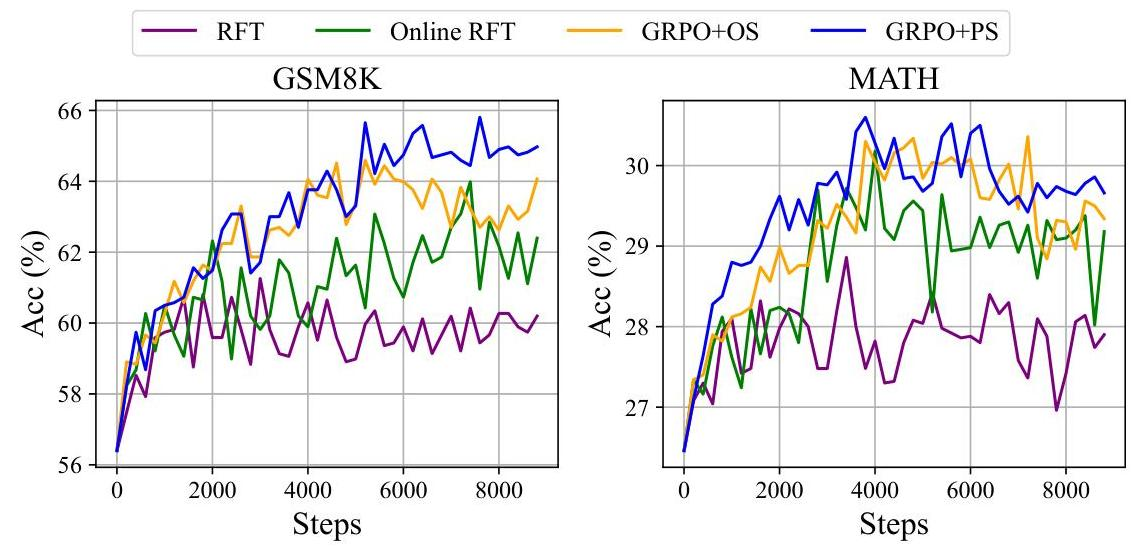

Figure 5 | Performance of the DeepSeekMath-Instruct 1.3B model, which was further trained using various methods, on two benchmarks.

- Rejection Sampling Fine-tuning (RFT): RFT further fine-tunes the SFT model on the filtered outputs sampled from the SFT model based on SFT questions. RFT filters the outputs based on the correctness of their answers.
- Direct Preference Optimization (DPO): DPO further refines the SFT model by fine-tuning it on augmented outputs sampled from the SFT model, using pair-wise DPO loss.
- Online Rejection Sampling Fine-tuning (Online RFT): Different from RFT, Online RFT initiates the policy model using the SFT model and refines it by fine-tuning with the augmented outputs sampled from the real-time policy model.
- PPO/GRPO: PPO/GRPO initializes the policy model using the SFT model and reinforces it with the outputs sampled from the real-time policy model.

We summarize the components of these methods in Table 10. Please refer to Appendix A. 1 for a more detailed derivation process.

Observation about Data Source We divide the data source into two categories, online sampling, and offline sampling. Online sampling denotes that the training data is from the exploration results of the real-time training policy model, while offline sampling denotes that the

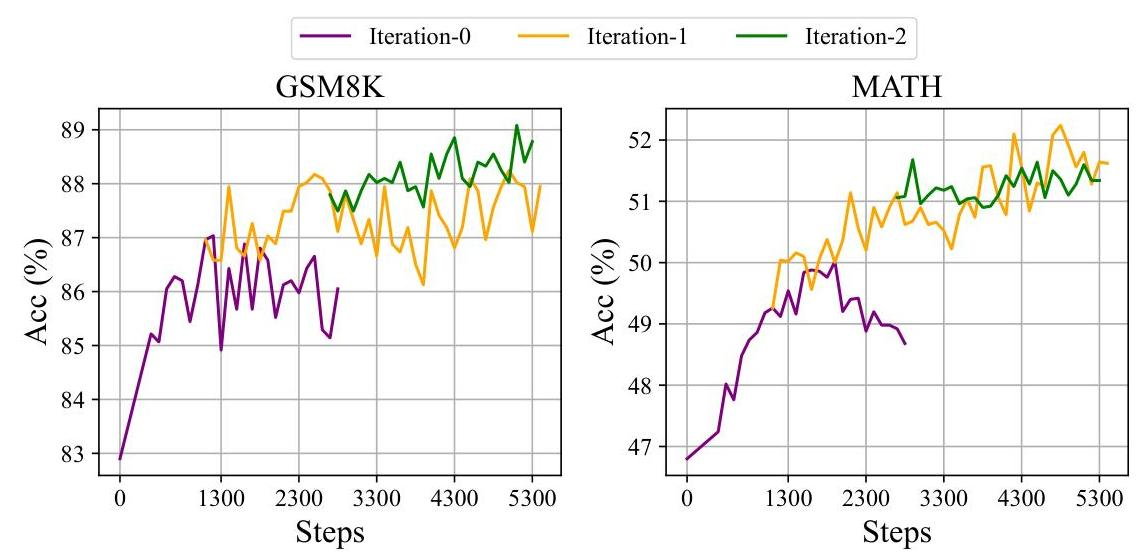

Figure 6 | Performance of iterative reinforcement learning with DeepSeekMath-Instruct 7B on two benchmarks.
training data is from the sampling results of the initial SFT model. RFT and DPO follow the offline style, while Online RFT and GRPO follow the online style.

As shown in Figure 5, we find that the Online RFT significantly outperforms RFT on two benchmarks. Specifically, Online RFT is comparable to RFT in the early stage of training but gains an absolute advantage in the later stage, demonstrating the superiority of online training. This is intuitive, as in the initial stage, the actor and the SFT model exhibit close resemblance, with the sampled data revealing only minor differences. In the later stage, however, the data sampled from the actor will exhibit more significant differences, and real-time data sampling will offer greater advantages.

Observation about Gradient Coefficient The algorithm processes the reward signal to the gradient coefficient to update the model parameter. We divide the reward function as 'Rule' and 'Model' in our experiments. Rule refers to judging the quality of a response based on the correctness of the answer, and Model denotes that we train a reward model to score each response. The training data of the reward model is based on the rule judgment. Equations 10 and 21 highlight a key difference between GRPO and Online RFT: GRPO uniquely adjusts its gradient coefficient based on the reward value provided by the reward model. This allows for differential reinforcement and penalization of responses according to their varying magnitudes. In contrast, Online RFT lacks this feature; it does not penalize incorrect responses and uniformly reinforces all responses with correct answers at the same level of intensity.

As demonstrated in Figure 5, GRPO surpasses online RFT, thereby highlighting the efficiency of altering positive and negative gradient coefficients. In addition, GRPO+PS shows superior performance compared to GRPO+OS, indicating the benefits of using fine-grained, step-aware gradient coefficients. Furthermore, we explore the iterative RL, in our experiments, we conduct two rounds of iteration. As shown in Figure 6, we notice that the iterative RL significantly improves the performance, especially at the first iteration.

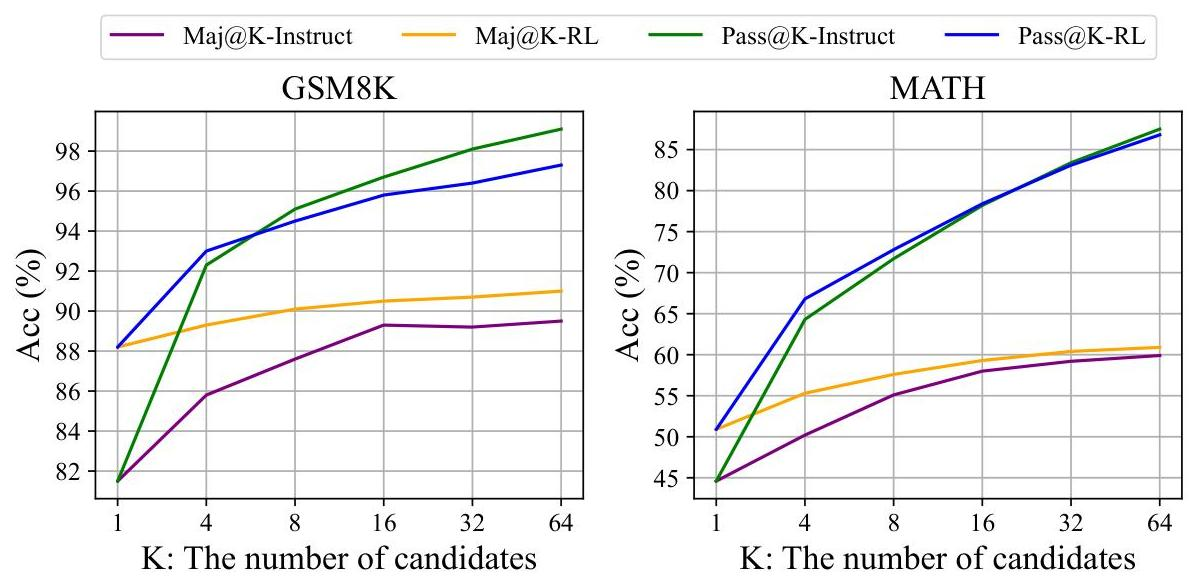

Figure 7 | The Maj@K and Pass@K of SFT and RL DeepSeekMath 7B on GSM8K and MATH (temperature 0.7). It was noted that RL enhances Maj@K but not Pass@K.

# 5.2.2. Why RL Works? 

In this paper, we conduct reinforcement learning based on a subset of instruction tuning data, and it achieves significant performance enhancement upon the instruction tuning model. To further explain why reinforcement learning works. We evaluate the Pass@K and Maj@K accuracy of the Instruct and RL models on two benchmarks. As shown in Figure 7, RL enhances Maj@K's performance but not Pass@K. These findings indicate that RL enhances the model's overall performance by rendering the output distribution more robust, in other words, it seems that the improvement is attributed to boosting the correct response from TopK rather than the enhancement of fundamental capabilities. Similarly, (Wang et al., 2023a) identified a misalignment problem in reasoning tasks within the SFT model, showing that the reasoning performance of SFT models can be improved through a series of preference alignment strategies (Song et al., 2023; Wang et al., 2023a; Yuan et al., 2023b).

### 5.2.3. How to Achieve More Effective RL?

We demonstrate RL works pretty well in mathematical reasoning tasks. We also provide a unified paradigm to understand different representative training methods. Within this paradigm, all methods are conceptualized as either direct or simplified RL techniques. As summarized in Equation 5, there exist three key components: Data Source, Algorithm, and Reward Function. We provide some potential future directions about the three components.

Data Source Data source is the raw material of all training methods. In the context of RL, we specifically refer to the data source as the unlabeled questions with the outputs sampled from the policy model. In this paper, we only use the questions from the instruction tuning stage and a naive nucleus sampling to sample outputs. We think this is a potential reason that our RL pipeline only improves the Maj@K performance. In the future, we will explore our RL pipeline on out-of-distribution question prompts, in conjunction with advanced sampling (decoding) strategies, like those based on tree-search methods (Yao et al., 2023). Also, the efficient inference techniques (Kwon et al., 2023; Leviathan et al., 2023; Xia et al., 2023, 2024), which determines

the exploration efficiency of policy models, also play an exceedingly important role.

Algorithms Algorithms process the data and reward signal to the gradient coefficient to update the model parameter. Based on Equation 5, to some extent, all methods now fully TRUST the signal of the reward function to increase or decrease the conditional probability of a certain token. However, it is impossible to ensure the reward signal is always reliable, especially in extremely complex tasks. For example, even the PRM800K datasets (Lightman et al., 2023), which have been carefully annotated by well-trained annotators, still contain approximately $20 \%$ of incorrectly annotations ${ }^{7}$. To this end, we will explore the reinforcement learning algorithm that is robust against noisy reward signals. We believe such WEAK-TO-STRONG (Burns et al., 2023) alignment methods will bring a fundamental change to the learning algorithms.

Reward Function Reward function is the source of the training signal. In RL, the reward function is usually the neural reward model. We think there exist three important directions for reward models: 1) How to enhance the generalization ability of the reward model. The reward model must be effectively generalized to handle out-of-distribution questions and advanced decoding outputs; otherwise, reinforcement learning may merely stabilize the distribution of LLMs rather than improve their fundamental capabilities; 2) How to reflect the uncertainty of reward model. The uncertainty could potentially act as a linking bridge between the weak reward model and the weak-to-strong learning algorithms; 3) How to efficiently build highquality process reward models that can provide fine-grained training signals for the reasoning process (Lightman et al., 2023; Wang et al., 2023b).

# 6. Conclusion, Limitation, and Future Work 

We present DeepSeekMath, which outperforms all open-source models on the competitionlevel MATH benchmark and approaches the performance of closed models. DeepSeekMath is initialized with DeepSeek-Coder-v1.5 7B and undergoes continual training for 500B tokens, with a significant component of the training data being 120B math tokens sourced from Common Crawl. Our extensive ablation study shows web pages offer significant potential for high-quality mathematical data, while arXiv may not as beneficial as we expected. We introduce Group Relative Policy Optimization (GRPO), a variant of Proximal Policy Optimization (PPO), which can notably improve mathematical reasoning capabilities with less memory consumption. The experiment results show that GRPO is effective even if DeepSeekMath-Instruct 7B has reached a high score on benchmarks. We also provide a unified paradigm to understand a series of methods and summarize several potential directions for more effective reinforcement learning.

Although DeepSeekMath achieves impressive scores on quantitative reasoning benchmarks, its capability on geometry and theorem-proof are relatively weaker than closed models. For instance, in our dry run, the model cannot handle problems related to triangles and ellipses, which may indicate data selection bias in pre-training and fine-tuning. In addition, restricted by the model scale, DeepSeekMath is worse than GPT-4 on few-shot capability. GPT-4 could improve its performance with few-shot inputs, while DeepSeekMath shows similar performance in zero-shot and few-shot evaluation. In the future, we will further improve our engineered data selection pipeline to construct more high-quality pre-trained corpus. In addition, we will explore the potential directions (Section 5.2.3) for more effective reinforcement learning of LLMs.

[^0]
[^0]:    ${ }^{7}$ https://github.com/openai/prm800k/issues/12\#issuecomment-1728491852

# References 

R. Anil, S. Borgeaud, Y. Wu, J. Alayrac, J. Yu, R. Soricut, J. Schalkwyk, A. M. Dai, A. Hauth, K. Millican, D. Silver, S. Petrov, M. Johnson, I. Antonoglou, J. Schrittwieser, A. Glaese, J. Chen, E. Pitler, T. P. Lillicrap, A. Lazaridou, O. Firat, J. Molloy, M. Isard, P. R. Barham, T. Hennigan, B. Lee, F. Viola, M. Reynolds, Y. Xu, R. Doherty, E. Collins, C. Meyer, E. Rutherford, E. Moreira, K. Ayoub, M. Goel, G. Tucker, E. Piqueras, M. Krikun, I. Barr, N. Savinov, I. Danihelka, B. Roelofs, A. White, A. Andreassen, T. von Glehn, L. Yagati, M. Kazemi, L. Gonzalez, M. Khalman, J. Sygnowski, and et al. Gemini: A family of highly capable multimodal models. CoRR, abs/2312.11805, 2023. doi: 10.48550/ARXIV.2312.11805. URL https: //doi.org/10.48550/arXiv.2312.11805.
J. Austin, A. Odena, M. Nye, M. Bosma, H. Michalewski, D. Dohan, E. Jiang, C. Cai, M. Terry, Q. Le, et al. Program synthesis with large language models. arXiv preprint arXiv:2108.07732, 2021.
Z. Azerbayev, H. Schoelkopf, K. Paster, M. D. Santos, S. McAleer, A. Q. Jiang, J. Deng, S. Biderman, and S. Welleck. Llemma: An open language model for mathematics. arXiv preprint arXiv:2310.10631, 2023.
J. Bai, S. Bai, Y. Chu, Z. Cui, K. Dang, X. Deng, Y. Fan, W. Ge, Y. Han, F. Huang, et al. Qwen technical report. arXiv preprint arXiv:2309.16609, 2023.
C. Burns, P. Izmailov, J. H. Kirchner, B. Baker, L. Gao, L. Aschenbrenner, Y. Chen, A. Ecoffet, M. Joglekar, J. Leike, et al. Weak-to-strong generalization: Eliciting strong capabilities with weak supervision. arXiv preprint arXiv:2312.09390, 2023.

ChatGLM3 Team. Chatglm3 series: Open bilingual chat llms, 2023. URL https://github.c om/THUDM/ChatGLM3.
M. Chen, J. Tworek, H. Jun, Q. Yuan, H. P. de Oliveira Pinto, J. Kaplan, H. Edwards, Y. Burda, N. Joseph, G. Brockman, A. Ray, R. Puri, G. Krueger, M. Petrov, H. Khlaaf, G. Sastry, P. Mishkin, B. Chan, S. Gray, N. Ryder, M. Pavlov, A. Power, L. Kaiser, M. Bavarian, C. Winter, P. Tillet, F. P. Such, D. Cummings, M. Plappert, F. Chantzis, E. Barnes, A. Herbert-Voss, W. H. Guss, A. Nichol, A. Paino, N. Tezak, J. Tang, I. Babuschkin, S. Balaji, S. Jain, W. Saunders, C. Hesse, A. N. Carr, J. Leike, J. Achiam, V. Misra, E. Morikawa, A. Radford, M. Knight, M. Brundage, M. Murati, K. Mayer, P. Welinder, B. McGrew, D. Amodei, S. McCandlish, I. Sutskever, and W. Zaremba. Evaluating large language models trained on code. CoRR, abs/2107.03374, 2021. URL https://arxiv.org/abs/2107.03374.
W. Chen, X. Ma, X. Wang, and W. W. Cohen. Program of thoughts prompting: Disentangling computation from reasoning for numerical reasoning tasks. CoRR, abs/2211.12588, 2022. doi: 10.48550/ARXIV.2211.12588. URL https://doi.org/10.48550/arXiv.2211.12588.
K. Cobbe, V. Kosaraju, M. Bavarian, M. Chen, H. Jun, L. Kaiser, M. Plappert, J. Tworek, J. Hilton, R. Nakano, et al. Training verifiers to solve math word problems. arXiv preprint arXiv:2110.14168, 2021.
T. Computer. Redpajama: an open dataset for training large language models, Oct. 2023. URL https://github.com/togethercomputer/RedPajama-Data.

DeepSeek-AI. Deepseek LLM: scaling open-source language models with longtermism. CoRR, abs/2401.02954, 2024. doi: 10.48550/ARXIV.2401.02954. URL https://doi.org/10.485 50/arXiv. 2401.02954.

Z. Du, Y. Qian, X. Liu, M. Ding, J. Qiu, Z. Yang, and J. Tang. Glm: General language model pretraining with autoregressive blank infilling. In Proceedings of the 60th Annual Meeting of the Association for Computational Linguistics (Volume 1: Long Papers), pages 320-335, 2022.
L. Gao, A. Madaan, S. Zhou, U. Alon, P. Liu, Y. Yang, J. Callan, and G. Neubig. PAL: programaided language models. In A. Krause, E. Brunskill, K. Cho, B. Engelhardt, S. Sabato, and J. Scarlett, editors, International Conference on Machine Learning, ICML 2023, 23-29 July 2023, Honolulu, Hawaii, USA, volume 202 of Proceedings of Machine Learning Research, pages 10764-10799. PMLR, 2023. URL https://proceedings.mlr.press/v202/gao23f. html.
Z. Gou, Z. Shao, Y. Gong, Y. Shen, Y. Yang, M. Huang, N. Duan, and W. Chen. Tora: A toolintegrated reasoning agent for mathematical problem solving. CoRR, abs/2309.17452, 2023. doi: 10.48550/ARXIV.2309.17452. URL https://doi.org/10.48550/arXiv.2309.1745 2.
D. Guo, Q. Zhu, D. Yang, Z. Xie, K. Dong, W. Zhang, G. Chen, X. Bi, Y. Wu, Y. K. Li, F. Luo, Y. Xiong, and W. Liang. Deepseek-coder: When the large language model meets programming - the rise of code intelligence, 2024.
D. Hendrycks, C. Burns, S. Basart, A. Zou, M. Mazeika, D. Song, and J. Steinhardt. Measuring massive multitask language understanding. arXiv preprint arXiv:2009.03300, 2020.
D. Hendrycks, C. Burns, S. Kadavath, A. Arora, S. Basart, E. Tang, D. Song, and J. Steinhardt. Measuring mathematical problem solving with the math dataset. arXiv preprint arXiv:2103.03874, 2021.

High-flyer. Hai-llm: 高效且轻量的大模型训练工具, 2023. URL https://www.high-flyer.c n/en/blog/hai-1lm.

Inflection AI. Inflection-2, 2023. URL https://inflection.ai/inflection-2.
A. Q. Jiang, S. Welleck, J. P. Zhou, W. Li, J. Liu, M. Jamnik, T. Lacroix, Y. Wu, and G. Lample. Draft, sketch, and prove: Guiding formal theorem provers with informal proofs. arXiv preprint arXiv:2210.12283, 2022.
A. Q. Jiang, A. Sablayrolles, A. Mensch, C. Bamford, D. S. Chaplot, D. d. I. Casas, F. Bressand, G. Lengyel, G. Lample, L. Saulnier, et al. Mistral 7b. arXiv preprint arXiv:2310.06825, 2023.
A. Joulin, E. Grave, P. Bojanowski, M. Douze, H. Jégou, and T. Mikolov. Fasttext. zip: Compressing text classification models. arXiv preprint arXiv:1612.03651, 2016.
W. Kwon, Z. Li, S. Zhuang, Y. Sheng, L. Zheng, C. H. Yu, J. E. Gonzalez, H. Zhang, and I. Stoica. Efficient memory management for large language model serving with pagedattention. In Proceedings of the ACM SIGOPS 29th Symposium on Operating Systems Principles, 2023.
Y. Leviathan, M. Kalman, and Y. Matias. Fast inference from transformers via speculative decoding. In International Conference on Machine Learning, pages 19274-19286. PMLR, 2023.
A. Lewkowycz, A. Andreassen, D. Dohan, E. Dyer, H. Michalewski, V. Ramasesh, A. Slone, C. Anil, I. Schlag, T. Gutman-Solo, et al. Solving quantitative reasoning problems with language models. Advances in Neural Information Processing Systems, 35:3843-3857, 2022a.

A. Lewkowycz, A. Andreassen, D. Dohan, E. Dyer, H. Michalewski, V. V. Ramasesh, A. Slone, C. Anil, I. Schlag, T. Gutman-Solo, Y. Wu, B. Neyshabur, G. Gur-Ari, and V. Misra. Solving quantitative reasoning problems with language models. In S. Koyejo, S. Mohamed, A. Agarwal, D. Belgrave, K. Cho, and A. Oh, editors, Advances in Neural Information Processing Systems 35: Annual Conference on Neural Information Processing Systems 2022, NeurIPS 2022, New Orleans, LA, USA, November 28 - December 9, 2022, 2022b. URL http://papers.nips. cc/paper_files/paper/2022/hash/18abbeef8cfe9203fdf9053c9c4fe191-Abstr act-Conference.html.
H. Lightman, V. Kosaraju, Y. Burda, H. Edwards, B. Baker, T. Lee, J. Leike, J. Schulman, I. Sutskever, and K. Cobbe. Let's verify step by step. arXiv preprint arXiv:2305.20050, 2023.
I. Loshchilov and F. Hutter. Decoupled weight decay regularization. arXiv preprint arXiv:1711.05101, 2017.
H. Luo, Q. Sun, C. Xu, P. Zhao, J. Lou, C. Tao, X. Geng, Q. Lin, S. Chen, and D. Zhang. Wizardmath: Empowering mathematical reasoning for large language models via reinforced evol-instruct. arXiv preprint arXiv:2308.09583, 2023.
S. Mishra, M. Finlayson, P. Lu, L. Tang, S. Welleck, C. Baral, T. Rajpurohit, O. Tafjord, A. Sabharwal, P. Clark, and A. Kalyan. LILA: A unified benchmark for mathematical reasoning. In Y. Goldberg, Z. Kozareva, and Y. Zhang, editors, Proceedings of the 2022 Conference on Empirical Methods in Natural Language Processing, EMNLP 2022, Abu Dhabi, United Arab Emirates, December 7-11, 2022, pages 5807-5832. Association for Computational Linguistics, 2022. doi: 10.18653/V1/2022.EMNLP-MAIN.392. URL https://doi.org/10.18653/v1/ 2022.emnlp-main.392.
X. Nguyen, W. Zhang, X. Li, M. M. Aljunied, Q. Tan, L. Cheng, G. Chen, Y. Deng, S. Yang, C. Liu, H. Zhang, and L. Bing. Seallms - large language models for southeast asia. CoRR, abs/2312.00738, 2023. doi: 10.48550/ARXIV.2312.00738. URL https://doi.org/10.485 50/arXiv. 2312.00738.

OpenAI. GPT4 technical report. arXiv preprint arXiv:2303.08774, 2023.
L. Ouyang, J. Wu, X. Jiang, D. Almeida, C. Wainwright, P. Mishkin, C. Zhang, S. Agarwal, K. Slama, A. Ray, et al. Training language models to follow instructions with human feedback. Advances in Neural Information Processing Systems, 35:27730-27744, 2022.
K. Paster, M. D. Santos, Z. Azerbayev, and J. Ba. Openwebmath: An open dataset of high-quality mathematical web text. CoRR, abs/2310.06786, 2023. doi: 10.48550/ARXIV.2310.06786. URL https://doi.org/10.48550/arXiv.2310.06786.
L. C. Paulson. Three years of experience with sledgehammer, a practical link between automatic and interactive theorem provers. In R. A. Schmidt, S. Schulz, and B. Konev, editors, Proceedings of the 2nd Workshop on Practical Aspects of Automated Reasoning, PAAR-2010, Edinburgh, Scotland, UK, July 14, 2010, volume 9 of EPiC Series in Computing, pages 1-10. EasyChair, 2010. doi: 10.29007/TNFD. URL https://doi.org/10.29007/tnfd.
S. Polu and I. Sutskever. Generative language modeling for automated theorem proving. CoRR, abs/2009.03393, 2020. URL https://arxiv.org/abs/2009.03393.
R. Rafailov, A. Sharma, E. Mitchell, S. Ermon, C. D. Manning, and C. Finn. Direct preference optimization: Your language model is secretly a reward model. 2023.

J. Schulman. Approximating kl divergence, 2020. URL http://joschu.net/blog/kl-app rox.html.
J. Schulman, P. Moritz, S. Levine, M. Jordan, and P. Abbeel. High-dimensional continuous control using generalized advantage estimation. arXiv preprint arXiv:1506.02438, 2015.
J. Schulman, F. Wolski, P. Dhariwal, A. Radford, and O. Klimov. Proximal policy optimization algorithms. arXiv preprint arXiv:1707.06347, 2017.
F. Shi, M. Suzgun, M. Freitag, X. Wang, S. Srivats, S. Vosoughi, H. W. Chung, Y. Tay, S. Ruder, D. Zhou, D. Das, and J. Wei. Language models are multilingual chain-of-thought reasoners. In The Eleventh International Conference on Learning Representations, ICLR 2023, Kigali, Rwanda, May 1-5, 2023. OpenReview.net, 2023. URL https://openreview.net/pdf?id= fR3wGCk-IXp.
F. Song, B. Yu, M. Li, H. Yu, F. Huang, Y. Li, and H. Wang. Preference ranking optimization for human alignment. arXiv preprint arXiv:2306.17492, 2023.
M. Suzgun, N. Scales, N. Schärli, S. Gehrmann, Y. Tay, H. W. Chung, A. Chowdhery, Q. V. Le, E. H. Chi, D. Zhou, et al. Challenging big-bench tasks and whether chain-of-thought can solve them. arXiv preprint arXiv:2210.09261, 2022.
T. Tao. Embracing change and resetting expectations, 2023. URL https://unlocked.micro soft.com/ai-anthology/terence-tao/.
H. Touvron, L. Martin, K. Stone, P. Albert, A. Almahairi, Y. Babaei, N. Bashlykov, S. Batra, P. Bhargava, S. Bhosale, D. Bikel, L. Blecher, C. Canton-Ferrer, M. Chen, G. Cucurull, D. Esiobu, J. Fernandes, J. Fu, W. Fu, B. Fuller, C. Gao, V. Goswami, N. Goyal, A. Hartshorn, S. Hosseini, R. Hou, H. Inan, M. Kardas, V. Kerkez, M. Khabsa, I. Kloumann, A. Korenev, P. S. Koura, M. Lachaux, T. Lavril, J. Lee, D. Liskovich, Y. Lu, Y. Mao, X. Martinet, T. Mihaylov, P. Mishra, I. Molybog, Y. Nie, A. Poulton, J. Reizenstein, R. Rungta, K. Saladi, A. Schelten, R. Silva, E. M. Smith, R. Subramanian, X. E. Tan, B. Tang, R. Taylor, A. Williams, J. X. Kuan, P. Xu, Z. Yan, I. Zarov, Y. Zhang, A. Fan, M. Kambadur, S. Narang, A. Rodriguez, R. Stojnic, S. Edunov, and T. Scialom. Llama 2: Open foundation and fine-tuned chat models. CoRR, abs/2307.09288, 2023. doi: 10.48550/arXiv.2307.09288. URL https://doi.org/10.48550/arXiv.2307. 09288 .
T. H. Trinh, Y. Wu, Q. V. Le, H. He, and T. Luong. Solving olympiad geometry without human demonstrations. Nature, 625(7995):476-482, 2024.
P. Wang, L. Li, L. Chen, F. Song, B. Lin, Y. Cao, T. Liu, and Z. Sui. Making large language models better reasoners with alignment. arXiv preprint arXiv:2309.02144, 2023a.
P. Wang, L. Li, Z. Shao, R. Xu, D. Dai, Y. Li, D. Chen, Y. Wu, and Z. Sui. Math-shepherd: Verify and reinforce llms step-by-step without human annotations. CoRR, abs/2312.08935, 2023b.
Z. Wang, R. Xia, and P. Liu. Generative AI for math: Part I - mathpile: A billion-token-scale pretraining corpus for math. CoRR, abs/2312.17120, 2023c. doi: 10.48550/ARXIV.2312.17120. URL https://doi.org/10.48550/arXiv.2312.17120.
J. Wei, X. Wang, D. Schuurmans, M. Bosma, B. Ichter, F. Xia, E. H. Chi, Q. V. Le, and D. Zhou. Chain-of-thought prompting elicits reasoning in large language models. In NeurIPS, 2022. URL http://papers.nips.cc/paper_files/paper/2022/hash/9d5609613524ecf 4f15af0f7b31abca4-Abstract-Conference.html.

T. Wei, J. Luan, W. Liu, S. Dong, and B. Wang. Cmath: Can your language model pass chinese elementary school math test?, 2023.
M. Wenzel, L. C. Paulson, and T. Nipkow. The isabelle framework. In O. A. Mohamed, C. A. Muñoz, and S. Tahar, editors, Theorem Proving in Higher Order Logics, 21st International Conference, TPHOLs 2008, Montreal, Canada, August 18-21, 2008. Proceedings, volume 5170 of Lecture Notes in Computer Science, pages 33-38. Springer, 2008. doi: 10.1007/978-3-540-7 1067-7 7. URL https://doi.org/10.1007/978-3-540-71067-7_7.
H. Xia, T. Ge, P. Wang, S.-Q. Chen, F. Wei, and Z. Sui. Speculative decoding: Exploiting speculative execution for accelerating seq2seq generation. In H. Bouamor, J. Pino, and K. Bali, editors, Findings of the Association for Computational Linguistics: EMNLP 2023, pages 39093925, Singapore, Dec. 2023. Association for Computational Linguistics. doi: 10.18653/v1/20 23.findings-emnlp.257. URL https://aclanthology.org/2023.findings-emnlp. 257.
H. Xia, Z. Yang, Q. Dong, P. Wang, Y. Li, T. Ge, T. Liu, W. Li, and Z. Sui. Unlocking efficiency in large language model inference: A comprehensive survey of speculative decoding. arXiv preprint arXiv:2401.07851, 2024.
S. Yao, D. Yu, J. Zhao, I. Shafran, T. L. Griffiths, Y. Cao, and K. Narasimhan. Tree of thoughts: Deliberate problem solving with large language models. arXiv preprint arXiv:2305.10601, 2023.
L. Yu, W. Jiang, H. Shi, J. Yu, Z. Liu, Y. Zhang, J. T. Kwok, Z. Li, A. Weller, and W. Liu. Metamath: Bootstrap your own mathematical questions for large language models. CoRR, abs/2309.12284, 2023. doi: 10.48550/ARXIV.2309.12284. URL https://doi.org/10.485 50/arXiv. 2309.12284.
Z. Yuan, H. Yuan, C. Li, G. Dong, C. Tan, and C. Zhou. Scaling relationship on learning mathematical reasoning with large language models. arXiv preprint arXiv:2308.01825, 2023a.
Z. Yuan, H. Yuan, C. Tan, W. Wang, S. Huang, and F. Huang. Rrhf: Rank responses to align language models with human feedback without tears. arXiv preprint arXiv:2304.05302, 2023b.
X. Yue, X. Qu, G. Zhang, Y. Fu, W. Huang, H. Sun, Y. Su, and W. Chen. Mammoth: Building math generalist models through hybrid instruction tuning. CoRR, abs/2309.05653, 2023. doi: 10.48550/ARXIV.2309.05653. URL https://doi.org/10.48550/arXiv.2309.05653.
K. Zheng, J. M. Han, and S. Polu. Minif2f: a cross-system benchmark for formal olympiad-level mathematics. arXiv preprint arXiv:2109.00110, 2021.
W. Zhong, R. Cui, Y. Guo, Y. Liang, S. Lu, Y. Wang, A. Saied, W. Chen, and N. Duan. AGIEval: A human-centric benchmark for evaluating foundation models. CoRR, abs/2304.06364, 2023. doi: 10.48550/arXiv.2304.06364. URL https://doi.org/10.48550/arXiv.2304.06364.

# A. Appendix 

## A.1. Analysis of Reinforcement Learning

We provide the detailed derivation of the data source and gradient coefficient (algorithm and reward function) across various methods, including SFT, RFT, Online RFT, DPO, PPO, and GRPO.

## A.1.1. Supervised Fine-tuning

The objective of Supervised Fine-tuning is maximizing the following objective:

$$
\mathcal{J}_{S F T}(\theta)=\mathbb{E}\left[q, o \sim P_{s f t}(Q, O)\right]\left(\frac{1}{|o|} \sum_{t=1}^{|o|}\left.\log \pi_{\theta}\left(o_{t} \mid q, o_{<t}\right)\right)\right.
$$

The gradient of $\mathcal{J}_{S F T}(\theta)$ is:

$$
\nabla_{\theta} \mathcal{J}_{S F T}=\mathbb{E}\left[q, o \sim P_{s f t}(Q, O)\right]\left(\frac{1}{|o|} \sum_{t=1}^{|o|} \nabla_{\theta} \log \pi_{\theta}\left(o_{t} \mid q, o_{<t}\right)\right)
$$

Data Source: The dataset employed for SFT. Reward Function: This can be regarded as human selection. Gradient Coefficient: always set to 1.

## A.1.2. Rejection Sampling Fine-tuning

Rejection Sampling Fine-tuning first samples multiple outputs from the supervised fine-tuned LLMs for each question, and then trains LLMs on the sampled outputs with the correct answer. Formally, the objective of RFT is to maximize the following objectives:

$$
\mathcal{J}_{R F T}(\theta)=\mathbb{E}\left[q \sim P_{s f t}(Q), o \sim \pi_{s f t}(O \mid q)\right]\left(\frac{1}{|o|} \sum_{t=1}^{|o|} \mathbb{I}(o) \log \pi_{\theta}\left(o_{t} \mid q, o_{<t}\right)\right)
$$

The gradient of $\mathcal{J}_{R F T}(\theta)$ is:

$$
\nabla_{\theta} \mathcal{J}_{R F T}(\theta)=\mathbb{E}\left[q \sim P_{s f t}(Q), o \sim \pi_{s f t}(O \mid q)\right]\left(\frac{1}{|o|} \sum_{t=1}^{|o|} \mathbb{I}(o) \nabla_{\theta} \log \pi_{\theta}\left(o_{t} \mid q, o_{<t}\right)\right)
$$

Data Source: question in SFT dataset with outputs sampled from SFT model. Reward Function: Rule (whether the answer is correct or not). Gradient Coefficient:

$$
G C_{R F T}(q, o, t)=\mathbb{I}(o)= \begin{cases}1 & \text { the answer of } o \text { is correct } \\ 0 & \text { the answer of } o \text { is incorrect }\end{cases}
$$

## A.1.3. Online Rejection Sampling Fine-tuning

The only difference between RFT and Online RFT is that the outputs of Online RFT are sampled from the real-time policy model $\pi_{\theta}$, rather than from the SFT model $\pi_{\theta_{s f t}}$. Therefore, the gradient of online RFT is:

$$
\nabla_{\theta} \mathcal{J}_{O n R F T}(\theta)=\mathbb{E}\left[q \sim P_{s f t}(Q), o \sim \pi_{\theta}(O \mid q)\right]\left(\frac{1}{|o|} \sum_{t=1}^{|o|} \mathbb{I}(o) \nabla_{\theta} \log \pi_{\theta}\left(o_{t} \mid q, o_{<t}\right)\right)
$$

# A.1.4. Direct Preference Optimization (DPO) 

The objective of DPO is:

$$
\mathcal{J}_{D P O}(\theta)=\mathbb{E}\left[q \sim P_{x f t}(Q), o^{+}, o^{-} \sim \pi_{x f t}(O \mid q)\right] \log \sigma\left(\beta \frac{1}{\left|o^{+}\right|} \sum_{i=1}^{\left|o^{-}\right|} \log \frac{\pi_{\theta}\left(o_{t}^{*}\left|q, o_{<t}^{*}\right\rangle}{\pi_{\text {ref }}\left(o_{t}^{*}\left|q, o_{<t}^{*}\right\rangle\right.}-\beta \frac{1}{\left|o^{-}\right|} \sum_{i=1}^{\left|o^{-}\right|} \log \frac{\pi_{\theta}\left(o_{<t}^{*}\left|q, o_{<t}^{*}\right\rangle}{\pi_{\text {ref }}\left(o_{<t}^{*}\left|q, o_{<t}^{*}\right\rangle\right)}\right)
$$

The gradient of $\mathcal{J}_{D P O}(\theta)$ is:

$$
\begin{aligned}
\nabla_{\theta} \mathcal{J}_{D P O}(\theta)=\mathbb{E}\left[q \sim P_{x f t}(Q), o^{+}, o^{-} \sim \pi_{x f t}(O \mid q)\right] & \left(\frac{1}{\left|o^{+}\right|} \sum_{i=1}^{\left|o^{+}\right|} G C_{D P O}(q, o, t) \nabla_{\theta} \log \pi_{\theta}\left(o_{t}^{*}\left|q, o_{<t}^{*}\right\rangle\right.\right. \\
& \left.\sim \frac{1}{\left|o^{-}\right|} \sum_{t=1}^{\left|o^{-}\right|} G C_{D P O}(q, o, t) \nabla_{\theta} \log \pi_{\theta}\left(o_{t}^{-}\left|q, o_{<t}^{-}\right\rangle\right)\right)
\end{aligned}
$$

Data Source: question in SFT dataset with outputs sampled from SFT model. Reward Function: human preference in the general domain (can be 'Rule' in mathematical tasks). Gradient Coefficient:

$$
G C_{D P O}(q, o, t)=\sigma\left(\beta \log \frac{\pi_{\theta}\left(o_{t}^{-}\left|q, o_{<t}^{-}\right\rangle\right.}{\pi_{\text {ref }}\left(o_{t}^{-}\left|q, o_{<t}^{-}\right\rangle\right.}-\beta \log \frac{\pi_{\theta}\left(o_{t}^{*}\left|q, o_{<t}^{*}\right\rangle}{\pi_{\text {ref }}\left(o_{t}^{*}\left|q, o_{<t}^{*}\right\rangle\right)}\right)
$$

## A.1.5. Proximal Policy Optimization (PPO)

The objective of PPO is:

$$
\mathcal{J}_{P P O}(\theta)=\mathbb{E}\left[q \sim P_{x f t}(Q), o \sim \pi_{\theta_{A l d}}(O \mid q)\right] \frac{1}{\left|o\right|} \sum_{i=1}^{\left|o\right|} \min \left[\frac{\pi_{\theta}\left(o_{t}\left|q, o_{<t}\right\rangle\right)}{\pi_{\theta_{A l d}}\left(o_{t}\left|q, o_{<t}\right\rangle\right)} A_{t}, \operatorname{clip}\left(\frac{\pi_{\theta}\left(o_{t}\left|q, o_{<t}\right\rangle\right)}{\pi_{\theta_{A l d}}\left(o_{t}\left|q, o_{<t}\right\rangle\right)}, 1-\varepsilon, 1+\varepsilon\right) A_{t}\right]
$$

To simplify the analysis, it is assumed that the model only has a single update following each exploration stage, thereby ensuring that $\pi_{\theta_{A l d}}=\pi_{\theta}$. In this case, we can remove the min and clip operation:

$$
\mathcal{J}_{P P O}(\theta)=\mathbb{E}\left[q \sim P_{x f t}(Q), o \sim \pi_{\theta_{A l d}}(O \mid q)\right] \frac{1}{\left|o\right|} \sum_{i=1}^{\left|o\right|} \frac{\pi_{\theta}\left(o_{t}\left|q, o_{<t}\right\rangle\right)}{\pi_{\theta_{A l d}}\left(o_{t}\left|q, o_{<t}\right\rangle\right)} A_{t}
$$

The gradient of $\mathcal{J}_{P P O}(\theta)$ is:

$$
\nabla_{\theta} \mathcal{J}_{P P O}(\theta)=\mathbb{E}\left[q \sim P_{x f t}(Q), o \sim \pi_{\theta_{A l d}}(O \mid q)\right] \frac{1}{\left|o\right|} \sum_{i=1}^{\left|o\right|} A_{t} \nabla_{\theta} \log \pi_{\theta}\left(o_{t}\left|q, o_{<t}\right\rangle\right.
$$

Data Source: question in SFT dataset with outputs sampled from policy model. Reward Function: reward model. Gradient Coefficient:

$$
G C_{P P O}\left(q, o, t, \pi_{\theta_{r m}}\right)=A_{t}
$$

where $A_{t}$ is the advantage, which is computed by applying Generalized Advantage Estimation (GAE) (Schulman et al., 2015), based on the rewards $\left\{r_{\geq t}\right\}$ and a learned value function $V_{\psi}$.

## A.1.6. Group Relative Policy Optimization (GRPO)

The objective of GRPO is (assume $\pi_{\theta_{A l d}}=\pi_{\theta}$ for simplified analysis):

$$
\begin{aligned}
\mathcal{J}_{G R P O}(\theta) & =\mathbb{E}\left[q \sim P_{x f t}(Q),\left\{o_{i}\right\}_{i=1}^{G} \sim \pi_{\theta_{A l d}}(O \mid q)\right] \\
\frac{1}{G} & \sum_{i=1}^{G} \frac{1}{\left|o_{i}\right|} \sum_{i=1}^{\left|o_{i}\right|} \frac{\pi_{\theta}\left(o_{i, t}\left|q, o_{i,<t}\right\rangle\right)}{\pi_{\theta_{A l d}}\left(o_{i, t}\left|q, o_{i,<t}\right\rangle\right)} \hat{A}_{i, t}-\beta\left(\frac{\pi_{r e f}\left(o_{i, t}\left|q, o_{i,<t}\right\rangle\right)}{\pi_{\theta}\left(o_{i, t}\left|q, o_{i,<t}\right\rangle\right.}-\log \frac{\pi_{r e f}\left(o_{i, t}\left|q, o_{i,<t}\right\rangle\right)}{\pi_{\theta}\left(o_{i, t}\left|q, o_{i,<t}\right\rangle\right.}-1)\right]
\end{aligned}
$$

The gradient of $\mathcal{F}_{G R P O}(\theta)$ is:

$$
\begin{aligned}
\nabla_{\theta} \mathcal{F}_{G R P O}(\theta) & =\mathbb{E}\left[q \sim P_{c f t}(Q),\left\{o_{i}\right\}_{i=1}^{G} \sim \pi_{\theta_{c o t}}(O \mid q)\right] \\
& \frac{1}{G} \sum_{i=1}^{G} \frac{1}{\left|o_{i}\right|} \sum_{t=1}^{\left|o_{i}\right|}\left[\hat{A}_{i, t}+\beta\left(\frac{\pi_{r e f}\left(o_{i, t} \mid o_{i, c t}\right)}{\pi_{\theta}\left(o_{i, t} \mid o_{i, c t}\right)}-1\right)\right] \nabla_{\theta} \log \pi_{\theta}\left(o_{i, t} \mid q, o_{i, c t}\right)
\end{aligned}
$$

Data Source: question in SFT dataset with outputs sampled from policy model. Reward Function: reward model. Gradient Coefficient:

$$
G C_{G R P O}\left(q, o, t, \pi_{\theta_{c o t}}\right)=\hat{A}_{i, t}+\beta\left(\frac{\pi_{r e f}\left(o_{i, t} \mid o_{i, c t}\right)}{\pi_{\theta}\left(o_{i, t} \mid o_{i, c t}\right)}-1\right)
$$

where $\hat{A}_{i, t}$ is computed based on the group reward scores.

In [98]:
from mistralai.models import OCRResponse
from IPython.display import Markdown, display

# Function to replace image references in the markdown with actual base64-encoded images so they render directly in the notebook.
def replace_images_in_markdown(markdown_str: str, images_dict: dict) -> str:
    for img_name, base64_str in images_dict.items():
        markdown_str = markdown_str.replace(f"![{img_name}]({img_name})", f"![{img_name}]({base64_str})")
    return markdown_str

# Function to build a full Markdown string for a multi-page PDF, including:
#     - Page-wise OCR'd text in Markdown and
#     - Embedded images in base64
def get_combined_markdown(ocr_response: OCRResponse) -> str:
  markdowns: list[str] = []
  for page in pdf_response.pages:
    image_data = {}
    for img in page.images:
      image_data[img.id] = img.image_base64
    markdowns.append(replace_images_in_markdown(page.markdown, image_data))

  return "\n\n".join(markdowns)

# Converts the combined Markdown to rich HTML.
# Displays formatted OCR text with inline images inside your notebook.
display(Markdown(get_combined_markdown(pdf_response)))

## Financial Paper

In [99]:
from pathlib import Path

# Define the path to the downloaded PDF
pdf_file = Path("/content/Annual Financial Statement.pdf")
# Ensure the file exists before proceeding
assert pdf_file.is_file()

{
    "pages": [
        {
            "index": 0,
            "markdown": "# (1) \n\nComhshaol, Pobal agus Rialtas \u00c1lti\u00fcil\nEnvironment, Community and Local Government\n\n## ANNUAL FINANCIAL STATEMENT\n\n## For the year ended 31st December 2013",
            "images": [],
            "dimensions": {
                "dpi": 200,
                "height": 2339,
                "width": 1654
            }
        },
        {
            "index": 1,
            "markdown": "# CONTENTS \n\n## Page\n\nStatement of Accounting Policies ..... 6\nFinancial Accounts ..... 10\nIncome \\& Expenditure Account ..... 11\nBalance Sheet ..... 12\nNotes on and forming part of the Accounts ..... $13-20$\nAppendices ..... 21\n1 Analysis of Expenditure ..... 22\n2 Expenditure and Income by Division ..... 23\n3 Analysis of Income from Grants and Subsidies ..... 27\n4 Analysis of Income from Goods and Services ..... 28\n5 Summary of Capital Expenditure and Income ..... 29\n6 Capital Expenditure and
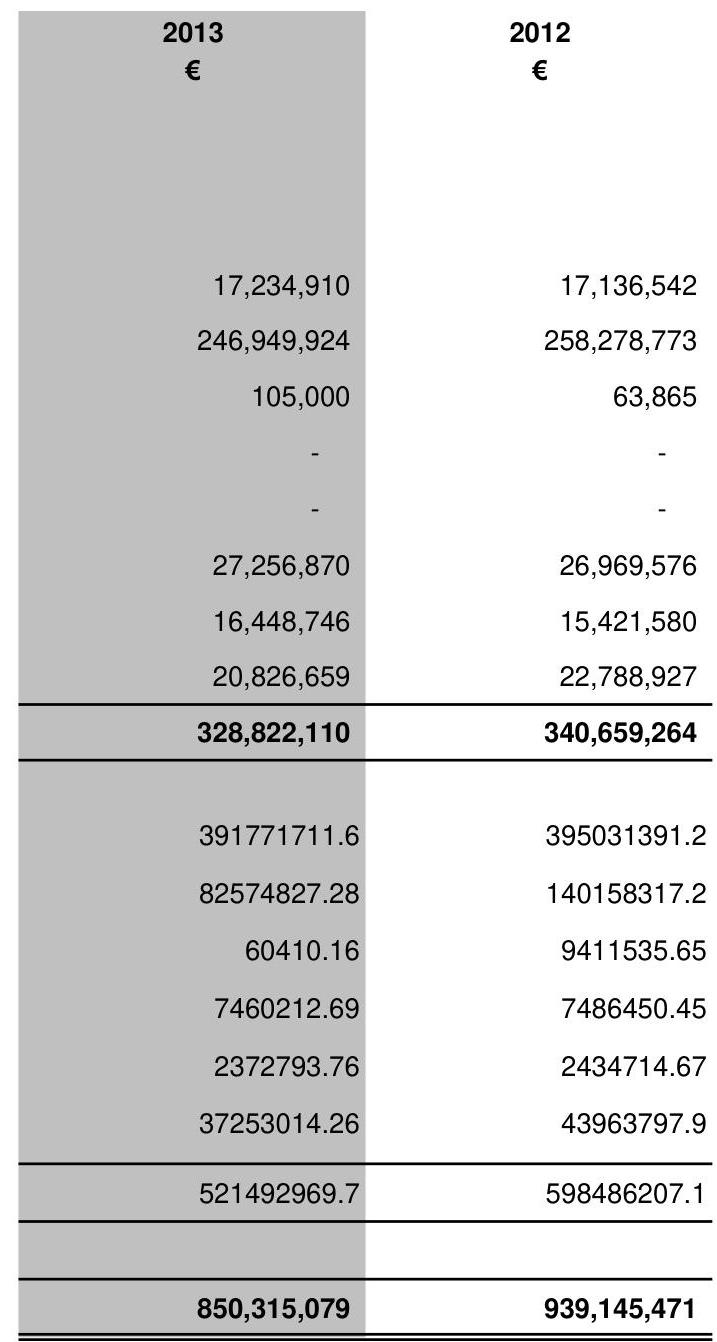
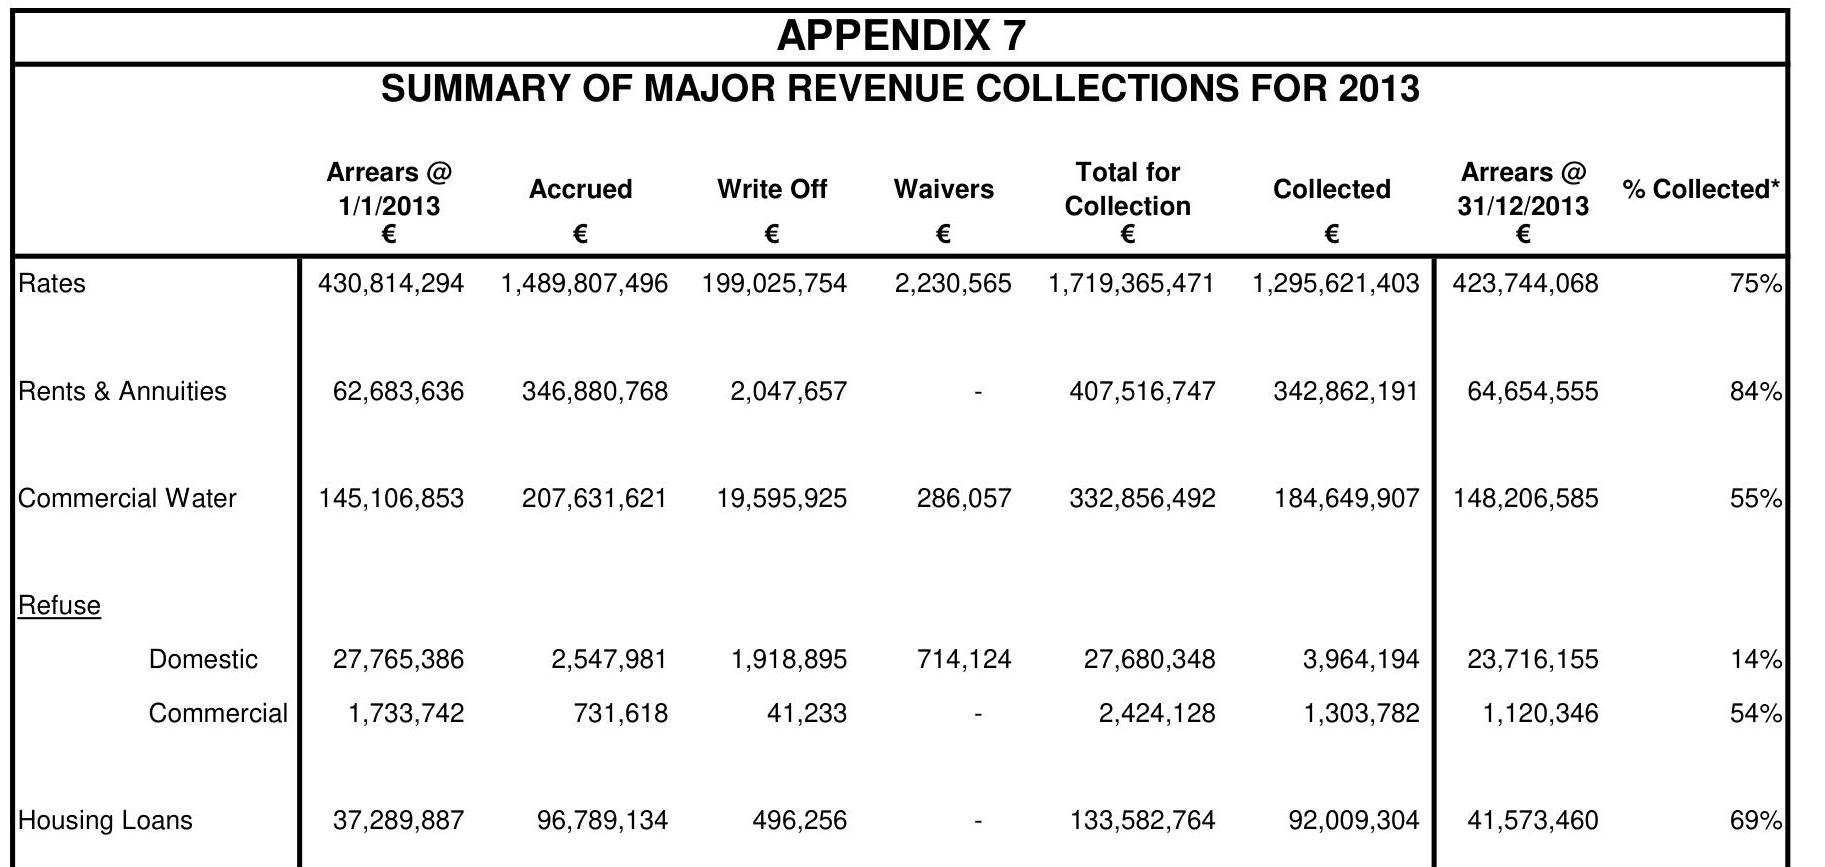

In [100]:
from mistralai import DocumentURLChunk, ImageURLChunk, TextChunk
import json

# Uploading the file
uploaded_file = client.files.upload(
    file={
        "file_name": pdf_file.stem,
        "content": pdf_file.read_bytes(),
    },
    purpose="ocr",
)

signed_url = client.files.get_signed_url(file_id=uploaded_file.id, expiry=1)


# OCRing the file
pdf_response = client.ocr.process(document=DocumentURLChunk(document_url=signed_url.url),
                                  model="mistral-ocr-latest",
                                  include_image_base64=True)

response_dict = json.loads(pdf_response.model_dump_json())
json_string = json.dumps(response_dict, indent=4)

print(json_string)

# (1) 

Comhshaol, Pobal agus Rialtas Áltiüil
Environment, Community and Local Government

## ANNUAL FINANCIAL STATEMENT

## For the year ended 31st December 2013

# CONTENTS 

## Page

Statement of Accounting Policies ..... 6
Financial Accounts ..... 10
Income \& Expenditure Account ..... 11
Balance Sheet ..... 12
Notes on and forming part of the Accounts ..... $13-20$
Appendices ..... 21
1 Analysis of Expenditure ..... 22
2 Expenditure and Income by Division ..... 23
3 Analysis of Income from Grants and Subsidies ..... 27
4 Analysis of Income from Goods and Services ..... 28
5 Summary of Capital Expenditure and Income ..... 29
6 Capital Expenditure and Income by Division ..... 30
7 Major Revenue Collections ..... 31
8 Interest of Local Authorities in Companies ..... 32

# Introduction 

This publication, which was formerly entitled "Returns of Local Taxation", contains the consolidated Annual Financial Statements (AFS) for all local authorities.

Each local authority is required to prepare an Annual Financial Statement by the end of March following the year end and to publish it by the end of June. These financial statements undergo an independent audit by the Local Government Audit Service of the Department of the Environment, Community and Local Government.

The local authorities dealt with and consolidated in this publication are Cou Councils, City Councils, Borough Councils, rating Town Councils, non-rating Town Councils and other miscellaneous local government related bodies.

Note: All figures in this publication are in Euro. Due to the effects of rounding, small differences may arise in some overall totals.

# Introduction 

This publication contains financial data which has been compiled by the Department of the Environment, Community and Local Government from the Audited Financial Statements published by each local authority for 2013.

Total gross expenditure in 2013 was $€ 4.5 \mathrm{Bn}$, gross income was $€ 2.4 \mathrm{Bn}$ and net expenditure $€ 2.105 \mathrm{Bn}$.

## Local Government Reform / Modernisation

Significant progress was achieved during 2013 in implementing the Government's local government reform programme announced in the Action Programme for Effective Local Government: Putting People First, in October 2012. In particular, the Local Government Bill 2013, providing for the reform of local government structures, functions, governance and related matters, was published in October 2013 and had progressed to an advanced stage through the Oireachtas by year end.

Work on the merger of local authorities in Limerick and Tipperary, overseen by the Department, continued in 2013 in accordance with Implementation Plans completed in June and December 2012. An implementation group to direct preparatory work and initial implementation of the reorganisation process in Waterford reported in June 2013. An Interim Dual Manager was appointed in both Tipperary and Waterford in November and December 2013, respectively, to lead the merger process in those areas in addition to the Dual Manager already in place in Limerick.

The Department engaged closely with local authorities and the local authority representative associations, the Association of County and City Councils and the Association of Municipal Authorities in Ireland, during 2013 regarding implementation arrangements, including the drafting of legislation, for local government reorganisation.

The independently chaired Implementation Group, which includes private sector expertise, established to drive and oversee the implementation of the recommendations of the Report of the Local Government Efficiency Review Group (LGER) submitted its second Progress Report to the Minister. This was published in July 2013. The County and City Managers' Association (CCMA), in its input to the Report, confirmed total savings of $€ 839 \mathrm{~m}$ since the beginning of the economic downturn in 2008. In the period since the preparation of the LGER Report (2010 to end 2012), the savings achieved and projected were reported at $€ 561 \mathrm{~m}$. This included $€ 229 \mathrm{~m}$ (already more than half the $€ 346 \mathrm{~m}$ identified as potential direct efficiency savings in the LGER Report) attributed to efficiency measures (as opposed to reduction in activity) in the years 2010 to the end of 2012. The majority of the efficiency savings identified related to staffing reductions and procurement. The Group and the CCMA prioritised the implementation of key recommendations relating to procurement, ICT, human resources/staffing and shared services as areas with potential to yield the optimum level of savings in regard to the implementation of the efficiency agenda within the sector.

An independently chaired group was tasked to carry out a review of the staffing complement and number of senior managers in Cork City Council. Their report and recommendations, together with the Cork City Council Workforce Plan 2010 - 2014 were submitted to the Minister and published in April 2013.

# Staffing 

There was approximately 27,501 staff (whole-time equivalent) working in the local authority system at the end of 2013, comprising management, administrative, technical, craft and general operative grades, including personnel dealing with specific services such as libraries and fire. The Manager is responsible for all staffing and organizational arrangements. While staff structures and numbers may vary according to the size of the county or city council, Directors of Service and Heads of Finance are the next tiers of senior management after the Manager in most authorities.

## Local Authority Superannuation

A voluntary redundancy scheme for local authority employees was introduced in July 2013. The aim of the Scheme is to achieve a permanent reduction in the workforce of local authorities from 2013 onwards in line with the recommendations of the workforce study and the Action Programme for Effective Local Government: Putting People First. Approximately 620 applications were approved by local authorities, with 390 staff departing in 2013 and a further 230 due to leave in 2014.

## Local Government Finance

The Local Government Fund was established by the Local Government Act 1998 with effect from 1 January 1999. The proceeds of motor tax (net of refunds) and the household charge collected to 30 June 2013 were paid into the Fund and any bank interest earned thereon.

In 2013 the Fund provided local authorities with some $€ 1.05 \mathrm{bn}$ in funding for day-today activities, regional and local roads and other initiatives. The Fund has put local authority financing on a sound footing and has supported the provision of better quality services locally. In 2013, the GeneralPurpose Grant provided to local authorities from the Fund was $€ 640.1 \mathrm{~m}$.

In 2013 the Fund also made a contribution of $€ 100 \mathrm{~m}$ to the exchequer.

## Motor Tax

At the end of 2013, there were 2.48 m vehicles on Irish roads, a $3.3 \%$ increase from 2.4 m at the end of 2012. Motor tax revenue increased by $7.8 \%$ in 2013 to $€ 1.1 \mathrm{bn}$. The increase was due to a combination of the motor tax increases announced in Budget 2013 and the closing off of a loophole in the procedures for declaring a vehicle off the road. Of the 2013 revenue, a sum of $€ 100 \mathrm{~m}$ was transferred to the Exchequer from the Local Government Fund as a measure towards reduction of the national deficit.

CO2 emissions became the basis for motor tax for private vehicles registered from 01 July 2008. By December 2013, the CO2 fleet contained 538,604 cars, or just over $28 \%$ of all private vehicles. While $77 \%$ of the overall CO2 fleet is in the lowest emitting A and B bands, $94 \%$ of the cars first taxed in 2013 are in the $A$ and $B$ bands, reflecting the fact that more environmentally friendly cars are coming on to the market.

# Government Grants/Subsidies 

Government grants and subsidies to local authorities embrace many aspects of their operation and are paid by a number of Government Departments. In 2013 the more important grants paid by the State to local authorities were:

## Grants for road works:

(i) National Roads

The National Roads Authority assumed full responsibility for the development of the network of national primary and secondary roads on 1 January 1994. Funding is provided by the Department of Transport to the Authority, which then determines the allocations to local authorities for improvement and maintenance works on these roads.
(ii) Regional and Local Roads

Regional and local road grants are usually paid out of the Local Government Fund. Responsibility for the allocation of grants was transferred from the Department of Environment, Community and Local Government to the Department of Transport in 2008. In September 2009 the NRA took over the administration of the Regional and Local Roads Investment Programme on behalf of the Department of Transport and the NRA now recommends grant allocations for regional and local roads, subject to final approval by the Minister for Transport, Tourism and Sport.

## Grants for water supply and sewerage schemes:

These grants apply to water supply and waste water schemes undertaken under the Water Services investment and Rural Water Programmes. Under the Water Services Investment Programme 100\% capital grants apply to the provision of new water and waste water services for domestic purposes. Water pricing policy requires the recovery of non-domestic capital costs for water services facilities on a marginal cost basis i.e. charging non-domestic customers for the capital costs of new infrastructure on the basis of the additional costs required to provide water services for such customers over and above the cost of meeting domestic requirements.

## Grants for housing:

Capital grants are provided to local authorities under the Social Housing Investment Programme to assist in the construction and renewal of social rented accommodation for persons and families who have been assessed as in need of housing support.

The major grants for 2013 are:
a) Local authority housing construction projects
b) Remedial works on older housing stock
c) Regeneration of older local authority estates
d) Retrofitting/ Energy Efficiency enhancement of older LA stock

e) Voluntary and co-operative housing
f) Traveller accommodation programmes
g) Housing Adaptation Grant Schemes for Older People and People with a Disability.

# Rates 

Local authorities are obliged by law to levy rates on commercial property which has been entered in the valuation list by the independent Commissioner of Valuation. Rates are levied annually on commercial and industrial property by county councils, city councils, borough councils and town councils which were former UDCs. Each of these authorities has exclusive rating jurisdiction within its own area. The remaining town councils (former town commissioners) are not rating authorities; their requirements, apart from State grants and miscellaneous receipts, are obtained by way of town charges. The county council levies the amount of town charges and certain incidental expenses as an additional rate on the town and collects it as part of the county rate. As a general rule, rates are levied on the occupiers of property. Income from rates in 2013 amounted to $€ 1.5$ billion.

Rates are assessed on the valuation of immoveable property such as buildings, factories, shops, railways, canals, mines, woods, rights of fishery and rights of easement over land. The Valuation Office values property for rating purposes. There is a right of appeal to the Commissioner of Valuation and to the Valuation Tribunal against valuations determined by the Valuation Office. Rating authorities do not have valuing powers.

## Income from Goods and Services

Local authorities also receive revenue from the provision of a range of goods and services. The most significant is rental income; proceeds of sales of local authority housing; repayments by borrowers for house purchase and improvement loans; and charges for water supplies, refuse collection and sewerage facilities. The Local Government (Financial Provisions) (No. 2) Act 1983 conferred general powers on local authorities to charge for services which they provide, and for which a charging provision did not previously exist or where charges were previously prohibited.

## Non-Principal Private Residence (NPPR) Charge

The Local Government (Charges) Act 2009 introduced a charge on residential property which is not inhabited by the owner as his or her sole or main residence. The charge is collected and retained by the relevant local authority. 2013 was the final year of the NPPR charge and has now been replaced by the Local Property Tax (LPT).

## Apportionment and Chargeability of Expenses

Except where it is otherwise provided for by law, the expenses of a county council are charged on a county-at-large basis, that is, on the whole county, including any borough council and rating town councils (former UDCs). County charges are invoiced on borough and rating town councils on the basis of the net estimated costs of providing services and taking account of any income arising from the provision of the service. In the determination of its rate annually, borough and rating town councils must provide for the amount demanded by the county council as well as for the services administered by the borough and rating town councils themselves. Generally speaking, the cost of

services administered by the county council but not embracing borough or rating town council areas is charged on the county health district, which, in all counties except Cork (where there are three county health districts), consists of the whole county exclusive of any borough council and rating town council. There are some exceptions, such as the cost of burial boards (which are normally a county-at-large charge) in the counties of Wexford and Wicklow, where it is charged on either the county health district or an area consisting of the county health district and some of the borough and rating town councils in the county.

# External Audit of Local Authorities 

The Local Government Audit Service (LGAS) is, for administrative purposes, a division of the Department of the Environment, Community and Local Government. It audits the accounts of all local bodies such as cities, counties, towns and miscellaneous bodies including some harbour authorities. The total number of bodies under its remit is 176. The LGAS provides independent scrutiny of the financial stewardship of local authorities. Its role is to:

- Carry out audits of local authorities and other bodies in accordance with its Code of Practice, thereby fostering the highest standards of financial stewardship, governance and public accountability;
- Promote the achievement of value for money in local authorities by undertaking Value for Money (VFM) audits and publishing reports thereon.

A local government auditor is required to give an audit opinion on the annual financial statements of local authorities and other audited bodies. This opinion is the culmination of the auditor's work on reviewing the audited body's transactions as reported in the annual financial statement. The auditor expresses an opinion as to whether the annual financial statement presents fairly, in accordance with the Accounting Code of Practice and Regulations, the financial position of the body at year end and its income and expenditure for the year. It is custom and practice to issue statutory audit reports on the major audits covering any matter which the auditor feels should be reported. The Manager of a local authority is required to respond and his or her comments may be included as part of the final report. This procedure has enhanced public scrutiny of local government.

The Value for Money audit unit of the LGAS consists of a central research team, staffed by a Principal Local Government Auditor and two Local Government Auditors, together with further audit days provided by Assistant Auditors at district level. The Unit has produced 28 VFM reports and six progress reports to date. The work of the VFM Unit has focused on undertaking national studies on single-issue topics and publishing reports thereon. The Unit also undertakes progress reports on the implementation, by local authorities, of the recommendations contained in national studies issued by the Unit.

# Performance Indicators 

The Local Government Management Agency (LGMA) publishes annual reports on the performance of local authorities across a range of 42 service indicators, increasing to 46 from 2008 on. The initiative is a first for the public sector and is an important step in measuring performance across the entire local government sector. The 2013 report is currently available from the LGMA website on:
http://www.lgcsb.ie/sites/default/files/141210 service indicators report 2013 final including iap . report.doc

# STATEMENT OF ACCOUNTING POLICIES 

## 1. General

The accounts have been prepared in accordance with the Accounting Code of Practice ACoP on local authority accounting, as revised by the Department of Environment, Community and Local Government (DECLG) at 31st December 2013. Non-compliance with accounting policies as set out in ACoP must be stated in the Policies and Notes to the Accounts.

## 2. Funds Flow Statement

A Funds Flow statement has been introduced as part of AFS 2011. While the guidance of International Accounting Standard 7 Statement of Cash Flows has been followed, the business of local authorities is substantially different to most private sector organisations and therefore some minor changes to the format have been agreed to ensure the data displayed is meaningful and useful within the local government sector. For this reason the statement is being referred to as a 'Funds Flow Statement'. The financial accounts now include a funds flow statement shown after the Balance Sheet. Notes 18 - 23 relate to the funds flow statement and are shown in the Notes on and forming part of the Accounts section of the AFS. Note 20 details Project/Non Project/Affordable/Voluntary balances, which can be either a debit or a credit balance. The funds flow assumes that these are debit balances and bases the (Increase)/Decrease description on this.

## 3. Accruals

The revenue and capital accounts have been prepared on an accrual basis in accordance with the Code of Practice. (Each local authority should list the areas where they are not complying with this policy, e.g. development contributions)

## 4. Interest Charges

Loans payable can be divided into the following two categories:

- Mortgage related loans
- Non- mortgage related loans


### 4.1 Mortgage Related Loans

Mortgage related loans have a corresponding stream of income from long term advances (i.e. monies lent by the local authorities to borrowers), for the purchase of houses. Only the interest element is charged or credited to the Income \& Expenditure Statement.

### 4.2 Non Mortgage Related Loans

Note 8 to the accounts sets out the types of borrowing under this heading. Loans relating to assets/grants, revenue funding, inter local authority will not have a corresponding stream of income. Bridging finance will eventually become part of permanent funding. Loans in respect of the other headings will have a corresponding value in Note 3.

## 5. Pensions

Payments in respect of pensions and gratuities are charged to the revenue account in the accounting period in which the payments are made. The cost of salaries and wages in the accounts includes deductions in respect of superannuation (including Widows and Orphans) benefits. Such deductions are credited as receipts to the Income \& Expenditure Statement. The requirements of current accounting standards relating to pensions and their application to local authority accounting remains under consideration.

# 6. Agency and Other Services 

Expenditure on services provided or carried out on behalf of other local authorities is recouped at cost or in accordance with specific agreements.

## 7. Insurance

The County/City/Borough/Town Council operates an insurance excess of ....

## 8. Provision for Bad \& Doubtful Debts

Provision has/has not been made in the relevant accounts for bad \& doubtful debts.

## 9. Fixed Assets

### 9.1 Classification of Assets

Fixed assets are classified into categories as set out in the balance sheet. A further breakdown by asset type is set out in note 1 to the accounts.

### 9.2 Recognition

All expenditure on the acquisition or construction of fixed assets is capitalised on an accrual basis.

### 9.3 Measurement

A balance sheet incorporating all of the assets of the local authority was included for the first time in the Annual Financial Statement for 2003. The assets were valued based on the 'Valuation Guideline' issued by the DECLG. All assets purchased or constructed as from 1/1/2004 have been included at historical cost. Accounting policies relating to leases are currently being developed and will be reflected in the financial statements for 2012.

### 9.4 Revaluation

As set out in a revision to the Accounting Code of Practice it is policy to show fixed assets at cost. Maintenance and enhancement costs associated with Infrastructure assets are not currently included in fixed assets but will be reviewed in 2014. Due to their physical nature the vast majority of assets are unique to local authorities and are not subject to disposal. Any loss or gain associated with the net realisable value of the remaining general assets subject to disposal, are accounted for at time of disposal.

### 9.5 Disposals

In respect of disposable assets, income is credited to a specific reserve and is generally applied in the purchase of new assets. Proceeds of the sale of local authority houses are to be applied as directed by the DECLG.

# 9.6 Depreciation 

Under the current method of accounting, the charge for depreciation is offset by the amortisation of the source of funding the asset. This method has a neutral impact on Income \& Expenditure and consequently the charge for depreciation and the corresponding credit from amortisation is excluded from the Income \& Expenditure Statement.

| The policies applied to assets subject to depreciation are as follows: |  |  |
| :-- | :-- | :-- |
| Asset Type | Bases | Depreciation Rate |
| Plant \& Machinery |  |  |
| - Long life | S/L | $10 \%$ |
| - Short life | S/L | $20 \%$ |
|  |  |  |
| Equipment | S/L | $20 \%$ |
| Furniture | S/L | $20 \%$ |
| Heritage Assets |  | Nil |
| Library Books |  | Nil |
| Playgrounds | S/L | $20 \%$ |
| Parks | S/L | $2 \%$ |
| Landfill sites (*See note) |  |  |
| Water Assets |  |  |
| - Water schemes | S/L | Asset life over 70 years |
| - Drainage schemes | S/L | Asset life over 50 years |

The Council does not charge depreciation in the year of disposal and will charge a full year's depreciation in the year of acquisition.

* The value of landfill sites has been included in note 1 under land. Depreciation represents the depletion of the landfill asset.


## 10. Government Grants

Government grants are accounted for on an accrual basis. Grants received to cover day to day operations are credited to the Income \& Expenditure Statement. Grants received, relating to the construction of assets, are shown as part of the income of work-in-progress. On completion of the project the income is transferred to a capitalisation account.

## 11. Development Debtors \& Income

All development debtors are now included in notes $3 \& 5$. Income from development contributions not due to be paid within the current year is deferred and shown under long term creditors in the balance sheet.

## 12. Debt Redemption

The proceeds from the early redemption of loans by borrowers, are applied to the redemption of mortgage related borrowings from the HFA and OPW.

## 13. Lease Schemes

Rental payments under operating leases are charged to the Income \& Expenditure. Assets acquired under a finance lease are included in fixed assets. The amount due on outstanding balances is shown under current liabilities and long-term creditors.

# 14. Stock 

Stocks are valued on an average cost basis.

## 15. Work-in-Progress \& Preliminary Expenditure

Work-in progress and preliminary expenditure is the accumulated historical cost of various capital related projects. The income accrued in respect of these projects is shown in the Balance Sheet as 'Income WIP'.

## 16. Debtors and Creditors

### 16.1 Debtors

At the close of the financial year, debtors represent income due but not yet received.

### 16.2 Creditors

At the close of the financial year, creditors represent payments due in respect of goods received and services rendered but not yet paid.

## 17. Interest in Local Authority Companies

The interest of the Local Authority in companies is listed in Appendix 8.

## 18. Affordable Housing

The accounting policy for the Affordable Housing Scheme was amended for AFS 2011. The amended policy was introduced to appropriately reflect the changing circumstances in the housing market, which impact on the scheme, including the deployment of unsold affordable homes for other purposes, including temporary use under the social leasing or RAS schemes. From AFS 2011, the bridging finance has been brought into the relevant capital jobs. AFS 2013 will show the completion of the accounting policy change and will include the addition of the affordable housing units to the fixed asset register and inclusion in the Balance Sheet.

# FINANCIAL ACCOUNTS

# INCOME \& EXPENDITURE ACCOUNT STATEMENT FOR YEAR ENDING 31st DECEMBER 2013 

The Income and Expenditure Account Statement brings together all the revenue related income and expenditure. It shows the surplus/(deficit) for the year. Transfers to/from reserves are shown separately and not allocated by service division. Note 17 allocates transfers by service division in the same format as Table A of the adopted Local Authority budget.

## Expenditure by Division

|  |  | Gross <br> Expenditure | Income | Net Expenditure | Net <br> Expenditure |
| :--: | :--: | :--: | :--: | :--: | :--: |
|  |  | 2013 <br> € | 2013 <br> € | 2013 <br> € | 2012 <br> € |
| Housing \& Building |  | 725,127,157 | 676,909,877 | 48,217,279 | 41,018,417 |
| Roads Transportation \& Safety |  | 864,109,904 | 543,031,891 | 321,078,013 | 312,145,591 |
| Water Services |  | 774,103,086 | 339,887,585 | 434,215,501 | 445,323,104 |
| Development Management |  | 254,526,234 | 55,757,011 | 198,769,223 | 200,012,856 |
| Environmental Services |  | 672,695,250 | 240,989,571 | 431,705,679 | 453,447,137 |
| Recreation \& Amenity |  | 362,307,353 | 58,703,090 | 303,604,262 | 303,466,440 |
| Agriculture, Education, Health \& Welfare |  | 127,612,389 | 102,796,830 | 24,815,560 | 22,986,958 |
| Miscellaneous Services |  | 677,059,710 | 408,741,075 | 268,318,635 | 286,881,136 |
| County Charge |  | 74,911,953 | - | 74,911,953 | 75,662,115 |
| Total Expenditure/Income | 16 | 4,532,453,035 | 2,426,816,929 |  |  |
| Net cost of Divisions to be funded from Rates \& Local Government Fund |  |  |  | 2,105,636,106 | 2,140,943,753 |
| Rates |  |  |  | 1,493,619,132 | 1,496,791,123 |
| Local Government Fund - General Purpose Grant |  |  |  | 640,113,993 | 636,108,599 |
| Pension Related Deduction |  |  |  | 78,576,122 | 79,549,254 |
| County Charge |  |  |  | 75,041,790 | 75,598,243 |
| Surplus/(Deficit) for Year before Transfers | 17 |  |  | 181,714,931 | 147,103,466 |
| Transfers from/(to) Reserves | 15 |  |  | (203,543,266) | (171,671,571) |
| Overall Surplus/(Deficit) for Year |  |  |  | (21,828,336) | (24,568,105) |
| General Reserve @ 1st January 2013 |  |  |  | 24,749,127 | 49,317,232 |
| General Reserve @ 31st December 2013 |  |  |  | 2,920,792 | 24,749,127 |

# BALANCE SHEET AT 31st DECEMBER 2013 

|  | Notes | $\begin{gathered} 2013 \\ € \end{gathered}$ | $\begin{gathered} 2012 \\ € \end{gathered}$ |
| :--: | :--: | :--: | :--: |
| Fixed Assets | 1 |  |  |
| Operational |  | 27,189,950,242 | 26,662,412,768 |
| Infrastructural |  | 68,210,908,883 | 67,877,984,074 |
| Community |  | 777,380,319 | 750,337,049 |
| Non-Operational |  | 1,499,695,991 | 1,632,685,090 |
|  |  | 97,677,835,435 | 96,923,418,982 |
| Work in Progress and Preliminary Expenses | 2 | 3,245,355,063 | 3,587,994,111 |
| Long Term Debtors | 3 | 2,708,083,963 | 2,804,007,905 |
| Current Assets |  |  |  |
| Stocks | 4 | 16,565,354 | 17,344,320 |
| Trade Debtors \& Prepayments | 5 | 830,543,078 | 985,482,116 |
| Bank Investments |  | 1,149,217,581 | 1,214,132,301 |
| Cash at Bank |  | 220,047,313 | 177,970,174 |
| Cash in Transit |  | 7,999,995 | 5,804,332 |
| Urban Account | 7 | 1,077,409 | 1,517,546 |
|  |  | 2,225,450,731 | 2,402,250,789 |
| Current Liabilities (Amounts falling due within one year) |  |  |  |
| Bank Overdraft |  |  |  |
| Creditors \& Accruals | 6 | 1,198,497,968 | 1,219,081,129 |
| Urban Account | 7 | 924,005 | 1,125,171 |
| Finance Leases |  |  |  |
|  |  | 1,199,421,973 | 1,220,206,300 |
| Net Current Assets / (Liabilities) |  |  |  |
| Creditors (Amounts falling due after more than one year) |  |  |  |
| Loans Payable | 8 | 4,710,290,983 | 4,902,542,150 |
| Finance Leases |  | 1,229,783 | 1,787,008 |
| Refundable deposits | 9 | 165,943,586 | 169,963,557 |
| Other |  | 213,541,606 | 229,735,851 |
|  |  | 5,091,005,958 | 5,304,028,566 |
| Net Assets |  |  |  |
|  |  | 99,566,397,260 | 99,193,436,921 |
| Represented by |  |  |  |
| Capitalisation Account | 10 | 97,677,935,438 | 96,923,418,978 |
| Income WIP | 2 | 3,099,353,512 | 3,471,515,528 |
| Specific Revenue Reserve |  | 116,579,225 | 116,814,860 |
| General Revenue Reserve |  | 2,920,792 | 24,749,127 |
| Other Balances | 11 | (1,330,391,701) | (1,343,061,542) |
| 99999 ERROR Account |  | 4 | 1 |
| 21300 Unallocated Income Account |  | 1 | 1 |
|  |  | (11) | (31) |
| Balancing Figure |  |  |  |
| Total Reserves |  | 99,566,397,260 | 99,193,436,921 |

# FUNDS FLOW STATEMENT AS AT 31ST DECEMBER 2013 

|  |  | 2013 | 2013 |
| :--: | :--: | :--: | :--: |
|  | Note | $€$ | € |
| REVENUE ACTIVITIES |  |  |  |
| Net Inflow/(outflow) from operating activities | 18 |  | 113,898,795 |
| CAPITAL ACTIVITIES |  |  |  |
| Returns on Investment \& Servicing of Finance |  |  |  |
| Increase/(Decrease) in Fixed Asset Capitalisation Funding |  | 754,516,460 |  |
| Increase/(Decrease) in WIP/Preliminary Funding |  | $(372,162,015)$ |  |
| Increase/(Decrease) in Reserves Balances | 19 | $(348,868,119)$ |  |
| Net Inflow/(Outflow) from Returns on Investment and Servicing of Finance |  |  | 33,486,326 |
| Capital Expenditure \& Financial Investment |  |  |  |
| (Increase)/Decrease in Fixed Assets |  | $(754,516,451)$ |  |
| (Increase)/Decrease in WIP/Preliminary Funding |  | $342,639,048$ |  |
| (Increase)/Decrease in Agent Works Recoupable |  | $(152,150)$ |  |
| (Increase)/Decrease in Other Capital Balances | 20 | 265,109,378 |  |
| Net Inflow/(Outflow) from Capital Expenditure and Financial Investment |  |  | $(146,920,174)$ |
| Financing |  |  |  |
| Increase/(Decrease) in Loan Financing | 21 | $(113,279,861)$ |  |
| (Increase)/Decrease in Reserve Financing | 22 | 96,192,947 |  |
| Net Inflow/(Outflow) from Financing Activities |  |  | $(17,086,914)$ |
| Third Party Holdings |  |  |  |
| Increase/(Decrease) in Refundable Deposits |  |  | $(4,019,971)$ |
| Net Increase/(Decrease) in Cash and Cash Equivalents | 23 |  | $(20,641,940)$ |

NOTES TO AND FORMING PART OF THE ACCOUNTS

# 1. Fixed Assets 

|  | Land | Parks | Housing | Buildings | Plant \& Machinery (Long \& Short Life) | Computers, Furniture \& Equipment | Heritage | Roads \& Infrastructure | Water \& <br> Sewerage <br> Network | Total |
| :--: | :--: | :--: | :--: | :--: | :--: | :--: | :--: | :--: | :--: | :--: |
| Costs | € | € | € | € | € | € | € | € | € | € |
| Accumulated Costs @ 1/1/2013 | 2,847,773,449 | 150,376,045 | 20,916,100,495 | 4,698,429,174 | 416,675,438 | 142,606,356 | 423,925,747 | 56,640,189,029 | 19,931,128,757 | 106,167,204,489 |
| Additions |  |  |  |  |  |  |  |  |  |  |
| - Purchased | 37,033,541 | 4,351,509 | 520,256,223 | 30,781,773 | 11,785,740 | 3,116,658 | 2,697,856 | 22,299,180 | 95,245,660 | 727,568,139 |
| - Transfers WIP | 17,601,432 | 3,935,313 | 121,641,106 | 34,970,772 | 416,253 | 85,172 | 709,605 | 221,761,389 | 343,321,090 | 744,442,132 |
| Disposals | (33,918,161) | - | (201,794,078) | (29,927,527) | (11,500,649) | (2,236,507) | (51,076) | - | (2,454,757) | (281,882,755) |
| Revaluations | 125,075 | - | (74,058,012) | - | - | - | - | (49,811,050) | - | (123,743,987) |
| Historical Cost Adjustments | (21,814,941) | 65,451 | 13,447,170 | 3,657,487 | (287,805) | 167,196 | 1,432,155 | 14,133,285 | 82,023,027 | 92,823,026 |
| Accumulated Costs @ 31/12/2013 | 2,846,800,395 | 158,728,317 | 21,295,592,903 | 4,737,911,678 | 417,088,977 | 143,738,876 | 428,714,287 | 56,848,571,834 | 20,449,263,778 | 107,326,411,044 |
| Depreciation |  |  |  |  |  |  |  |  |  |  |
| Depreciation @ 1/1/2013 | 63,978,419 | 46,325,424 | 39,514 | 3,745,699 | 325,518,237 | 122,448,398 | - | 0 | 8,681,729,817 | 9,243,785,509 |
| Provision for Year | 12,166,118 | 6,100,077 | - | 83,716 | 23,774,072 | 9,717,896 | - | 0 | 366,413,164 | 418,255,044 |
| Disposals | - | - | - | - | (9,893,049) | (2,366,820) | - | - | (1,305,070) | (13,564,939) |
| Accumulated Depreciation @ 31/12/2013 | 76,144,537 | 52,425,501 | 39,514 | 3,829,415 | 339,399,260 | 129,799,474 | - | 0 | 9,046,837,912 | 9,648,475,613 |
| Net Book Value @ 31/12/2013 | 2,770,655,858 | 106,302,816 | 21,295,553,389 | 4,734,082,263 | 77,689,717 | 13,939,402 | 428,714,287 | 56,848,571,834 | 11,402,425,866 | 97,677,935,431 |
| Net Book Value @ 31/12/2012 | 2,783,795,030 | 104,050,851 | 20,916,080,081 | 4,694,683,475 | 91,157,201 | 20,157,867 | 423,925,747 | 56,640,189,028 | 11,249,398,940 | 96,923,418,980 |

## Net Book Value by Category

| Operational | 1,328,857,820 | 40,771,298 | 21,246,523,305 | 4,167,331,587 | 77,447,728 | 12,930,248 | 21,390,786 | 85,529,833 | 209,167,636 | 27,189,950,242 |
| :-- | --: | --: | --: | --: | --: | --: | --: | --: | --: | --: |
| Infrastructural | 59,445,812 | 3,471,276 | 1,323,891 | 186,337,217 | 11,640 | 280,591 | 4,108,930 | 56,762,671,294 | 11,193,258,231 | 68,210,908,883 |
| Community | 80,281,690 | 61,221,260 | 989,126 | 231,789,208 | 226,965 | 250,267 | 402,251,097 | 370,707 | - | 777,380,319 |
| Non-Operational | 1,302,070,537 | 838,982 | 46,717,071 | 148,624,252 | 3,382 | 478,294 | 963,473 | - | - | 1,499,695,991 |

Net Book Value @ 31/12/2013
2,770,655,859
106,302,817
21,295,553,393
4,734,082,265
77,689,715
13,939,400
428,714,286
56,848,571,834
11,402,425,867
97,677,935,435

# NOTES TO AND FORMING PART OF THE ACCOUNTS 

## 2. Work in Progress and Preliminary Expenses

A summary of work in progress and preliminary expenditure by asset category is as follows:

| Funded | Unfunded | Total | Total |
| :--: | :--: | :--: | :--: |
| 2013 | 2013 | 2013 | 2012 |
| € | € | € | € |

## Expenditure

Work in Progress
Preliminary Expenses

| 1,998,467,774 | 215,362,185 | 2,213,829,959 | 2,631,135,425 |
| :-- | :-- | :-- | :-- |
| 865,791,265 | 165,733,839 | 1,031,525,104 | 956,858,685 |
| 2,864,259,039 | 381,096,024 | 3,245,355,062 | 3,587,994,111 |

Income
Work in Progress
Preliminary Expenses

| 1,930,194,169 | 156,972,896 | 2,087,166,864 | 2,543,500,209 |
| :-- | :-- | :-- | :-- |
| 892,325,524 | 119,861,124 | 1,012,186,646 | 928,015,319 |
| 2,822,519,693 | 276,833,819 | 3,099,353,512 | 3,471,515,528 |

## Net Expended

Work in Progress
Preliminary Expenses
Net Over(Under) Expenditure

| 68,273,605 | 58,389,489 | 126,663,094 | 87,635,217 |
| :-- | :-- | :-- | :-- |
| (26,534,259) | 45,872,715 | 19,338,456 | 28,843,367 |

## 3. Long Term Debtors

A breakdown of the long-term debtors is as follows:

| Balance @ <br> 1/1/2013 | Loans <br> Issued | Principal <br> Repeat | Early <br> Redemptions | Other <br> Adjustments | Balance @ <br> 31/12/2013 | Balance @ <br> 31/12/2012 |
| :--: | :--: | :--: | :--: | :--: | :--: | :--: |
|  | € | € | € | € | € | € |
| Long Term Mortgage Advances* | 1,066,501,590 | 32,377,913 | (48,758,234) | (21,266,562) | (686,984) | 1,028,167,723 | 1,066,335,465 |
| Tenant Purchases Advances | 20,211,106 |  | (3,481,096) | (479,460) | (15,651) | 16,234,899 | 20,211,105 |
| Shared Ownership Rented Equity | 290,122,171 | (153,988) |  | (12,647,247) | (2,536,863) | 274,784,073 | 290,122,172 |
| 1,376,834,867 | 33,223,926 | (52,239,330) | (34,393,269) | (3,339,498) | 1,319,186,695 | 1,376,638,742 |  |
| Voluntary Housing <br> Development Levy Debtors |  |  |  |  | 1,142,191,441 | 1,176,743,377 |  |
| Inter Local Authority Loans |  |  |  |  | 220,970,631 | 232,027,565 |  |
| Long-term Investments <br> Cash |  |  |  |  | 7,962,628 | 8,568,001 |  |
| Interest in associated companies |  |  |  |  |  |  |  |
| Other |  |  |  |  | 42,422,504 | 45,900,816 |  |
|  |  |  |  |  | 45,443,483 | 45,928,493 |  |
|  |  |  |  |  | 17,637,081 | 20,593,650 |  |
|  |  |  |  |  | 1,477,527,765 | 1,524,359,901 |  |
|  |  |  |  |  | 2,796,714,464 | 2,800,998,643 |  |
| Less: Amounts falling due within one year (Note 5) |  |  |  |  |  | (88,630,501) | (86,990,737) |
| Total Amounts falling due after more than one year |  |  |  |  |  | 2,708,083,963 | 2,804,037,905 |

* Includes HFA Agency Loans

# NOTES TO AND FORMING PART OF THE ACCOUNTS 

## 4. Stocks

A summary of stock is as follows:

| 2013 | 2012 |
| :--: | :--: |
| € | € |
| 6,152,939 | 6,264,123 |
| $10,412,415$ | $11,080,198$ |
| 16,565,354 | 17,344,320 |

## 5. Trade Debtors \& Prepayments

A breakdown of debtors and prepayments is as follows:

Government Debtors
Commercial Debtors
Non-Commercial Debtors
Devetopment Levy Debtors
Other Services
Other Local Authorities
Agent Works Recoupable
Revenue Commissioners
Other
Add: Amounts falling due within one year (Note 3)
Total Gross Debtors
Less: Provision for Doubtful Debts
Total Trade Debtors
Prepayments

| 2013 | 2012 |
| :--: | :--: |
| € | € |
| 94,741,669 | 131,001,468 |
| 666,744,567 | 659,741,390 |
| 145,443,657 | 138,905,706 |
| 292,103,110 | 394,157,880 |
| 26,223,463 | 26,515,805 |
| 77,701,998 | 62,741,921 |
| 6,140,830 | 5,988,680 |
| 104,537,433 | 138,556,050 |
| 88,630,501 | 96,990,737 |
| 1,502,267,229 | 1,654,599,636 |
| (688,753,499) | (691,155,331) |
| 813,513,730 | 963,444,305 |
| 17,029,347 | 22,037,810 |
| 830,543,078 | 985,482,116 |

# NOTES TO AND FORMING PART OF THE ACCOUNTS 

## 6. Creditors and Accruals

A breakdown of creditors and accruals is as follows:

| 2013 | 2012 |
| :--: | :--: |
| € | € |
| Trade creditors | 132,007,762 |
| Grants | 1,827,352 |
| Revenue Commissioners | 67,587,989 |
| Other Local Authorities | 28,836,096 |
| Other Creditors | 33,647,799 |
| 26,799,085 | 51,295,464 |
| 267,098,247 | 287,043,184 |
| 512,286,865 | 448,670,728 |
| 202,582,462 | 269,343,525 |
| 216,570,394 | 214,023,692 |
| 1,198,497,968 | 1,219,081,129 |

## 7. Urban Account

A summary of the Intercompany account is as follows:

| 2013 | 2012 |
| :--: | :--: |
| € | € |
| 1,522,828 | $(3,818,294)$ |
| 18,426,395 | 16,258,519 |
| (18,871,913) | (10,922,679) |
| 1,077,409 | 1,517,546 |

## 8. Loans Payable

(a) Movement in Loans Payable

| HFA | OPW | Other | Balance @ <br> 31/12/2013 | Balance @ <br> 31/12/2012 |
| :--: | :--: | :--: | :--: | :--: |
| € | € | € | € | € |
| 4,426,032,059 | 14,270,720 | 676,263,062 | 5,116,565,841 | 5,112,097,252 |
| Borrowings |  | 9,694,980 | 142,826,935 | 329,478,436 |
| Repayment of Principal | $(4,089,548)$ | $(55,545,647)$ | $(211,586,479)$ | $(199,872,437)$ |
| Early Redemptions | $(135,201)$ | $(12,839,666)$ | $(127,480,055)$ | $(136,346,680)$ |
| Other Adjustments |  | $(38,898)$ | 6,545,128 | 11,209,273 |
| Balance @ 31/12/2013 |  |  |  |  |
| Less: Amounts falling due within one year (Note 6) |  |  | 216,570,394 | 214,023,692 |
| Total Amounts falling due after more than one year |  |  | 4,710,290,977 | 4,902,542,153 |

(b) Application of Loans

An analysis of loans payable is as follows:

| Mortgage loans* |  |  |  |  |
| :--: | :--: | :--: | :--: | :--: |
| Non-Mortgage loans |  |  |  |  |
| Asset Grants |  |  |  |  |
| Revenue Funding |  |  |  |  |
| Bristang Finance |  |  |  |  |
| Recoutable |  |  |  |  |
| Shared Ownership - Rented Equity |  |  |  |  |
| Inter-Local Authority |  |  |  |  |
| Voluntary housing |  |  |  |  |


| HFA | OPW | Other | Balance @ <br> 31/12/2013 | Balance @ <br> 31/12/2012 |
| :--: | :--: | :--: | :--: | :--: |
| € | € | € | € | € |
| 984,171,947 | 9,190,436 | 14,608 | 993,376,991 | 1,050,969,808 |
| 1,367,512,088 | 848,223 | 590,291,308 | 1,958,651,619 | 2,036,091,023 |
| 12,502,397 | - | 5,865,683 | 18,368,080 | 14,817,734 |
| 501,788,120 | - | 3,000,000 | 504,788,120 | 513,732,007 |
| 5,545,958 | 7,314 | 1,297,000 | 6,850,273 | 4,493,099 |
| 286,250,599 | - | - | 286,250,599 | 301,995,685 |
|  | - | 17,065,230 | 17,065,230 | 18,415,230 |
| 1,141,510,463 | - | - | 1,141,510,463 | 1,176,051,257 |
| 4,299,281,572 | 10,045,974 | 617,533,830 | 4,935,861,376 | 5,116,065,842 |
|  |  |  |  |  |
|  |  |  | 216,570,394 | 214,023,692 |
|  |  |  | 4,710,290,985 | 4,902,542,150 |

* Includes HFA Agency Loans

# NOTES TO AND FORMING PART OF THE ACCOUNTS 

## 9. Refundable Deposits

The movement in refundable deposits is as follows

| 2013 | 2012 |
| :-- | :-- |
| $\boldsymbol{\epsilon}$ | $\boldsymbol{\epsilon}$ |

Opening Balance at 1 January
Deposits received
Deposits repaid
Closing Balance at 31 December
169,963,556
15,566,403
(19,586,373)
172,666,107
12,502,512
(15,205,062)
169,963,557

Note: Short Term Refundable Deposits are included as part of Cash Investments on the Balance sheet

## 10. Capitalisation Account

The capitalisation account shows the funding of the assets as follows:

|  | Balance @ <br> 1/1/2013 | Purchased <br> € | Transfers WIP | Disposals | Revaluations | Historical Cost Adj | Balance @ <br> 31/12/2013 | Balance @ <br> 31/12/2012 |
| :--: | :--: | :--: | :--: | :--: | :--: | :--: | :--: | :--: |
| Grants | 18,006,483,653 | 339,857,110 | 495,191,915 | (112,600,764) | (74,058,012) | 5,532,982 | 18,660,406,885 | 18,006,483,653 |
| Loans | 951,717,833 | 168,624,174 | 37,976,367 | (5,666,164) | - | 8,300,606 | 1,160,952,817 | 951,717,833 |
| Revenue funded | 316,850,971 | 23,909,258 | 4,117,996 | (1,920,869) | - | 56,232 | 343,013,588 | 316,850,972 |
| Leases | 26,524,849 | 374,800 | - | (425,623) | - | 5,720,691 | 32,194,717 | 26,524,849 |
| Development Levies | 459,445,961 | 3,220,556 | 18,831,378 | (1,505,025) | - | 400,702 | 480,393,572 | 459,445,961 |
| Tenant Purchase Annuities | 61,972,031 | 1,485,395 | 228,070 | (500,896) | - | 6,950 | 63,191,550 | 61,972,031 |
| Unfunded | 192,336,253 | 13,291,000 | 5,138,392 | 815,328 | - | 377,126 | 211,958,099 | 192,336,253 |
| Historical | 77,942,228,988 | 10,663,115 | - | (139,935,521) | (85,275) | 52,620,865 | 77,865,492,172 | 77,942,228,987 |
| Other | 8,209,643,957 | 165,944,509 | 182,777,269 | (17,314,031) | (49,691,500) | 17,368,482 | 8,508,728,687 | 8,209,643,957 |
| Total Gross Funding | 106,167,204,496 | 727,369,918 | 744,261,388 | (279,053,566) | (123,834,787) |  | 107,325,332,086 | 106,167,204,496 |
| Less: Amortised |  |  |  |  |  |  | (9,648,396,648) | (9,243,785,518) |
| Total * |  |  |  |  |  |  | 97,677,935,438 | 96,923,419,976 |

* Must agree with note 1

# NOTES TO AND FORMING PART OF THE ACCOUNTS 

## 11. Other Balances

A breakdown of other balances is as follows:

|  | Note | Balance @ $1 / 12013$ <br> € | Capital re-classification ${ }^{\circ}$ | Expenditure € | Income € | Transfer from Revenue € | Transfer to Revenue € | Internal Transfers € | Balance @ $31 / 12 / 2012$ <br> € | Balance @ $31 / 12 / 2012$ <br> € |
| :--: | :--: | :--: | :--: | :--: | :--: | :--: | :--: | :--: | :--: | :--: |
| Tenant Purchase Annuities |  |  |  |  |  |  |  |  |  |  |
| - Restixed | (a) | 103,882,824 | (341,090) | 2,427,885 | 49,977,291 | (636,093) | 8,567,232 | (36,806,313) | 105,081,801 | 103,882,824 |
| - Unifocalised | (b) | 20,284,256 | (75,842) | 70,590 | (3,155,719) |  |  | (749,543) | 16,232,562 | 20,284,256 |
| Development Levies | (c) | 717,209,126 | 778,368 | $(8,538,778)$ | 444,244 | 222,257 | 7,426,851 | (229,245,798) | 490,520,124 | 717,209,126 |
| Unfunded Balances |  |  |  |  |  |  |  |  |  |  |
| - Project Balances | (d) | (359,449,468) | (25,430,047) | 5,646,317 | 6,268,318 | 6,377,615 | 65,378 | 65,692,742 | (312,252,535) | (359,449,468) |
| - Non-Project Balances | (e) | (206,213,818) | (26,627,228) | 23,033,435 | 48,737,317 | 15,257,311 | 90,000 | 51,189,198 | (140,780,654) | (206,213,818) |
| Funded Balances |  |  |  |  |  |  |  |  |  |  |
| - Project Balances |  |  |  |  |  |  |  |  |  |  |
| - Non-Project Balances | (f) | (295,411,990) | 9,015,310 | 270,685,334 | 261,728,435 | 15,491,775 | 5,773,808 | 119,763,819 | (165,871,793) | (295,411,990) |
| - Non-Project Balances | (g) | (24,304,973) | 28,840,030 | 657,696,017 | 469,425,315 | 43,843,501 | 4,990,794 | 138,239,273 | (6,643,665) | (24,304,973) |
| Voluntary \& Affordable Housing Balances |  |  |  |  |  |  |  |  |  |  |
| - Voluntary Housing |  |  |  |  |  |  |  |  |  |  |
| - Affordable Housing |  | (3,399,198) | 960,402 | 57,516,234 | 55,903,049 | 11,631 | - | (1,014,174) | (5,054,525) | (3,399,198) |
| Other Balances |  |  |  |  |  |  |  |  |  |  |
| - Assets | (h) | 225,125,080 | (1,523,277) | 9,796,519 | 14,974,954 | 10,049,082 | 5,349,232 | (15,694,421) | 217,785,666 | 225,125,080 |
| - Insurance Fund | (i) | 131,166,774 | (3,743,734) | 7,684,003 | (888,020) | 2,953,109 | 992,696 | (16,570,985) | 103,980,445 | 131,166,774 |
| General | (j) | 899,600,355 | (11,067,917) | 43,997,451 | 73,821,857 | 64,600,668 | 24,644,967 | (143,832,946) | 814,799,696 | 899,600,355 |
| Net Capital Balances |  | 3,130,142,219 | (23,490,001) | 1,112,422,140 | 1,018,435,760 | 168,524,596 | 60,471,926 | (64,335,145) | 1,046,383,476 | 1,130,142,219 |
| Non-Mortgage Loans - Principal to be Amortised | (k) |  |  |  |  |  |  |  | (2,464,177,107) | (2,550,634,939) |
| Lease Repayment - Principal to be Amortised | (l) |  |  |  |  |  |  |  | (2,153,787) | (2,312,179) |
| Historical Opening Mortgage Funding Surplus (Deficit) | (m) |  |  |  |  |  |  |  | 39,517,029 | 38,239,659 |
| Shared Ownership Parental Equity Account | (n) |  |  |  |  |  |  |  | 58,134,126) | (8,419,094) |
| Reserves - associated companies |  |  |  |  |  |  |  |  | 58,172,812 | 50,522,781 |
|  |  |  |  |  |  |  |  |  |  |  |
|  |  |  |  |  |  |  |  |  | 2,376,775,179] | (2,473,203,781) |
| Total Other Balances |  |  |  |  |  |  |  |  |  |  |
| * represents a change in the status and/or funding of opening capital balances |  |  |  |  |  |  |  |  |  |  |
| Note (a) |  | Accrued Repayments of annuities by borrowers who have purchased local authority houses. |  |  |  |  |  |  |  |  |
| Note (b) |  | Future repayments of annuities by borrowers, not yet due, who have purchased local authority houses. |  |  |  |  |  |  |  |  |
| Note (c) |  | Development contributions to be applied to either specific or general developments. |  |  |  |  |  |  |  |  |
| Note (d) |  | Balances relating to completed asset codes for which funding has yet to be identified. |  |  |  |  |  |  |  |  |
| Note (e) |  | Balances relating to capital codes not resulting in assets for which funding has yet to be identified. |  |  |  |  |  |  |  |  |
| Note (f) |  | Balances relating to completed asset codes for which funding has been identified but not yet received. |  |  |  |  |  |  |  |  |
| Note (g) |  | Balances relating to capital codes not resulting in assets for which funding has been identified but not yet received. |  |  |  |  |  |  |  |  |
| Note (h) |  | Relative to reserves provisions and advance funding for future Local Authority assets. |  |  |  |  |  |  |  |  |
| Note (i) |  | Relative to reserves provisions for future insurance liabilities. |  |  |  |  |  |  |  |  |
| Note (j) |  | Relative to reserve provisions and miscellaneous credit balances. |  |  |  |  |  |  |  |  |
| Note (k) |  | Both the principal and interest of non-mortgage loans are funded through the Income and Expenditure account. |  |  |  |  |  |  |  |  |
| Note (l) |  | This represents the outstanding principal on all such loans. |  |  |  |  |  |  |  |  |
| Note (m) |  | Similar to (k), it represents the future lease liability that remains to be funded. |  |  |  |  |  |  |  |  |
| Note (n) |  | Relative to the funding position on the Mortgage Loan book on change to Balance Sheet accounting, |  |  |  |  |  |  |  |  |
| Note (o) |  | net of timing differences and subsequent write-offs to Revenue. |  |  |  |  |  |  |  |  |
| Note (o) |  | Under the shared ownership scheme both the equity element and the corresponding borrowings are indexed linked to the CPI. |  |  |  |  |  |  |  |  |
| Note (o) |  | This reserve represents the cumulative difference between the value of both indexations and can be attributed mainly to timing differences. |  |  |  |  |  |  |  |  |
| Note (o) |  | Provision has not been made in the Annual Financial Statement in respect of the associated commitment/liabilities for the spending |  |  |  |  |  |  |  |  |
|  |  | of these development contributions. |  |  |  |  |  |  |  |  |

# NOTES TO AND FORMING PART OF THE ACCOUNTS 

## 12. Capital Account Analysis

The capital account has been de-aggregated and is comprised of the following accounts in the balance sheet:

Net WIP \& Preliminary Expenses (Note 2)
Net Capital Balances (Note 11)
Agent Works Recoupable (Note 5)
Capital Balance Surplus/(Deficit) @ 31 December

A summary of the changes in the Capital account (see Appendix 6) is as follows:

## Opening Balance @ 1 January

## Expenditure

## Income

- Grants
- Loans
- Other

Total Income
Net Revenue Transfers
Closing Balance @ 31 December

| 2013 | 2012 |
| :--: | :--: |
| € | $(116,478,583)$ |
| 1,046,383,478 | $1,130,142,209$ |
| $(6,140,830)$ | $(5,969,680)$ |
| 894,241,088 | 1,007,674,946 |
| 2013 | 2012 |
| € | € |
| 944,932,482 | 934,043,536 |
| 1,510,613,430 | 1,850,542,451 |
| 959,179,071 | 1,243,004,471 |
| 103,725,967 | 257,303,375 |
| 250,574,801 | 299,327,527 |
| 1,313,479,859 | 1,799,635,373 |
| 104,567,429 | 61,796,014 |
| 852,355,341 | 944,932,473 |

## 13. Mortgage Loan Funding Surplus/(Deficit)

The mortgage loan funding position on the balance sheet is as follows:

Mortgage Loans/Equity Receivable (LT Mortgage Shared Own Note 3) Mortgage Loans/Equity Payable (Mort Loans Shared Own Note 8)

Surplus/(Deficit) in Funding @ 31st December

## 2013

Loan Annuity
€
1,028,167,723
(993,376,991)

| 2013 | 2013 | 2013 |
| :--: | :--: | :--: |
| 1,028,167,723 | 274,784,073 | 1,302,951,796 |
| (993,376,991) | (286,250,599) | (1,279,627,591) |
| 34,790,732 | (11,466,526) | 23,324,206 |

## 2012

Total
€
1,356,427,637
$(1,352,965,493)$

## 14. Summary of Plant \& Materials Account

A summary of the operations of the Plant \& Machinery account is as follows:

| 2013 Plant \& Machinery | 2013 Materials | 2013 Total | 2012 Total |
| :--: | :--: | :--: | :--: |
|  | € | € | (63,247,198) |
| (56,803,993) | (5,218,056) | (62,022,050) | (63,014,751) |
| 60,795,974 | 4,280,884 | 65,076,859 | (239,447) |
| 3,991,981 | (937,172) | 3,054,809 | (3,045,944) |
| (6,714,932) | (236,610) | (6,951,542) | (3,045,944) |
| $(2,723,851)$ | $(1,173,750)$ | $(3,886,733)$ | $(3,273,291)$ |

# NOTES TO AND FORMING PART OF THE ACCOUNTS 

## 15. Transfers from/(to) Reserves

A summary of transfers to/from Reserves is as follows:

| 2013 | 2013 | 2013 | 2012 |
| :--: | :--: | :--: | :--: |
| Transfers from Reserves | Transfers to Reserves | Net |  |
|  | € | € | € |
| Loan Repayment Reserve |  |  |  |
| Lease Repayment Reserve | $-892,853$ | $(91,922,806)$ | $(87,530,438)$ |
| Historical Mortgage Funding Write-off | $(1,007,427)$ | $(1,007,427)$ | $(1,631,332)$ |
| Development Levies | $(75,739)$ | 817,114 | 2,621,688 |
| Other | $(11,727)$ | $6,554,397$ | $3,151,948$ |
| Surplus/(Deficit) for Year | $(164,953,818)$ | $(122,376,905)$ | $(88,980,398)$ |
| 54,428,259 | $(257,971,517)$ | $(203,543,259)$ | $(169,862,838)$ |

## 16. Analysis of Revenue Income

A summary of the major sources of revenue income is as follows:

|  | 2013 |  | 2012 |  |
| :--: | :--: | :--: | :--: | :--: |
|  | € | $\%$ | € | $\%$ |
| Grants \& Subsidies | 3 | 850,456,158 | 18\% | 939,136,580 | 19\% |
| Contributions from other local authorities |  | 212,105,192 | 4\% | 203,558,765 | 4\% |
| Goods \& Services | 4 | 1,364,255,580 | 29\% | 1,495,412,237 | 30\% |
|  |  | 2,426,816,931 | 51\% | 2,638,107,582 | 54\% |
| Local Government Fund - General Purpose Grant |  | 640,113,993 | 14\% | 636,108,599 | 13\% |
| Pension Related Deduction |  | 78,576,122 | 2\% | 79,549,254 | 2\% |
| Rates |  | 1,493,619,132 | 32\% | 1,496,791,042 | 30\% |
| County Charge |  | 75,041,790 | 2\% | 75,598,243 | 2\% |
| Total Income |  | 4,714,167,967 | 100\% | 4,926,154,720 | 100\% |

# NOTES TO AND FORMING PART OF THE ACCOUNTS 

## 17. Over/Under Expenditure

The following table shows the difference between the adopted estimates and the actual outturn
in respect of both expenditure and income:

|  | EXPENOITURE |  |  |  |  |
| :--: | :--: | :--: | :--: | :--: | :--: |
|  | Excluding <br> Transfers 2013 | Transfers 2013 | Including Transfers 2013 | Budget 2013 | (Over)/Under Budget 2013 |
|  |  |  |  |  |  |
| Housing \& Building | 725,127,157 | 41,592,661 | 766,710,817 | 764,492,086 | (2,257,732) |
| Roads Transportation \& Safety | 884,109,904 | 27,969,031 | 892,078,935 | 842,448,956 | (49,631,979) |
| Water Services | 774,103,086 | 41,633,003 | 815,736,089 | 780,276,741 | (25,456,349) |
| Development Management | 254,526,234 | 19,812,434 | 274,338,667 | 270,803,282 | (3,535,385) |
| Environmental Services | 672,695,250 | 56,037,536 | 728,732,786 | 723,084,330 | (5,648,456) |
| Recreation \& Amenity | 362,307,353 | 21,256,868 | 383,564,221 | 374,583,476 | (8,980,745) |
| Agriculture, Education, Health \& Welfare | 137,612,389 | 3,091,887 | 130,704,276 | 159,363,123 | 28,658,847 |
| Miscellaneous Services | 677,055,710 | 46,485,149 | 723,544,959 | 448,410,531 | (275,134,327) |
| Total Divisions | 4,497,541,083 | 207,876,568 | 4,715,419,850 | 4,375,433,524 | (341,986,139) |
| Local Government Fund - General Purpose Grant |  |  |  |  |  |
| Pension Related Deduction | . | . | . | . | . |
| Rates | 74,911,953 |  | 74,911,953 | 75,499,587 | 587,634 |
| (Deficit) Surplus |  |  |  |  |  |
| (Deficit)/Surplus for Year | 4,532,453,035 | 207,878,568 | 4,790,331,603 | 4,448,933,111 | (341,398,492) |


|  | INCOME |  |  |  |
| :--: | :--: | :--: | :--: | :--: |
| Excluding Transfers 2013 | Transfers 2013 | Including Transfers 2013 | Budget 2013 | Over/(Under) Budget 2013 |
|  |  |  |  |  |
| 676,909,877 | 14,928,184 | 691,838,061 | 697,336,146 | (5,498,085) |
| 543,031,891 | 5,808,750 | 548,840,641 | 511,606,262 | 37,234,379 |
| 339,887,585 | 14,665,830 | 354,553,415 | 326,620,801 | 27,932,614 |
| 55,757,011 | 1,367,882 | 57,124,894 | 52,266,518 | 4,858,378 |
| 240,969,571 | 1,287,272 | 242,276,843 | 229,715,581 | 12,561,263 |
| 58,703,090 | 1,317,469 | 60,920,559 | 56,831,564 | 3,188,995 |
| 102,796,830 | 40,306 | 102,837,136 | 131,405,665 | (28,568,529) |
| 408,741,073 | 15,012,564 | 423,753,639 | 170,849,891 | 253,103,747 |
| 2,406,816,939 | 54,428,259 | 2,481,245,188 | 2,176,432,427 | 304,812,762 |
| 640,113,993 |  | 640,113,993 | 637,140,803 | 2,973,189 |
| 78,576,122 |  | 78,576,122 | 76,615,082 | 1,961,040 |
| 1,493,619,132 |  | 1,493,619,132 | 1,462,182,285 | 31,436,847 |
| 75,041,790 |  | 75,041,790 | 75,687,389 | (645,599) |
| 4,714,167,866 | 54,428,259 | 4,768,596,225 | 4,428,007,866 | 340,538,239 |


| NET |  |
| :--: | :--: |
| (Over)/Under |  |
| Budget |  |
| 2013 |  |
|  |  |
| 7,755,817) |  |
| (12,397,601) |  |
| 2,476,265 |  |
| 1,322,953 |  |
| 6,912,807 |  |
| (5,791,701) |  |
| 90,319 |  |
| 292,030,560) |  |
| (37,173,964) |  |
| 2,973,189 |  |
| 1,961,040 |  |
| 31,436,847 |  |
| (57,905) |  |
| (5,936,725) |  |

# NOTES TO AND FORMING PART OF THE ACCOUNTS 

18. Net Cash Inflow/(Outflow) from Operating Activities
Operating Surplus/(Deficit) for Year ..... $(21,828,336)$
(Increase)/Decrease in Stocks ..... 778,966
(Increase)/Decrease in Trade Debtors ..... 154,939,038
Non operating activity in Trade Debtors (Agent Works) ..... 152,150
(Increase)/Decrease) in Creditors Less than One Year ..... $(20,583,160)$
(Increase)/Decrease in Urban Account ..... 440,137
113,898,795
19. Increase/(Decrease) in Reserve Balances
Increase/(Decrease) in Tenant Purchase Annuities ..... $(2,852,717)$
(Decrease)/Decrease) in Development Contributions ..... $(226,689,002)$
Increase/(Decrease) in Other Reserve Balances ..... $(119,326,400)$
$[348,868,119$,
20. (Increase)/Decrease in Other Capital Balances
(Increase)/Decrease in Project Balances - Funded ..... $129,540,196$
(Increase)/Decrease in Project Balances - Unfunded ..... 47,196,933
(Increase)/Decrease in Non Project Balances - Funded ..... 17,661,308
(Increase)/Decrease in Non Project Balances - Unfunded ..... 65,433,163
(Increase)/Decrease in Voluntary Housing Balances ..... $(1,655,327)$
(Increase)/Decrease in Affordable Housing Balances ..... 6,933,105
265,109,378
21. Increase/(Decrease) in Loan Financing
(Increase)/Decrease in Long Term Debtors ..... 95,923,942
(Decrease)/Decrease) in Mortgage Loans ..... $(57,592,816)$
(Decrease)/Decrease) in Asset/Grant Loans ..... $(77,439,404)$
Increase/(Decrease) in Revenue Funding Loans ..... 3,550,346
(Decrease)/Decrease) in Bridging Finance Loans ..... $(8,943,887)$
(Decrease)/Decrease) in Recoupable Loans ..... 2,357,174
(Decrease)/Decrease) in Shared Ownership Rented Equity Loans ..... $(15,745,086)$
Increase/(Decrease) in Inter-Local Authority Loans ..... $(1,350,000)$
(Decrease)/Decrease) in Voluntary Housing Loans ..... $(34,540,793)$
Increase/(Decrease) in Finance Leasing ..... $(758,391)$
(Increase)/Decrease in Portion Transferred to Current Liabilities ..... $(2,546,701)$
Increase/(Decrease) in Long Term Creditors - Deferred Income ..... $(16,194,245)$
$[113,279,861$

# NOTES TO AND FORMING PART OF THE ACCOUNTS 

22. (Increase)/Decrease in Reserve Financing
(Increase)/Decrease in Specific Revenue Reserve
(235,635)
(Increase)/Decrease in Non-Mortgage Loan Principal to be Amortised
$86,457,832$
(Increase)/Decrease in Lease Repayment Principal to be Amortised
$758,392$
(Increase)/Decrease in Historical Mortgage Funding Surplus/Deficit
$1,277,369$
(Increase)/Decrease in Shared Ownership Rented Equity Account
284,957
(Increase)/Decrease in Reserves in Associated Companies
$7,650,031$
96,192,947

## 23. Analysis of Changes in Cash \& Cash Equivalents

Increase/(Decrease) in Bank Investments
$(64,914,720)$
Increase/(Decrease) in Cash at Bank/Overdraft
$42,077,139$
Increase/(Decrease) in Cash in Transit
$2,195,663$
$(20,641,918)$

# APPENDICES

# APPENDIX 1 <br> ANALYSIS OF EXPENDITURE <br> FOR YEAR ENDED 31st DECEMBER 2013 

|  | 2013 | 2012 |
| :--: | :--: | :--: |
| Payroll Expenses |  |  |
| Salary \& Wages | 1,318,133,142 | 1,345,769,369 |
| Pensions (incl Gratuities) | 284,216,250 | 301,164,680 |
| Other costs | 91,692,875 | 85,653,147 |
| Total | 1,694,042,267 | 1,732,587,196 |
| Operational Expenses |  |  |
| Purchase of Equipment | 29,238,533 | 32,484,407 |
| Repairs \& Maintenance | 61,418,653 | 62,062,970 |
| Contract Payments | 445,135,916 | 407,349,349 |
| Agency services | 247,319,649 | 262,324,556 |
| Machinery Yard Charges incl. Plant Hire | 125,750,079 | 125,981,616 |
| Purchase of Materials \& Issues from Stores | 217,328,804 | 220,095,528 |
| Payment of Grants | 166,992,831 | 239,690,780 |
| Members Costs | 11,807,832 | 11,779,141 |
| Travelling \& Subsistence Allowances | 43,316,912 | 43,665,607 |
| Consultancy \& Professional Fees Payments | 48,557,456 | 48,485,216 |
| Energy Costs | 154,721,283 | 157,699,475 |
| Other | 250,849,960 | 237,748,395 |
| Total | 1,802,437,908 | 1,849,367,042 |
| Administration Expenses |  |  |
| Communication Expenses |  |  |
| Training | 24,954,029 | 26,456,402 |
| Printing \& Stationery | 16,015,464 | 16,992,716 |
| Contributions to other Bodies | 13,144,133 | 13,513,411 |
| Other | 89,609,569 | 94,992,332 |
| Total | 47,800,709 | 45,540,339 |
| Establishment Expenses |  |  |
| Rent \& Rates | 191,523,904 | 197,495,200 |
| Other |  |  |
| Total | 97,050,306 | 93,095,092 |
| Financial Expenses | 29,565,207 | 23,940,136 |
| Miscellaneous Expenses |  |  |
| County Charge | 126,615,514 | 117,035,228 |
| Total Expenditure | 359,116,150 | 387,524,333 |
|  | 283,387,826 | 419,266,743 |
|  | 75,329,460 | 75,775,598 |
|  | 4,532,453,028 | 4,779,051,340 |

|  | EXPENDITURE | INCOME |  |  |  |
| :--: | :--: | :--: | :--: | :--: | :--: |
| DIVISION | TOTAL | State Grants \& Subsidies | Provision of Goods and Services | Contributions from other local authorities | TOTAL |
|  | € | € | € | € | € |
| A01 | Maintenance/Improvement of LA Housing | 219,470,744 | 7,824,859 | 215,241,862 | 1,021,226 | 224,087,948 |
| A02 | Housing Assessment, Allocation and Transfer | 25,905,224 | 118,354 | 1,817,712 | 142,856 | 2,078,922 |
| A03 | Housing Rent and Tenant Purchase Administration | 36,928,773 | 727,377 | 117,955,429 | 8,374 | 118,691,179 |
| A04 | Housing Community Development Support | 43,436,204 | 233,255 | 925,197 | 162,329 | 1,320,761 |
| A05 | Administration of Homeless Service | 71,674,372 | 49,257,018 | 4,635,523 | 3,791,189 | 57,683,730 |
| A06 | Support to Housing Capital \& Affordable Prog. | 64,635,854 | 20,513,909 | 4,748,245 | 460,258 | 25,722,412 |
| A07 | RAS Programme | 177,544,866 | 144,002,832 | 34,645,948 | 211,425 | 178,860,205 |
| A08 | Housing Loans | 71,491,424 | 4,607,464 | 43,330,694 | 16,943 | 47,855,102 |
| A09 | Housing Grants | 52,470,270 | 29,235,255 | 1,370,487 | 58,880 | 30,664,622 |
| A11 | Agency \& Recoupable Services | 3,162,086 | 574,161 | 4,040,228 | 158,775 | 4,773,164 |
|  | SERVICE DIVISION TOTAL INCLUDING TRANSFERS TIVPION RESERVES | 766,719,817 | 207,094,485 | 428,711,323 | 6,032,256 | 691,838,064 |
|  | Less Transfers to/from Reserves | 41,592,861 |  | 14,928,184 |  | 14,928,184 |
|  | SERVICE DIVISION TOTAL EXCLUDING TRANSFERS TIVPION RESERVES | 725,127,157 |  | 413,783,139 |  | 676,909,880 |


|  | EXPENDITURE | INCOME |  |  |  |
| :--: | :--: | :--: | :--: | :--: | :--: |
| DIVISION | TOTAL | State Grants \& Subsidies | Provision of Goods and Services | Contributions from other local authorities | TOTAL |
|  | € | € | € | € | € |
| B01 | NP Road - Maintenance and Improvement | 28,502,601 | 19,660,303 | 559,674 | 128,988 | 20,348,965 |
| B02 | NS Road - Maintenance and Improvement | 21,479,264 | 14,380,229 | 567,734 | 13,264 | 14,961,228 |
| B03 | Regional Road - Maintenance and Improvement | 177,865,479 | 117,853,322 | 3,028,241 | 587,976 | 121,469,539 |
| B04 | Local Road - Maintenance and Improvement | 412,537,177 | 235,598,380 | 12,989,043 | 1,133,660 | 249,721,084 |
| B05 | Public Lighting | 69,287,547 | 4,654,238 | 203,897 | 459,283 | 5,317,418 |
| B06 | Traffic Management Improvement | 46,366,234 | 3,538,332 | 6,129,570 | 290,001 | 9,957,903 |
| B07 | Road Safety Engineering Improvement | 12,843,781 | 7,305,415 | 485,554 | 80,485 | 7,871,454 |
| B08 | Road Safety Promotion/Education | 13,937,302 | 167,820 | 483,895 | 54,318 | 706,004 |
| B09 | Maintenance \& Management of Car Parking | 45,788,881 | 5,419 | 88,681,282 | 86,458 | 88,773,159 |
| B10 | Support to Roads Capital Prog. | 32,005,247 | 1,177,033 | 1,772,425 | 52,202 | 3,001,660 |
| B11 | Agency \& Recoupable Services | 31,465,411 | 5,045,820 | 15,809,548 | 5,856,992 | 26,712,229 |
|  | SERVICE DIVISION TOTAL INCLUDING TRANSFERS TIVPION RESERVES | 892,078,933 | 405,386,311 | 130,710,834 | 8,743,486 | 546,640,641 |
|  | Less Transfers to/from Reserves | 27,969,031 |  | 5,806,750 |  | 5,808,750 |
|  | SERVICE DIVISION TOTAL EXCLUDING TRANSFERS TIVPION RESERVES | 864,109,902 |  | 124,902,084 |  | 543,031,851 |

|  | EXPENDITURE | INCOME |  |  |  |
| :--: | :--: | :--: | :--: | :--: | :--: |
| DIVISION | TOTAL | State Grants \& Subsidies | Provision of Goods and Services | Contributions from other local authorities | TOTAL |
|  | € | € | € | € | € |
| 220 | Operation and Maintenance of Water Supply | 377,020,778 | 4,631,780 | 149,593,951 | 35,235,948 | 189,461,879 |
| 222 | Operation and Maintenance of Waste Water Treatme | 345,034,228 | 5,376,685 | 49,865,104 | 42,442,285 | 97,684,074 |
| 223 | Collection of Water and Waste Water Charges | 26,911,671 | 4,266 | 20,124,901 | 1,450,535 | 21,579,703 |
| 224 | Operation and Maintenance of Public Conveniences | 6,342,128 | 39,000 | 250,593 | 142,159 | 431,752 |
| 225 | Admin of Group and Private Installations | 26,202,366 | 22,508,875 | 523,455 | 46,072 | 23,078,402 |
| 226 | Support to Water Capital Programme | 16,819,876 | 644,783 | 1,635,226 | 116,633 | 2,396,642 |
| 227 | Agency \& Recoupable Services | 17,409,241 | 1,642,181 | 12,411,825 | 5,867,157 | 19,921,162 |
|  | SERVICE DIVISION TOTAL INCLUDING TRANSFERS TQ/PIKOM RESERVES | 815,736,997 | 34,847,570 | 234,405,005 | 85,300,789 | 354,553,414 |
|  | Less Transfers to/non Reserves | 41,633,002 |  | 14,665,830 |  | 14,665,830 |
|  | SERVICE DIVISION TOTAL EXCLUDING TRANSFERS TQ/PIKOM RESERVES | 774,103,084 |  | 216,739,225 |  | 336,887,564 |

SERVICE DIVISION D DEVELOPMENT MANAGEMENT

|  | EXPENDITURE | INCOME |  |  |  |
| :--: | :--: | :--: | :--: | :--: | :--: |
| DIVISION | TOTAL | State Grants \& Subsidies | Provision of Goods and Services | Contributions from other local authorities | TOTAL |
|  | € | € | € | € | € |
| 201 | Forward Planning | 36,282,628 | 153,326 | 991,294 | 781,088 | 1,925,707 |
| 202 | Development Management | 81,475,013 | 7,702 | 14,776,884 | 784,103 | 15,568,690 |
| 203 | Enforcement | 25,263,806 | - | 1,235,094 | 5,828 | 1,240,921 |
| 204 | Op \& Miss of Industrial Sites \& Commercial Facilities | 13,165,799 | 109,526 | 2,547,293 | 234,153 | 2,890,972 |
| 205 | Tourism Development and Promotion | 19,250,757 | 608,949 | 6,101,212 | 199,434 | 6,809,594 |
| 206 | Community and Enterprise Function | 32,981,099 | 3,949,662 | 1,934,973 | 247,916 | 6,132,551 |
| 207 | Unfinished Housing Estates | 4,233,116 | 68,573 | 356,214 | - | 424,766 |
| 208 | Building Control | 8,068,439 | - | 1,752,236 | 4,755 | 1,756,891 |
| 209 | Economic Development and Promotion | 23,190,529 | 2,048,226 | 1,733,922 | 480,405 | 4,262,552 |
| 210 | Property Management | 7,451,337 | 26,552 | 4,081,297 | 83,487 | 4,191,339 |
| 211 | Heritage and Conservation Services | 11,089,560 | 1,218,046 | 420,161 | 52,535 | 1,690,745 |
| 212 | Agency \& Recoupable Services | 11,886,385 | 3,111,667 | 5,314,486 | 1,703,896 | 10,130,049 |
|  | SERVICE DIVISION TOTAL INCLUDING TRANSFERS TQ/PIKOM RESERVES | 274,338,887 | 11,302,229 | 41,245,067 | 4,577,600 | 57,124,896 |
|  | Less Transfers to/non Reserves | 16,812,434 |  | 1,367,882 |  | 1,367,882 |
|  | SERVICE DIVISION TOTAL EXCLUDING TRANSFERS TQ/PIKOM RESERVES | 254,536,234 |  | 38,877,184 |  | 55,757,013 |

|  | EXPENDITURE | INCOME |
| :--: | :--: | :--: |
| DIVISION | TOTAL | State Grants \& Subsidies | Provision of Goods and Services | Contributions from other local authorities | TOTAL |
|  | € | € | € | € | € |
| E01 | Operation, Maintenance and Aftercare of Landfill | 87,376,862 | 120,840 | 39,213,739 | 8,324,094 | 47,658,673 |
| E02 | Op \& Miss of Recovery \& Recycling Facilities | 33,488,094 | 6,256,443 | 9,712,544 | 268,873 | 16,237,860 |
| E03 | Op \& Miss of Waste to Energy Facilities | 3,348,634 | - | 15,960 | 21,503 | 37,463 |
| E04 | Provision of Waste to Collection Services | 24,571,029 | 451,712 | 5,657,895 | 408,540 | 6,518,147 |
| E05 | Litter Management | 25,102,586 | 1,762,916 | 1,614,832 | 31,077 | 3,408,826 |
| E06 | Street Cleaning | 97,779,790 | $(7,241)$ | 1,763,700 | 1,126,551 | 2,083,010 |
| E07 | Waste Regulations, Monitoring and Enforcement | 44,316,440 | 7,759,939 | 27,183,258 | 32,281 | 34,975,478 |
| E08 | Waste Management Planning | 6,913,740 | 279,706 | 479,679 | 1,576,126 | 2,335,514 |
| E09 | Maintenance and Upkeep of Burial Grounds | 22,737,386 | 10,000 | 9,400,841 | 288,612 | 9,699,450 |
| E10 | Safety of Structures and Places | 21,379,887 | 2,949,584 | 2,344,308 | 601,768 | 5,885,680 |
| E11 | Operation of Fire Service | 312,524,261 | 2,327,669 | 24,823,539 | 66,873,087 | 94,024,284 |
| E12 | Fire Prevention | 14,314,084 | - | 5,057,268 | 38 | 5,057,268 |
| E13 | Water Quality, Air and Noise Pollution | 24,407,551 | 2,529,642 | 2,987,001 | 88,709 | 5,605,351 |
| E14 | Agency \& Recoupable Services | 10,472,643 | 590,337 | 6,416,577 | 932,896 | 7,939,810 |
|  | SERVICE DIVISION TOTAL INCLUDING TRANSFERS TQYROM RESERVES | 728,732,798 | 25,031,546 | 136,671,141 | 80,574,157 | 242,276,844 |
|  | Less Transfers to/from Reserves | 56,037,536 |  | 1,287,272 |  | 1,287,272 |
|  | SERVICE DIVISION TOTAL EXCLUDING TRANSFERS TQYROM RESERVES | 672,695,292 |  | 135,383,868 |  | 240,989,572 |

SERVICE DIVISION F
RECREATION and AMENTY

|  | EXPENDITURE | INCOME |
| :--: | :--: | :--: |
| DIVISION | TOTAL | State Grants \& Subsidies | Provision of Goods and Services | Contributions from other local authorities | TOTAL |
|  | € | € | € | € | € |
| F01 | Operation and Maintenance of Leisure Facilities | 35,803,059 | 3,447 | 11,749,014 | 789,910 | 12,342,379 |
| F02 | Operation of Library and Archival Service | 141,939,640 | 949,731 | 5,880,789 | 4,155,015 | 10,985,539 |
| F03 | Op, Miss \& Imp of Outdoor Leisure Areas | 106,365,610 | 440,124 | 5,689,736 | 696,310 | 6,826,170 |
| F04 | Community Sport and Recreational Development | 41,621,819 | 6,537,970 | 4,288,952 | 64,245 | 10,891,160 |
| F05 | Operation of Arts Programme | 50,401,735 | 3,579,334 | 6,661,895 | 626,511 | 10,867,741 |
| F06 | Agency \& Recoupable Services | 7,462,360 | 4,850,105 | 2,714,596 | 342,977 | 7,907,078 |
|  | SERVICE DIVISION TOTAL INCLUDING TRANSFERS TQYROM RESERVES | 383,064,223 | 16,360,711 | 36,884,981 | 6,674,876 | 60,020,563 |
|  | Less Transfers to/from Reserves | 21,256,868 |  | 1,317,469 |  | 1,317,469 |
|  | SERVICE DIVISION TOTAL EXCLUDING TRANSFERS TQYROM RESERVES | 363,307,355 |  | 35,667,513 |  | 58,703,094 |

|  | EXPENDITURE | INCOME |
| :--: | :--: | :--: |
| DIVISION | TOTAL | State Grants \& Subsidies | Provision of Goods and Services | Contributions from other local authorities | TOTAL |
|  | € | € | € | € | € |
| 001 | Land Drainage Costs | 3,030,370 | 370,299 | 184,741 | - | 555,040 |
| 002 | Operation and Maintenance of Piers and Harttours | 8,543,154 | 542,488 | 1,979,650 | 112,709 | 2,634,847 |
| 003 | Coastal Protection | 1,030,170 | 22,856 | 183,875 | - | 206,731 |
| 004 | Veterinary Service | 20,890,798 | 8,394,612 | 6,177,550 | 45,610 | 14,617,771 |
| 005 | Educational Support Services | 96,739,199 | 84,271,748 | 349,150 | 16,495 | 84,637,393 |
| 006 | Agency \& Recoupable Services | 470,584 | 116,838 | 68,516 | - | 185,354 |
|  | SERVICE DIVISION TOTAL INCLUDING TRANSFERS TUPRON RESERVES | 130,704,276 | 93,718,841 | 8,943,481 | 174,814 | 102,837,136 |
|  | Less Transfers to/from Reserves | 3,091,887 |  | 40,306 |  | 40,306 |
|  | SERVICE DIVISION TOTAL EXCLUDING TRANSFERS TUPRON RESERVES | 127,612,389 |  | 8,903,175 |  | 102,796,830 |

SERVICE DIVISION H
MISCELLANEOUS SERVICES

|  | EXPENDITURE | INCOME |
| :--: | :--: | :--: |
| DIVISION | TOTAL | State Grants \& Subsidies | Provision of Goods and Services | Contributions from other local authorities | TOTAL |
|  | € | € | € | € | € |
| H01 | Profit/Loss Machinery Account | 35,673,958 | 26 | 33,116,380 | 84,965 | 33,201,370 |
| H02 | Profit/Loss Stores Account | 7,800,534 | - | 5,112,949 |  | 5,112,949 |
| H03 | Administration of Rates | 280,340,075 | - | 6,066,244 | 10,860 | 6,077,104 |
| H04 | Franchise Costs | 6,088,932 | 15,940 | 200,930 | 2,831 | 316,700 |
| H05 | Operation of Mergue and Coroner Expenses | 11,413,678 | - | 49,521 | 1,202,098 | 1,251,619 |
| H06 | Weightridges | 200,474 | - | 68,501 | - | 68,501 |
| H07 | Operation of Markets and Casual Trading | 5,418,413 | - | 2,064,887 | 12,396 | 2,077,260 |
| H08 | Malicious Damage | 60,444 | 1,001 | 6,377 | - | 7,379 |
| H09 | Local Representation/Civic Leadership | 46,508,974 | 1,654 | 356,801 | 153,555 | 512,010 |
| H10 | Motor Taxation | 47,985,155 | 388,700 | 1,371,814 |  | 1,760,514 |
| H11 | Agency \& Recoupable Services | 278,754,226 | 2,507,143 | 352,602,374 | 18,558,705 | 372,468,312 |
|  | SERVICE DIVISION TOTAL INCLUDING TRANSFERS TUPRON RESERVES | 723,544,864 | 2,714,464 | 401,016,778 | 20,025,489 | 423,756,742 |
|  | Less Transfers to/from Reserves | 46,485,148 |  | 15,012,564 |  | 15,012,564 |
|  | SERVICE DIVISION TOTAL EXCLUDING TRANSFERS TUPRON RESERVES | 677,059,715 |  | 386,004,214 |  | 408,744,177 |
|  | TOTAL ALL DIVISIONS | 4,457,541,088 | 850,456,157 | 1,364,260,402 | 212,103,461 | 2,426,820,040 |

# APPENDIX 3 <br> ANALYSIS OF INCOME FROM GRANTS AND SUBSIDIES 

Department of the Environment, Heritage and Local Government
Road Grants
Housing Grants \& Subsidies
Library Services
Local Improvement Schemes
Urban and Village Renewal Schemes
Water Services Group Schemes
Environmental Protection/Conservation Grants
Miscellaneous

## Other Departments and Bodies

Road Grants
Higher Education Grants
VEC Pensions and Gratuities
Community Employment Schemes
Civil Defence
Miscellaneous

Total
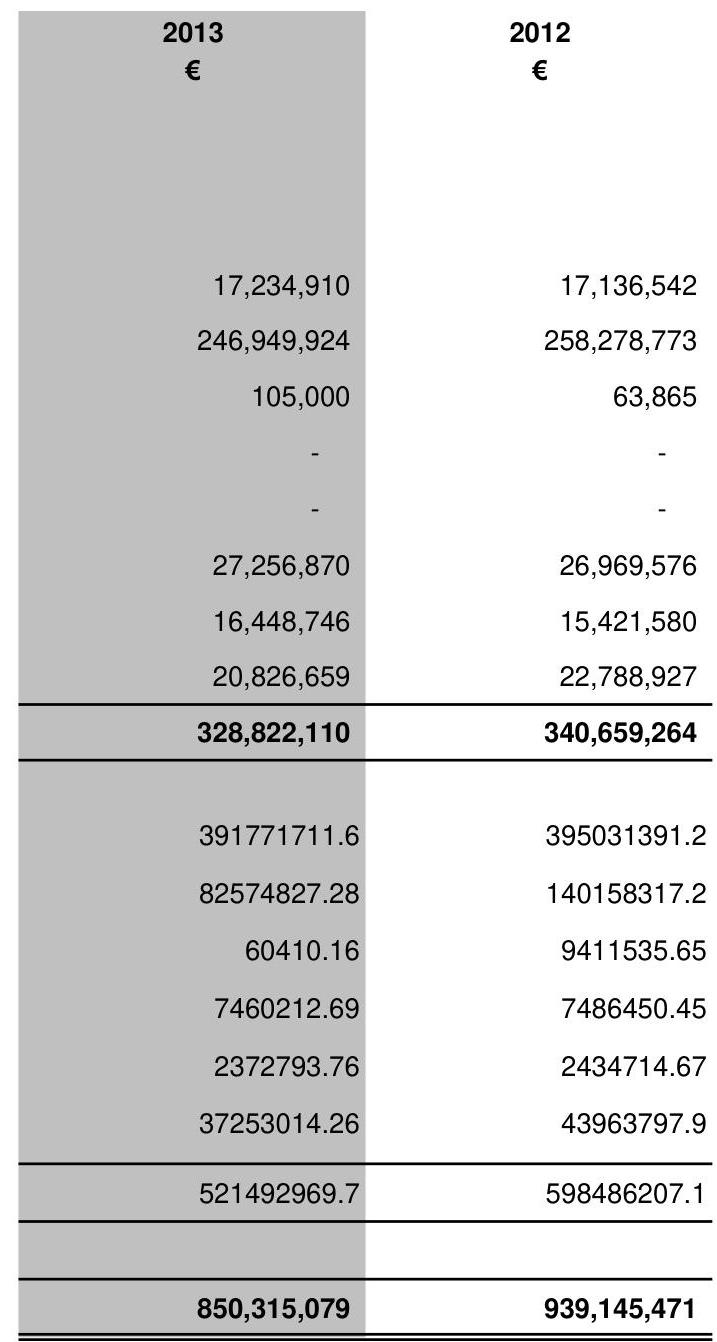

# APPENDIX 4 <br> ANALYSIS OF INCOME FROM GOODS AND SERVICE 

|  | 2013 | 2012 |
| :--: | :--: | :--: |
|  | € | € |
| Rents from Houses | 354,282,577 | 347,066,447 |
| Housing Loans Interest \& Charges | 42,463,115 | 48,611,983 |
| Domestic Water | 17,165 | 24,388 |
| Commercial Water | 157,230,267 | 141,014,586 |
| Domestic Refuse | 6,893,064 | 7,477,964 |
| Commercial Refuse | 5,700,960 | 7,460,872 |
| Domestic Sewerage | (113,639) | 113,503 |
| Commercial Sewerage | 35,338,316 | 32,110,045 |
| Planning Fees | 12,733,410 | 12,328,350 |
| Parking Fines/Charges | 87,916,671 | 90,340,738 |
| Recreation \& Amenity Activities | 22,643,532 | 23,038,463 |
| Library Fees/Fines | 2,284,035 | 2,298,777 |
| Agency Services | 20,227,173 | 21,049,606 |
| Pension Contributions | 57,226,633 | 58,877,994 |
| Property Rental \& Leasing of Land | 12,718,890 | 12,911,114 |
| Landfill Charges | 38,849,202 | 47,984,437 |
| Fire Charges | 12,738,565 | 12,268,892 |
| NPPR | 103,665,675 | 90,213,131 |
| Misc. (Detail) | 391,381,038 | 540,023,248 |
|  | 1,364,196,650 | 1,495,214,537 |

Page 37

# APPENDIX 5 <br> SUMMARY OF CAPITAL EXPENDITURE AND INCOME 

## EXPENDITURE

Payment to Contractors
Purchase of Land
Purchase of Other Assets/Equipment
Professional \& Consultancy Fees
Other

Total Expenditure (Net of Internal Transfers)
Transfers to Revenue
Total Expenditure (Incl Transfers) *

## INCOME

## Grants

Non - Mortgage Loans
Other Income
(a) Development Contributions
(b) Property Disposals

- Land
- LA Housing
- Other property
(c) Purchase Tenant Annuities
(d) Car Parking
(e) Other

Total Income (Net of Internal Transfers)
Transfers from Revenue
Total Income (Incl Transfers) *
Surplus (Deficit) for year
Balance (Debit):Credit @ 1 January
Balance (Debit):Credit @ 31 December

| 2013 | 2012 |
| :--: | :--: |
| € | € |
| 809,049,265 | 1,029,670,976 |
| 57,054,236 | 111,560,366 |
| 68,183,359 | 61,616,410 |
| 117,210,659 | 125,927,531 |
| 459,115,393 | 521,856,749 |
| 1,510,612,911 | 1,850,632,033 |
| 63,457,871 | 67,331,045 |
| 1,574,070,782 | 1,917,963,078 |
| 959,179,071 | 1,243,004,469 |
| 103,725,987 | 257,303,375 |
| $(1,080,062)$ | 45,881,542 |
| 23,805,845 | 6,735,367 |
| 46,495,188 | 32,374,187 |
| 2,662,958 | 1,384,319 |
| 7,441,833 | 52,671,965 |
| 6,057,687 | 6,502,384 |
| 165,190,832 | 153,866,660 |
| 1,313,479,340 | 1,799,724,267 |
| 168,025,303 | 129,127,055 |
| 1,481,504,642 | 1,928,851,322 |
| $(92,566,140)$ | 10,888,245 |
| 944,931,801 | 934,043,546 |
| 852,365,661 | 944,931,790 |

APPENDIX 6
ANALYSIS OF EXPENDITURE AND INCOME ON CAPITAL ACCOUNT

|  | BALANCE @ <br> 1/1/2013 | EXPENDITURE | INCOME |  |  |  | TRANSFERS |  |  | BALANCE @ <br> 31/12/2013 |
| :--: | :--: | :--: | :--: | :--: | :--: | :--: | :--: | :--: | :--: | :--: |
|  |  |  | Grants | Non-Mortgage <br> Loans* | Other | Total Income | Transfer from <br> Revenue | Transfer to Revenue | Internal <br> Transfers |  |
|  | € | € | € | € | € | € | € | € | € | € |
| Housing \& Building | (15,610,751) | 405,081,152 | 302,811,285 | 45,585,123 | 96,206,377 | 444,602,784 | 24,701,361 | 17,897,561 | 6,796,246 | 37,510,927 |
| Road Transportation \& Safety | 113,746,456 | 430,809,567 | 300,807,140 | 5,505,000 | 27,367,669 | 333,679,809 | 15,980,495 | 6,723,270 | 74,512,073 | 100,385,996 |
| Water Services | 131,372,242 | 411,273,145 | 269,675,260 | 28,671,936 | 59,728,976 | 358,076,172 | 7,367,996 | 18,472,781 | 33,689,337 | 100,759,822 |
| Development Management | 516,884,695 | 62,201,878 | 20,536,139 | 4,261,592 | 32,431,526 | 57,229,257 | 12,060,436 | 7,741,047 | (167,665,015) | 348,566,448 |
| Environmental Services | (49,697,301) | 57,898,607 | 22,855,489 | 14,357,448 | 6,376,453 | 43,589,390 | 39,108,277 | 1,405,778 | 13,586,943 | (12,717,077) |
| Recreation \& Amenity | (199,662) | 95,963,790 | 29,609,813 | 1,900,000 | 10,848,869 | 42,358,682 | 15,317,798 | 625,080 | 65,950,074 | 26,838,022 |
| Agriculture, Education, Health \& Welfare | 1,128,443 | 10,781,377 | 6,837,793 | - | 504,884 | 7,342,677 | 1,030,277 | 56,000 | 448,737 | (887,242) |
| Miscellaneous Services | 247,308,360 | 36,603,916 | 6,046,152 | 3,444,888 | 17,110,047 | 26,601,087 | 52,458,664 | 10,536,354 | (27,318,397) | 251,909,445 |
| TOTAL | 944,932,482 | 1,510,613,430 | 959,179,071 | 103,725,987 | 250,574,801 | 1,313,479,859 | 168,025,304 | 63,457,872 | (3) | 852,366,341 |

Note: Mortgage-related transactions are excluded

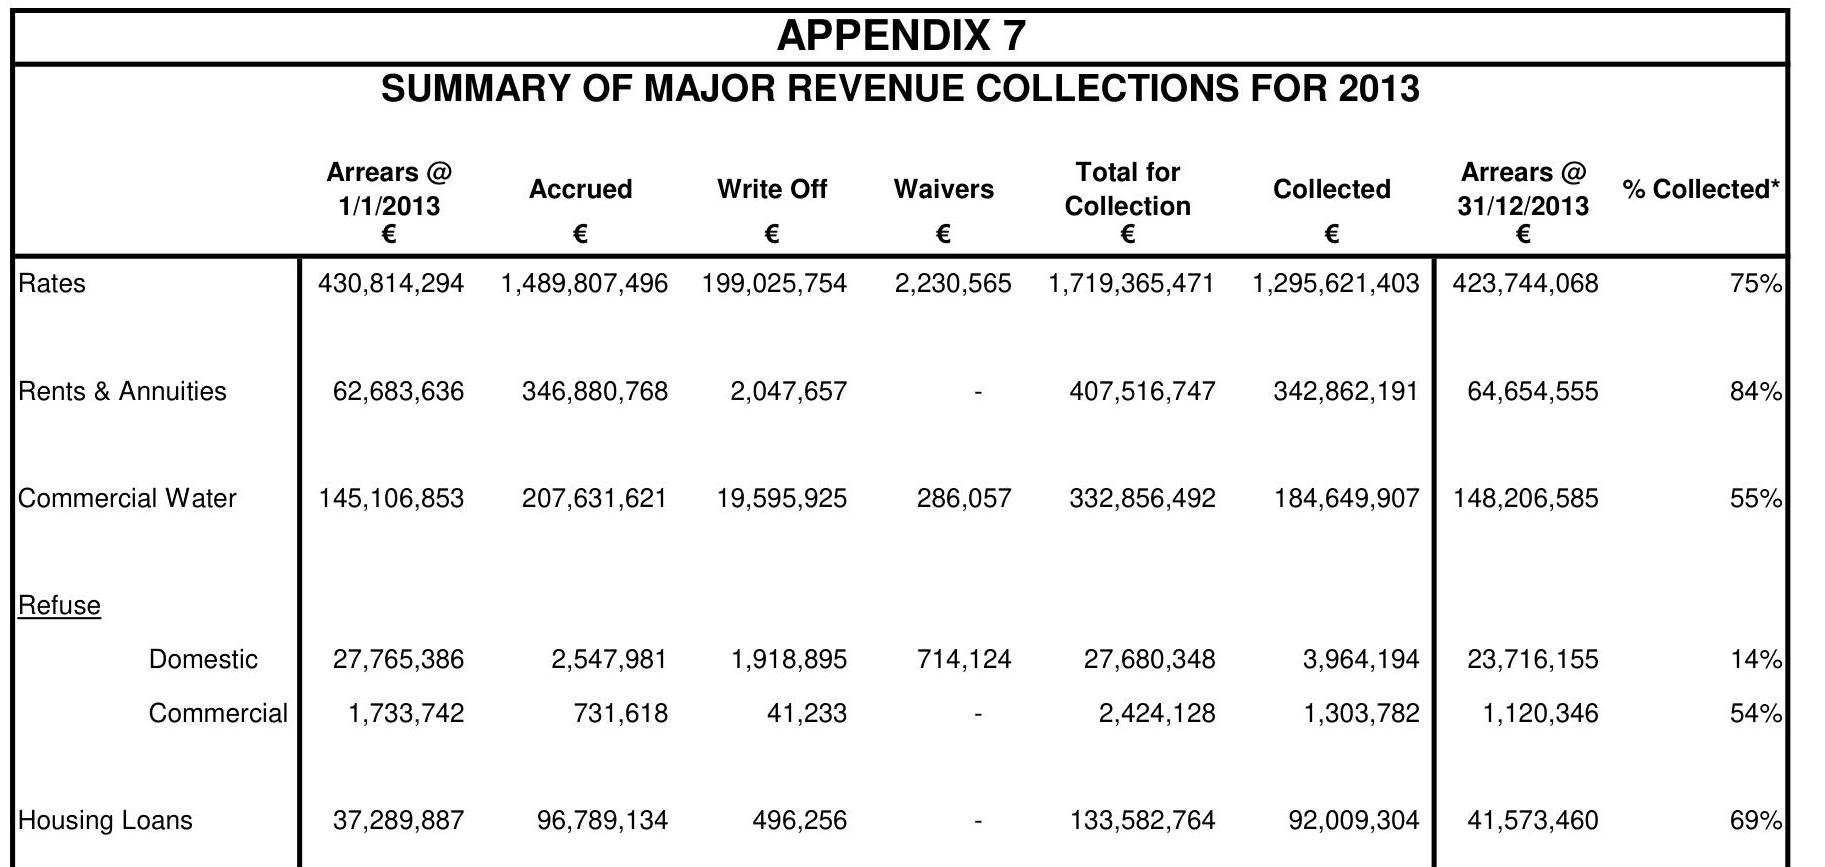

Note 1 The total for collection in 2013 includes arrears bifwd at 1/1/2013. This will tend to reduce the \% collected for 2013
Note 2 Rental income from Shared Ownership has been included under
Note 3 Income from Tenant Purchase Annuities has been included under
Note 4 Arrears brought forward is shown net of credit balances.

In [101]:
from mistralai.models import OCRResponse
from IPython.display import Markdown, display

def replace_images_in_markdown(markdown_str: str, images_dict: dict) -> str:
    for img_name, base64_str in images_dict.items():
        markdown_str = markdown_str.replace(f"![{img_name}]({img_name})", f"![{img_name}]({base64_str})")
    return markdown_str

def get_combined_markdown(ocr_response: OCRResponse) -> str:
  markdowns: list[str] = []
  for page in pdf_response.pages:
    image_data = {}
    for img in page.images:
      image_data[img.id] = img.image_base64
    markdowns.append(replace_images_in_markdown(page.markdown, image_data))

  return "\n\n".join(markdowns)

display(Markdown(get_combined_markdown(pdf_response)))

## Legal Paper (French)

In [102]:
from pathlib import Path

# Define the path to the downloaded PDF
pdf_file = Path("/content/attestation notariale.pdf")
# Ensure the file exists before proceeding
assert pdf_file.is_file()

{
    "pages": [
        {
            "index": 0,
            "markdown": "# SCP PIERRE AMALVY \n\nDossier suivi par\nSandrine ARNOUX\nVENTE CHATEAU DE L'AIGUETTA\n1004483 /PA /SA /CP\n\n## ATTESTATION\n\nAux termes d'un acte re\u00e7u par l'office notarial de Ma\u00eetre Pierre AMALVY Notaire, associ\u00e9 d'une Soci\u00e9t\u00e9 Civile Professionnelle titulaire d'un Office Notarial, dont le si\u00e8ge est \u00e0 MAUSSANE-LES-ALPILLES (Bouches du Rh\u00f4ne), 23 avenue de la Vall\u00e9e des Baux, le 30 ao\u00fbt 2017 il a \u00e9t\u00e9 constat\u00e9 la VENTE,\n\nAvec la participation de Ma\u00eetre Serge PASCAULT, notaire \u00e0 PARIS, assistant l'acqu\u00e9reur.\n\nPar:\nLa Soci\u00e9t\u00e9 d\u00e9nomm\u00e9e BANCA ARNER SA, Soci\u00e9t\u00e9 anonyme de droit suisse au capital de $7500000 \u20ac$, dont le si\u00e8ge est \u00e0 LUGANO (SUISSE), 8 place Manzoni, identifi\u00e9e au SIREN sous le num\u00e9ro CHE 103.630.014 et immatricul\u00e9e au Registre du Commerce et des Soci\u00e9
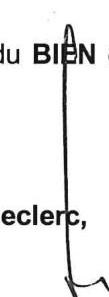

In [103]:
from mistralai import DocumentURLChunk, ImageURLChunk, TextChunk
import json

uploaded_file = client.files.upload(
    file={
        "file_name": pdf_file.stem,
        "content": pdf_file.read_bytes(),
    },
    purpose="ocr",
)

signed_url = client.files.get_signed_url(file_id=uploaded_file.id, expiry=1)

pdf_response = client.ocr.process(document=DocumentURLChunk(document_url=signed_url.url),
                                  model="mistral-ocr-latest",
                                  include_image_base64=True)

response_dict = json.loads(pdf_response.model_dump_json()) # Corrected to use model_dump_json
json_string = json.dumps(response_dict, indent=4)

print(json_string)

# SCP PIERRE AMALVY 

Dossier suivi par
Sandrine ARNOUX
VENTE CHATEAU DE L'AIGUETTA
1004483 /PA /SA /CP

## ATTESTATION

Aux termes d'un acte reçu par l'office notarial de Maître Pierre AMALVY Notaire, associé d'une Société Civile Professionnelle titulaire d'un Office Notarial, dont le siège est à MAUSSANE-LES-ALPILLES (Bouches du Rhône), 23 avenue de la Vallée des Baux, le 30 août 2017 il a été constaté la VENTE,

Avec la participation de Maître Serge PASCAULT, notaire à PARIS, assistant l'acquéreur.

Par:
La Société dénommée BANCA ARNER SA, Société anonyme de droit suisse au capital de $7500000 €$, dont le siège est à LUGANO (SUISSE), 8 place Manzoni, identifiée au SIREN sous le numéro CHE 103.630.014 et immatriculée au Registre du Commerce et des Sociétés de LUGANO.

Au profit de :
La Société dénommée VILLA AIGUETTA EZE, Société civile immobilière au capital de 1.000,00 Euros $€$, dont le siège est à BEAULIEU-SUR-MER (06310), 25 Boulevard Général Leclerc, identifiée au SIREN sous le numéro 831191002 et immatriculée au Registre du Commerce et des Sociétés de NICE.

## Quotités acquises :

La société VILLA AIGUETTA EZE acquiert la pleine propriété du BIEN objet de la vente.

## IDENTIFICATION DU BIEN

A EZE (ALPES-MARITIMES) 06360570 Boulevard Maréchal Leclerc,
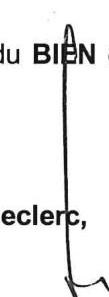

23 avenue de la Vallée des Baux (Parking place Henri Giraud) - B.P. 30 - 13520 MAUSSANE-LES-ALPILLES
Tél. : 0490543398 - Fax : 0490543078
E-mail : pierre.amalvy@notaires.fr / laurie.albentosa@notaires.fr
Permanence à Fontvieille

Une propriété dénommée "Château de l'Aiguetta", détachée d'un ensemble plus important et comprenant une bâtisse avec un corps principal englobé dans un vaste volume composite de quatre étages carrés et d'un étage de soubassement ; une aile rectangulaire de deux étages carrés, précédée d'un volume semi-circulaire en soubassement, couvert en terrasse. L'ensemble est ponctué de tours rondes, de tours carrées et de guettes. L'une des tour carrée est flanqué de tourelles couvertes de toits coniques.

Le rez-de-chaussée, ne communique pas intérieurement avec le rez-de-jardin. Un escalier monumental dessert les niveaux rez-de-jardin jusqu'au toit terrasse.

Les façades sont en pierres et la totalité de l'intérieur est en état brut de décoffrage. Le tout hors d'eau et hors d'air.

Un petit pavillon à l'ouest du château.
Avec un ensemble de terrain attenant en nature de parc et de friche, avec un grand bassin.

Figurant ainsi au cadastre :

| Section | $\mathrm{N}^{\circ}$ | Lieudit | Surface |
| :-- | :-- | :-- | :-- |
| AI | 158 | l'Aiguetta | 00 ha 75 a 19 ca |
| AI | 344 | 530Bd Mal Leclerc | 00 ha 72 a 97 ca |
| AI | 350 | L'Aiguetta | 00 ha 27 a 32 ca |
| AI | 14 | Reveire | 00 ha 17 a 63 ca |
| AI | 51 | Serre de Fourque | 00 ha 25 a 13 ca |
| AI | 52 | Serre de Fourque | 00 ha 03 a 07 ca |
| AI | 351 | Serre de Fourque | 03 ha 97 a 13 ca |

Total surface : 06 ha 18 a 44 ca

# PROPRIETE JOUISSANCE 

L'ACQUEREUR est propriétaire du BIEN à compter du jour de la signature.
Il en a la jouissance à compter du même jour par la prise de possession réelle, les parties déclarant que le BIEN est entièrement libre de location ou occupation.

EN FOI DE QUOI la présente attestation est délivrée pour servir et valoir ce que de droit.

FAIT A MAUSSANE-LES-ALPILLES (Bouches du Rhône),

In [104]:
from mistralai.models import OCRResponse
from IPython.display import Markdown, display

def replace_images_in_markdown(markdown_str: str, images_dict: dict) -> str:
    for img_name, base64_str in images_dict.items():
        markdown_str = markdown_str.replace(f"![{img_name}]({img_name})", f"![{img_name}]({base64_str})")
    return markdown_str

def get_combined_markdown(ocr_response: OCRResponse) -> str:
  markdowns: list[str] = []
  for page in pdf_response.pages:
    image_data = {}
    for img in page.images:
      image_data[img.id] = img.image_base64
    markdowns.append(replace_images_in_markdown(page.markdown, image_data))

  return "\n\n".join(markdowns)

display(Markdown(get_combined_markdown(pdf_response)))

# ✅ Summary

In this notebook, we successfully explored how to use **Mistral OCR** for structured text extraction from documents and images.

### ✅ Key Accomplishments:
- Installed required libraries and set up the API
- Downloaded and verified sample files
- Initialized the Mistral client and processed files via OCR
- Understood how to work with structured outputs for real-world documents

You can now integrate OCR results into intelligent document workflows like data extraction, receipts parsing, or contract analysis.

---

*Powered by [Mistral AI](https://console.mistral.ai)* ✨
